# Homework 07: Ensemble Methods – Bagging, Random Forests, and Gradient Boosting

## Due: Midnight on March 16 (with 2-hour grace period) and worth 75 points

Over the past two weeks, we have expanded our machine learning toolkit by moving beyond linear regression to explore decision trees, which introduced a variety of interacting parameters. Through Homework 6, you developed a systematic workflow for parameter tuning that balances manual exploration and automated searches (e.g., random or grid search) to optimize performance while gaining insights into model behavior.

This week, we take another step forward by studying ensemble methods which combine multiple decision trees to produce even stronger predictive models. Specifically, we will investigate:

- Bagging  
- Random Forests  
- Gradient Boosting  

These three approaches build on the decision tree we studied last week. Our  workflow from Homework 6 will again serve as the foundation for optimizing these more complex models.

### What We Will Do in This Homework

To analyze and optimize our ensemble models, we will apply the two-phase strategy introduced in Homework 6 (but with grid search rather than random grid search):

1. **First Phase:**  
   - Iteratively sweep through key parameters in coarse ranges  
   - Visualize training, validation, and test MSE  
   - Diagnose overfitting or underfitting  
   - Examine the standard deviation of CV scores to understand model stability (review Problems 1 & 2 in Homework 6)

2. **Second Phase:**  
   - Focus on the most unstable or promising parameter ranges found in Phase 1  
   - Perform an exhaustive search within these narrower ranges using `GridSearchCV` (review Problem 4 in Homework 6)

Refer to **Appendix 4** for more details.

We will follow this process for each of the three ensemble methods, systematically tuning their four most important parameters:

1. **Bagging Regressor:** `n_estimators`, `max_samples`, `max_features`, `bootstrap`  
2. **Random Forest Regressor:** `n_estimators`, `max_depth`, `max_features`, `bootstrap`  
3. **Gradient Boosting Regressor:** `learning_rate`, `n_estimators`, `max_depth`, `max_features`

Throughout this homework, we will continue using `RepeatedKFold` cross-validation to reduce variance in our CV MSE estimates. The default number of repetitions is 10, but you may find it necessary to reduce this when initially searching broad parameter spaces—then increase it for fine-tuning as you zero-in on the best models. 

As before, you will store your best parameter values (and the resulting CV MSE) in a dictionary in order to track improvements across experiments and maintain a clear record of how each parameter choice was made.

Before starting:
- Review lesson materials on ensemble methods and watch the three videos on Bagging, Random Forests, and Gradient Boosting.  
- Study the relevant appendices.  
- Pay special attention to the Gradient Boosting video and notebook, as the code in this homework builds on (and has been adapted from) those resources.

### Grading

This homework consists of 15 graded problems, each worth 5 points, for a total of 75 points.

### Imports

In [627]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from sklearn.model_selection    import train_test_split, cross_val_score, RepeatedKFold,GridSearchCV, RandomizedSearchCV
from sklearn.ensemble           import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics            import mean_squared_error
from tqdm                       import tqdm
from sklearn.model_selection    import RandomizedSearchCV
from sklearn.utils              import all_estimators
from typing import Any, Dict, List, Union, Tuple
from sklearn.base import BaseEstimator


import matplotlib.ticker as mticker           # Optional: you can print out y axis labels as dollars. 

# To avoid constant warnings about jobs: 
#        UserWarning: A worker stopped while some jobs were given to the executor. 
#        This can be caused by a too short worker timeout or by a memory leak.

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# globals
random_state = 42


### Utility Code

<span style="color:magenta"> 
ALERT !  

- I have added the argument 'exp_factor' to <b>run_model</b>. The mean_cv_mse and std_cv_mse values calculated in run_model are raised to the exp_factor (Default:exp_factor = 1, Square root: exp_factor = 0.5)

- I've added type declarations wherever possible for better readability. 


</span>

In [168]:

# Completely optional:  Format y-axis labels as dollars with commas
def dollar_format(x, pos):
    return f'${x:,.0f}'

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [169]:
def df_format_dropDuplicateRows(df, column = None):
    '''
    For a given dataframe, replace all NaN values with None, drop duplicate rows, 
    format the specified column, return the cleaned dataframe.
    '''
    df = df.replace({np.nan: None}).drop_duplicates()
    
    return df

In [ ]:
def get_best_row(df: pd.DataFrame, column_name: str, favorability: str = 'min'):
    """
    Returns a dataframe filtered to the row with the best value in the specified column, where 'best'
    means either smallest (favorability = 'min') or largest (favorability = 'max').
    """

    col = df[column_name]
    if col.dtype == 'object':
        col = pd.to_numeric(col, errors='coerce')
    df[column_name] = col
    if favorability == 'max':
        return df[df[column_name] == df[column_name].max()]
    else:
        return df[df[column_name] == df[column_name].min()]

In [531]:

def update_clean_model_params(model_constructor, params):
    ''' Takes a regressor constructor and a dictionary of parameters 
    removes any keys that are not valid parameters for the model, 
    and returns a reduced dictionary of UPDATED valid parameters to pass to the next model test.

    Note: the updated valid parameters should contain the values from the most recent tuning sweep.
    '''
    # Get the list of all valid estimators
    all_estimators_list = all_estimators()
    
    # Find estimator class
    estimator_class = None
    for name, est in all_estimators_list:
        if est == model_constructor:
            estimator_class = est
            break
    
    if estimator_class is None:
        raise ValueError("The provided model constructor is not a valid estimator.")
    
    # Get  valid parameter names for the estimator
    valid_params = estimator_class().get_params().keys()
    
    # Filter  params dictionary
    filtered_params = {k: v for k, v in params.items() if k in valid_params}
    
    return filtered_params

In [807]:
def get_parameter_list(parameter: str,  
                       custom_list: list = None, 
                       df: pd.DataFrame = None
                       ):
    """
    Returns a list of parameter values based on the given parameter name, using a dictionary.

    Args:
        parameter: name of the parameter.
        custom_list: Optional list of custom values, which will override the values in parameter_dict.
        df: Optional DataFrame, used for calculating total features for 'max_features'.

    Returns:
        A list of parameter values.
    """

    parameter_dict = {
        'n_estimators': list(np.arange(250, 1001, 50)),
        'max_samples': [1.0],
        'max_depth': [None] + list(np.arange(2, 26)),
        'bootstrap': [True, False],
        'learning_rate': list(np.arange(.01, .50, .05))
    }

    if custom_list is not None:
        parameter_dict[parameter] = custom_list

    if parameter == 'max_features':
        if df is None:
            raise ValueError("DataFrame 'df' is required to calculate 'max_features'.")
        if parameter_dict.get('max_features') is not None:
            return parameter_dict['max_features']
        else:
            total_features = df.shape[1]
            return list(range(20, total_features)) # or list(range(18, total_features+1)), or any other range you wish.
    
    elif parameter in parameter_dict:
        return parameter_dict[parameter]
    
    else:
        return []
    

        # return list(range(18, total_features+1))  # max_features = 28: CV MSE = 25,049.546, Train MSE = 130.273, Test MSE = 25,806.559
        # return list(range(4, 25))  # max_features = 24: CV MSE = 26,339.501, Train MSE = 9,583.217, Test MSE = 26,577.230
        # return list(range(36, 46))   # max_features = 40: CV MSE = 25,906.960, Train MSE = 9,598.130, Test MSE = 26,262.149
        # return list(range(47, 52)) # max_features = 48: CV MSE = 26,015.793, Train MSE = 9,496.988, Test MSE = 26,594.258
        # return [38,39,40] # max_features = 40: CV MSE = 25,906.960, Train MSE = 9,598.130, Test MSE = 26,262.149




In [539]:
def process_results(
        search: Any, 
        exp_factor: float = 1
) -> pd.DataFrame:
    
    """
    Processes the cross-validation results from a search algorithm (GridSearchCV or RandomizedSearchCV) and formats them into a readable DataFrame.

        Parameters:
            - search: The search object (GridSearchCV or RandomizedSearchCV) after fitting.
            - exp_factor: The exponent factor to apply to the scores. Use 0.5 for RMSE (Root Mean Squared Error) or 1 for MSE (Mean Squared Error).

        Returns:
            - A DataFrame containing the relevant columns from the search results, with scores converted and columns renamed for readability.
    """
    results_df = pd.DataFrame(search.cv_results_)
    print(f'results_df.columns:\n {results_df.columns}')
    # print(f'results_df:\n {results_df}')    


    # Selecting relevant columns for readability
    columns_to_select = [
        'param_n_estimators', 'param_max_samples', 'param_max_features',
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]

    # Filter out columns that are not present in the results
    columns_to_select   = [col for col in columns_to_select if col in results_df.columns]
    results_df          = results_df[columns_to_select]


    # Convert negative MSE to positive; for square root, set exp_factor = 0.5 
    results_df['std_test_score']    = results_df['std_test_score'] ** exp_factor
    results_df['std_train_score']   = results_df['std_train_score'] ** exp_factor
    results_df['mean_test_score']   = (-results_df['mean_test_score']) ** exp_factor
    results_df['mean_train_score']  = (-results_df['mean_train_score']) ** exp_factor
    
    # Sort by rank (best scores first)
    results_df = results_df.sort_values(by='rank_test_score').round(3)

    # Rename columns for printing only
    renamed_results_df = results_df.rename(columns={
        'param_n_estimators':   'n_estimators',
        'param_max_samples':    'max_samples',
        'param_max_features':   'max_features',
        'mean_test_score':      'mean_cv_score',
        'std_test_score':       'std_cv_score',
        'mean_train_score':     'mean_train_score',
        'std_train_score':      'std_train_score'
    }).drop(columns=['rank_test_score'])

    return renamed_results_df

In [643]:
## dictionary of column names of dataframe to store results for each ensemble method. ##

ensemble_df_columns = {
    'BaggingRegressor': ['Model', 'Test_Param','cv_repeats', '(R)MSE_found', 'test_(R)MSE', 'n_estimators', 'max_samples', 'max_features', 'bootstrap', 'execution_time', 'timestamp'],
    'RandomForestRegressor': ['Model', 'Test_Param','cv_repeats', '(R)MSE_found', 'test_(R)MSE', 'n_estimators', 'max_depth', 'max_features', 'bootstrap', 'execution_time', 'timestamp'],
    'GradientBoostingRegressor': ['Model', 'Test_Param','cv_repeats', '(R)MSE_found', 'test_(R)MSE', 'n_estimators', 'learning_rate', 'max_depth', 'max_features', 'bootstrap', 'execution_time', 'timestamp']
}

In [626]:
def df_col_check(df_columns: list, best_params_dict: dict):
    """
        If the destination dataframe of ensemble method results contains a column name that isn't a key in the best parameters dictionary, 
        populate the column with 'None' 
    """

    for col in df_columns:
        if col not in best_params_dict:
            best_params_dict[col] = None

In [711]:
def build_best_params_df(
    search: Any,  # Typically a GridSearchCV or RandomizedSearchCV object
    best_CV_MSE: float,
    execution_time: float,
    timestamp: str,
    model_name: str,
    test_mse: float,
    model_df_cols: List[str],
    test_param: str,
    n_repeats: int
) -> pd.DataFrame:
    
    """
        Processes the best parameters found by a search algorithm (GridSearchCV or RandomizedSearchCV) and formats them into a DataFrame.
            Parameters:
                - search: The search object (GridSearchCV or RandomizedSearchCV) after fitting.
                - best_CV_MSE: The best cross-validation mean squared error found by the search.
                - execution_time: The time taken to execute the search.
                - model_name: The name of the model being evaluated.
                - test_mse: The mean squared error on the test set.
                - model_df_cols: The columns expected in the resulting DataFrame.
                - test_param: A string indicating whether GridSearchCV or RandomizedSearchCV was used.
                - n_repeats: The number of cross-validation repeats.

            Returns:
                - A DataFrame containing the best parameters and additional metadata.
    """
    
    best_params                     = search.best_params_
    best_params['(R)MSE_found']     = round(best_CV_MSE,4)
    best_params['test_(R)MSE']      = test_mse
    best_params['execution_time']   = execution_time
    best_params['Model']            = model_name
    best_params['Test_Param']       = test_param
    best_params['cv_repeats']       = n_repeats
    best_params['timestamp']        = timestamp

    df_col_check(model_df_cols, best_params)
    best_params_df = pd.DataFrame([best_params], columns = model_df_cols)
    best_params_df = df_format_dropDuplicateRows(best_params_df)

    return best_params_df


### Load the Ames Housing Dataset  

The code cell below will load the dataset for you.  This is the same dataset we used for the last two homeworks. 

> **Notice** that this code includes a useful optimization: **before downloading, it first
checks whether the files already exist.** This is a essential step when working with large datasets or when building deep learning models, where training can span hours or even days. By reusing previously downloaded files or saved models, you can avoid unnecessary work and significantly speed up your workflow.

For a detailed description of the dataset features, please refer to the **Appendix** in Homework 05. 

In [19]:
data_dir = "Ames_Dataset"                              # Directory where files will be stored

# Check if one of the files exists; if not, download and extract the zip file

if not os.path.exists( os.path.join(data_dir, "X_train.csv") ):
    print("Dataset files not found. Downloading...")
    zip_url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/ames_housing.zip"
    try:
        response = requests.get(zip_url)
        response.raise_for_status()  # Raise an error for bad status codes
        # Extract the zip file into the designated directory
        with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
            zipf.extractall(data_dir)
        print("Files downloaded and extracted successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("Dataset files already exist. Skipping download.")

# Load the datasets
X_train = pd.read_csv(os.path.join(data_dir, "X_train.csv"))
X_test  = pd.read_csv(os.path.join(data_dir, "X_test.csv"))
y_train = pd.read_csv(os.path.join(data_dir, "y_train.csv")).squeeze("columns")    
y_test  = pd.read_csv(os.path.join(data_dir, "y_test.csv")).squeeze("columns")

print("Training and testing datasets loaded successfully.")


Dataset files already exist. Skipping download.
Training and testing datasets loaded successfully.


## Prelude: Wrapper Functions for Running Ensemble Models

The following cells are adapted from the Week 7 video notebook on `GradientBoostingRegressor`, but have been refactored so that they can handle any of the three ensemble models (Bagging, Random Forest, or Gradient Boosting). Key changes include:

- **`run_model`** replaces the original `run_gradient_boosting_regressor` and accepts a parameter dictionary that can be applied to any of the three ensemble models.  
- **`sweep_parameter`** is updated to work seamlessly with `run_model`, letting you:
  - Specify which ensemble model you want to use.  
  - Pass a dictionary of model parameters.  
  - Return a modified parameter dictionary reflecting the best value of the parameter you swept, along with the corresponding MSE  (note that RMSE is **only** used for printing out results_df_df_df_df)

> **Note:** Please do not change these cells unless you consult with the LFs first. Any alterations may cause downstream issues with the assignment.

### run_model

In [547]:
def run_model(
    model: Union[BaseEstimator, type],  # The model or model class
    X_train: np.ndarray,  # Training feature set
    y_train: np.ndarray,  # Training target set
    X_test: np.ndarray,  # Testing feature set
    y_test: np.ndarray,  # Testing target set
    n_repeats: int = 10,  # Number of repeats for cross-validation
    n_jobs: int = -1,  # Number of jobs to run in parallel
    exp_factor: float = 1,  # Exponent factor for MSE values
    **model_params: Any  # Additional parameters for the model
) -> Tuple[float, float, float, float]:
    
    """
    Runs a machine learning model with cross-validation and computes performance metrics.

        Parameters:
            - model: The machine learning model or model class to be used.
            - X_train: Training feature set.
            - y_train: Training target set.
            - X_test: Testing feature set.
            - y_test: Testing target set.
            - n_repeats: Number of repeats for cross-validation (default is 10).
            - n_jobs: Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
            - exp_factor: Exponent factor to apply to the MSE values (default is 1).
            - **model_params: Additional parameters to pass to the model if a class is provided.

        
        Returns (all raised to power of exp_factor):
            - mean_cv_mse: Mean cross-validated MSE
            - std_cv_mse: Standard deviation of cross-validated MSE
            - train_mse: Training set MSE
            - test_mse: Testing set MSE
    """
    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)
        # print(f'Instantiating model with parameters: {model_params}')

    neg_mse_scores = cross_val_score(model, 
                                     X_train, 
                                     y_train,
                                     scoring    = 'neg_mean_squared_error',
                                     cv         = RepeatedKFold(n_splits = 5, n_repeats = n_repeats, random_state = 42), 
                                     n_jobs     = n_jobs)
    
    mse_scores  = (-neg_mse_scores) ** exp_factor
    mean_cv_mse = round(np.mean(mse_scores),3)
    std_cv_mse  = round(np.std(mse_scores), 3)
    
    # mean_cv_mse = round(np.mean(mse_scores) ** exp_factor,3)
    # mean_cv_mse = round((-np.mean(neg_mse_scores)) ** exp_factor,3)
    # std_cv_mse  = round(np.std(neg_mse_scores), 3)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train)
    train_mse   = round(mean_squared_error(y_train, train_preds) ** exp_factor, 3)
    test_preds  = model.predict(X_test)
    test_mse    = round(mean_squared_error(y_test, test_preds) ** exp_factor, 3)
    
    return mean_cv_mse, std_cv_mse, train_mse, test_mse


### sweep_parameter

In [654]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
                    ) -> Dict[str, Any]:
    """
        Sweeps a specified parameter of a machine learning model and evaluates performance metrics.

            Parameters:
                - model:            The machine learning model or model class to be used.
                - Parameters:       Dictionary of model parameters.
                - param:            The parameter to sweep.
                - parameter_list:   List of values to test for the specified parameter.
                - X_train:          Training feature set.
                - y_train:          Training target set.
                - X_test:           Testing feature set.
                - y_test:           Testing target set.
                - verbose:          If True, prints detailed output and plots results (default is True).
                - show_rmse:        If True, shows RMSE instead of MSE (default is True).
                - n_iter_no_change: Number of iterations with no improvement to trigger early stopping (default is None).
                - delta:            Minimum change in MSE to qualify as an improvement (default is 0.001).
                - n_jobs:           Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
                - n_repeats:        Number of repeats for cross-validation (default is 10).

            Returns:
                - Parameters: Updated dictionary of model parameters with the best parameter value found and additional information.
    """ 
    start       = time.time()
    Parameters  = Parameters.copy()  # Avoid modifying the original dictionary

    print(f"Running {model.__name__} with {param} sweep...\n")
    cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
    no_improve_count    = 0
    best_mse            = float('inf')

    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"\nSweeping {param}"):
        Parameters[param]   = p
        P_temp              = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('(R)MSE_found', None)

        cv_mse, std_cv, train_mse, test_mse = run_model(
            model       = model,
            X_train     = X_train, 
            y_train     = y_train,
            X_test      = X_test,  
            y_test      = y_test,
            n_repeats   = n_repeats,
            n_jobs      = n_jobs,
            exp_factor  = 0.5 if show_rmse else 1,  
            **P_temp
        )
        print(f"{param} = {p}: CV MSE = {cv_mse:,.3f}, Train MSE = {train_mse:,.3f}, Test MSE = {test_mse:,.3f}")
        cv_mses.append(cv_mse)
        std_cvs.append(std_cv)
        train_mses.append(train_mse)
        test_mses.append(test_mse)

        # Early-stopping logic
        if cv_mse < best_mse - delta:
            best_mse            = cv_mse
            no_improve_count    = 0
        else:
            no_improve_count    += 1    

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    min_cv_mse                  = min(cv_mses)
    min_index                   = cv_mses.index(min_cv_mse)
    best_param                  = parameter_list[min_index]
    Parameters['Test_Param']    = param
    Parameters[param]           = best_param
    Parameters['Model']         = model.__name__
    Parameters['(R)MSE_found']  = round(min_cv_mse,3)
    Parameters['cv_repeats']    = n_repeats
    Parameters['test_(R)MSE']   = round(test_mses[min_index],3)

    end                             = time.time()
    execution_time                  = end - start
    Parameters['execution_time']    = format_hms(execution_time)

    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    Parameters['timestamp']         = timestamp

    if verbose:
        plt.rcParams.update({"font.size": 9})

        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[: len(cv_mses)]

        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list

        error_name = "RMSE" if show_rmse else "MSE"

        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{Parameters['Model']} | {error_name} vs {param}")

        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

        ax1.plot(x_vals,
                 cv_mses,
                 marker='.', label = f"CV {error_name}", color = 'midnightblue'
                 )
        ax1.plot(x_vals,
                 train_mses,
                 marker='.', label = f"Train {error_name}", color = 'green'
                 )
        ax1.plot(x_vals,
                 test_mses,
                 linestyle='--', label = f"Test {error_name}", color = 'orange'
                 )
        ax1.scatter([x_vals[min_index]],
                    [min_cv_mse],
                    marker='x', s = 100 ,label = f"Best CV {error_name}", color = 'red'
                    )      
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()

        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"{Parameters['Model']} | CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='midnightblue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha = 0.5)

        # Format y-axis numbers with commas
        ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

    # Print the timestamp of successful execution
    print("Execute successfully at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end)))
    print(f'time.localtime(end): {time.localtime(end)}')
    print(f'Parameters: {Parameters}')
    return Parameters



### GridSearchCV or RandomizedSearchCV

In [ ]:
def run_GridSearch_RandomizedSearch_CV(
        ensemble_model, 
        parameter_grid, 
        randomized_search   = True,
        show_RMSE           = True,
        X_train             = X_train,
        y_train             = y_train,
        iterations          = 10,
        n_jobs              = -1,
        verbose             = True,
        n_repeats           = 10,
        cv_folds            = 5,
        random_state        = None):

        """
        Performs hyperparameter tuning for an ensemble model using either GridSearchCV or RandomizedSearchCV 
        from the scikit-learn library. Evaluates model's performance using repeated k-fold cross-validation and returns the best 
        parameters and their corresponding performance metrics.

            Parameters:
                - ensemble_model:                           ensemble model class to be tuned (e.g., RandomForestRegressor).
                - parameter_grid:                           Dictionary containing the hyperparameters to be tuned and their respective ranges/values.
                - randomized_search (bool, default=True):   If True, uses RandomizedSearchCV; otherwise, uses GridSearchCV.
                - show_RMSE (bool, default=True):           If True, calculate Root Mean Squared Error (RMSE); otherwise, Mean Squared Error (MSE)
                - X_train:                                  Training feature set.
                - y_train:                                  Training target set.
                - iterations (int, default=10):             Number of iterations for RandomizedSearchCV.
                - n_jobs (int, default=-1):                 Number of jobs to run in parallel. -1 means using all processors.
                - verbose (bool, default=True):             If True, prints detailed logs.
                - n_repeats (int, default=10):              Number of repeats for the cross-validation.
                - cv_folds (int, default=5):                Number of folds for cross-validation.
                - random_state (int, default=None):         Random seed for reproducibility.

            Returns:
                - best_params_df: DataFrame containing the best parameters and their corresponding performance metrics.
        """

        model                   = ensemble_model(random_state = random_state)
        model_name              = ensemble_model.__name__
        model_df_cols           = ensemble_df_columns[model_name]
        use_RandomizedSearchCV  = randomized_search
        total_features          = X_train.shape[1]
        # use_RandomizedSearchCV  = randomized_search

        exp_factor = 0.5 if show_RMSE else 1


    # Use GridSearchCV or RandomizedSearchCV (not as accurate but faster) to find the best parameters

        if use_RandomizedSearchCV: 
            print("Using RandomizedSearchCV............................................")
            search = RandomizedSearchCV(
                estimator             = model,
                param_distributions   = parameter_grid,
                n_iter                = iterations,  # Number of random combinations to test
                scoring               = 'neg_mean_squared_error',  # MSE but negated for maximization by RandomizedSearchCV
                cv                    = cv_folds,  # Number of folds for cross-validation
                n_jobs                = n_jobs,  # Use all available cores
                # random_state          = random_state,
                return_train_score    = True  # Include training score in results
            )
        else:
            print("Using GridSearchCV............................................")
            search = GridSearchCV(
                estimator           = model,
                param_grid          = parameter_grid,
                scoring             = 'neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
                cv                  = cv_folds,  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
                n_jobs              = n_jobs,  # Use all available cores
                return_train_score  = True
            )


        start = time.time()
        search.fit(X_train, y_train)


        # Extract results_df into a DataFrame
        renamed_results_df = process_results(search, exp_factor)

        # Print the results as a table
        top_n = 10
        print(f"\nSearch Results (Top {top_n}):\n")
        print(renamed_results_df.head(top_n).to_string(index = False))  # Show the top n results with new headers

        # Best parameters and test performance
        print(f"\nBest Parameters: {search.best_params_}")

        best_CV_MSE = (-search.best_score_) ** exp_factor
        print(f"Best CV MSE: {best_CV_MSE:,.3f}")

        # Evaluate on the test set
        y_pred_bagging  = search.best_estimator_.predict(X_test)
        test_mse        = round(mean_squared_error(y_test, y_pred_bagging) ** exp_factor,3)
        print(f"Test MSE:    {test_mse:,.3f}")

        # Record end time and execution time
        end             = time.time()
        execution_time  = format_hms(end - start)
        print(f"Execution Time: " + execution_time)

        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))

        # Print the timestamp of successful execution
        print("Execute successfully at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))) 

        if use_RandomizedSearchCV:
            best_params_randomsearch_df = build_best_params_df(
                search, best_CV_MSE, execution_time, timestamp, model_name, test_mse, model_df_cols, 'RandomizedSearchCV', n_repeats
            )
            return best_params_randomsearch_df
        else:
            best_params_gridsearch_df = build_best_params_df(
                search, best_CV_MSE, execution_time, timestamp, model_name, test_mse, model_df_cols, 'GridSearchCV', n_repeats
            )
            return best_params_gridsearch_df
    

## **Problem One: Bagging Trees**  

In this problem, you will follow a structured workflow to tune and evaluate a **Bagging Regressor**. The process builds on the approach from the last two homeworks; note that, as Homework 06, we will apply **grid search** to systematically explore parameter values.  Note that we will **not** be used Early Stopping in this homework; this will be a valuable technique going forward, but in this homework we are still learning how these complex models perform.

At the end of the analysis, you will not simply select the model with the lowest CV MSE score. Instead, you will critically examine the plots to determine whether another model configuration provides a better balance between performance, stability, and generalization. This step is essential for ensuring that your chosen model will perform well on new data. The criteria we will use for this choice are in **Appendix 5** below. 

### **Part 1.A: Iteratively Sweep Parameters and Visualize Results using `sweep_parameter(...)`**  
We will start with the `Default_Parameters_Bagging` dictionary and iteratively adjust key parameters. At each step, using the code provided above, you will:  

- Test a range of values for the specified parameter.
- Plot training, repeated cross-validation, and test MSE to diagnose overfitting or underfitting.
- Plot the standard deviation of the CV scores to assess model stability.
- Store the best value (which produces the minimum CV MSE) in a dictionary, perhaps called `Parameters_BT`.

**You should read Appendix 4 now if you have not done so already.**

**Step-by-step process:**
1. **Sweep `n_estimators`** (integer values):  
   - Begin by *making a copy* of the provided `Default_Parameters_Bagging` dictionary.  
   - Sweep a range of **integer** values for `n_estimators` (the number of base learners).  
   - Store the best value in `Parameters_BT`. 

2. **Sweep `max_samples`** (float values):  
   - Using `Parameters_BT`, test a range of **float** values for `max_samples`.  
   - Store the best value in `Parameters_BT`. (*Note: This may simply be the default value!*)

3. **Sweep `max_features`** (integer values):  
   - Using `Parameters_BT`, test a range of **integer** values for `max_features`.  
   - Store the best value in `Parameters_BT`. (*Again, the best value might be the default!*)

4. **Sweep `bootstrap`** (Boolean values):  
   - Test both possible values (`True` and `False`).  
   - Store the best value in `Parameters_BT`.

5. **Report your final results (including all final parameter choices, and convert MSE to RMSE in dollars when printing out)** and answer the graded question. 

In [550]:
# Define the parameters for the BaggingRegressor
Default_Parameters_Bagging = {
    'n_estimators': 10,            # Number of base estimators in the ensemble
    'max_samples' : 1.0,           # Fraction of samples to draw for each base estimator
    'max_features': 1.0,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    '(R)MSE_found': float('inf'),   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
    'cv_repeats'  : 2,            # Number of repeats for cross-validation
}

model_1         = BaggingRegressor
# bagging_columns = ensemble_df_columns[model_1.__name__]
# bagging_columns 

#### 1a.0 Baseline

In [683]:
Default_Parameters_Bagging_baseline = Default_Parameters_Bagging.copy()
Default_Parameters_Bagging_baseline = update_clean_model_params(model_1, Default_Parameters_Bagging_baseline)

start = time.time()
# Run the baseline model
mean_cv_mse, std_cv_mse, train_mse, test_mse = run_model(model_1, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test, 
                                                         n_repeats  = Default_Parameters_Bagging['cv_repeats'],
                                                         n_jobs     = -1,
                                                         exp_factor = 0.5,  # Square root of MSE
                                                         **Default_Parameters_Bagging_baseline
                                                        )

# exp_factor = 0.5

end                                 = time.time()
timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
execution_time                      = end - start


dict_baseline_1a = {
    'mean_CV_MSE':      mean_cv_mse,
    'std_CV_MSE':       std_cv_mse,
    'train_MSE':        train_mse,
    'test_(R)MSE':      test_mse,
    'cv_repeats':       Default_Parameters_Bagging['cv_repeats'],
    '(R)MSE_found':     mean_cv_mse,
    'n_estimators':     Default_Parameters_Bagging_baseline['n_estimators'],
    'max_samples':      Default_Parameters_Bagging_baseline['max_samples'],
    'max_features':     Default_Parameters_Bagging_baseline['max_features'],
    'bootstrap':        Default_Parameters_Bagging_baseline['bootstrap'],
    'Model':            model_1.__name__,
    'Test_Param':       'Baseline_1a',
    'execution_time':   execution_time,
    'timestamp':        timestamp
}


print(f'Execution completed at: {timestamp}')
print("Baseline results for BaggingRegressor:")
dict_baseline_1a

Execution completed at: 2025-03-15 13:12:00
Baseline results for BaggingRegressor:


{'mean_CV_MSE': 27968.202,
 'std_CV_MSE': 3813.684,
 'train_MSE': 12796.401,
 'test_(R)MSE': 29310.36,
 'cv_repeats': 2,
 '(R)MSE_found': 27968.202,
 'n_estimators': 10,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'Model': 'BaggingRegressor',
 'Test_Param': 'Baseline_1a',
 'execution_time': 0.5940988063812256,
 'timestamp': '2025-03-15 13:12:00'}

#### 1a.1. n_estimators

   *Determines the number of base estimators in the ensemble. Increasing this number can reduce variance and improve performance, though it comes with higher computational cost.*

In [658]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_1a = update_clean_model_params(model_1, 
                                   Default_Parameters_Bagging.copy()
                                   )
print(Parameters_BT_1a)

{'n_estimators': 10, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42}


Running BaggingRegressor with n_estimators sweep...




Sweeping n_estimators:   5%|▍         | 1/21 [00:10<03:25, 10.28s/it]

n_estimators = 250: CV MSE = 26,457.837, Train MSE = 9,832.515, Test MSE = 26,758.366



Sweeping n_estimators:  10%|▉         | 2/21 [00:21<03:27, 10.92s/it]

n_estimators = 275: CV MSE = 26,443.414, Train MSE = 9,891.438, Test MSE = 26,786.768



Sweeping n_estimators:  14%|█▍        | 3/21 [00:33<03:24, 11.36s/it]

n_estimators = 300: CV MSE = 26,429.974, Train MSE = 9,893.097, Test MSE = 26,783.192



Sweeping n_estimators:  19%|█▉        | 4/21 [00:46<03:26, 12.13s/it]

n_estimators = 325: CV MSE = 26,445.408, Train MSE = 9,838.759, Test MSE = 26,911.778



Sweeping n_estimators:  24%|██▍       | 5/21 [01:00<03:25, 12.85s/it]

n_estimators = 350: CV MSE = 26,466.207, Train MSE = 9,800.364, Test MSE = 26,901.153



Sweeping n_estimators:  29%|██▊       | 6/21 [01:16<03:23, 13.59s/it]

n_estimators = 375: CV MSE = 26,457.124, Train MSE = 9,795.854, Test MSE = 26,928.019



Sweeping n_estimators:  33%|███▎      | 7/21 [01:31<03:20, 14.32s/it]

n_estimators = 400: CV MSE = 26,474.968, Train MSE = 9,793.017, Test MSE = 26,880.599



Sweeping n_estimators:  38%|███▊      | 8/21 [01:48<03:17, 15.20s/it]

n_estimators = 425: CV MSE = 26,457.788, Train MSE = 9,791.492, Test MSE = 26,894.188



Sweeping n_estimators:  43%|████▎     | 9/21 [02:06<03:12, 16.07s/it]

n_estimators = 450: CV MSE = 26,447.964, Train MSE = 9,820.336, Test MSE = 26,821.875



Sweeping n_estimators:  48%|████▊     | 10/21 [02:25<03:05, 16.88s/it]

n_estimators = 475: CV MSE = 26,463.045, Train MSE = 9,797.108, Test MSE = 26,781.235



Sweeping n_estimators:  52%|█████▏    | 11/21 [02:45<02:57, 17.77s/it]

n_estimators = 500: CV MSE = 26,471.737, Train MSE = 9,745.838, Test MSE = 26,730.145



Sweeping n_estimators:  57%|█████▋    | 12/21 [03:07<02:52, 19.18s/it]

n_estimators = 525: CV MSE = 26,487.271, Train MSE = 9,729.223, Test MSE = 26,756.400



Sweeping n_estimators:  62%|██████▏   | 13/21 [03:30<02:40, 20.11s/it]

n_estimators = 550: CV MSE = 26,482.595, Train MSE = 9,740.989, Test MSE = 26,719.141



Sweeping n_estimators:  67%|██████▋   | 14/21 [03:52<02:26, 20.94s/it]

n_estimators = 575: CV MSE = 26,480.066, Train MSE = 9,759.398, Test MSE = 26,722.415



Sweeping n_estimators:  71%|███████▏  | 15/21 [04:17<02:11, 21.96s/it]

n_estimators = 600: CV MSE = 26,473.058, Train MSE = 9,770.195, Test MSE = 26,668.002



Sweeping n_estimators:  76%|███████▌  | 16/21 [04:42<01:54, 22.93s/it]

n_estimators = 625: CV MSE = 26,460.642, Train MSE = 9,751.389, Test MSE = 26,595.766



Sweeping n_estimators:  81%|████████  | 17/21 [05:08<01:35, 23.97s/it]

n_estimators = 650: CV MSE = 26,458.549, Train MSE = 9,757.786, Test MSE = 26,618.416



Sweeping n_estimators:  86%|████████▌ | 18/21 [05:35<01:14, 24.69s/it]

n_estimators = 675: CV MSE = 26,451.744, Train MSE = 9,741.050, Test MSE = 26,634.918



Sweeping n_estimators:  90%|█████████ | 19/21 [06:02<00:51, 25.55s/it]

n_estimators = 700: CV MSE = 26,450.815, Train MSE = 9,753.131, Test MSE = 26,687.001



Sweeping n_estimators:  95%|█████████▌| 20/21 [06:31<00:26, 26.40s/it]

n_estimators = 725: CV MSE = 26,455.598, Train MSE = 9,730.752, Test MSE = 26,713.232



Sweeping n_estimators: 100%|██████████| 21/21 [07:00<00:00, 20.03s/it]

n_estimators = 750: CV MSE = 26,453.025, Train MSE = 9,728.657, Test MSE = 26,763.590


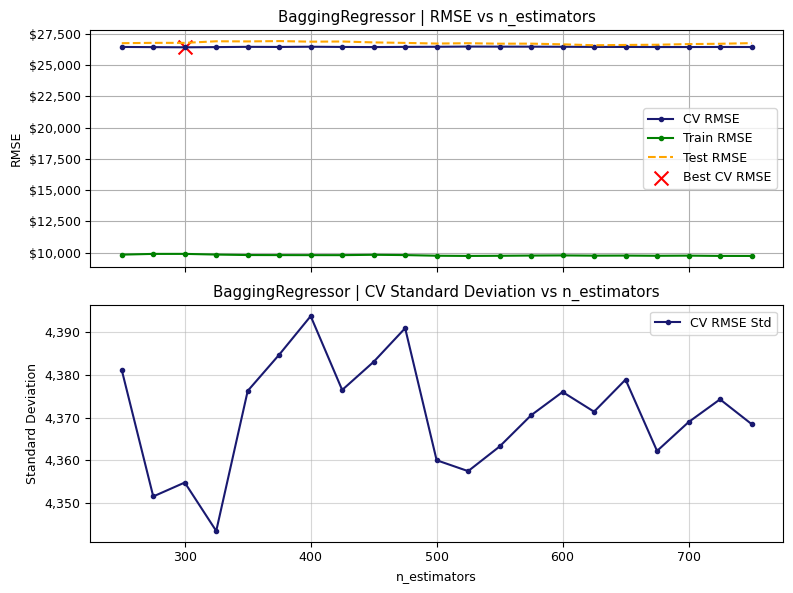

Execute successfully at: 2025-03-15 12:55:12
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=12, tm_min=55, tm_sec=12, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 300, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'Test_Param': 'n_estimators', 'Model': 'BaggingRegressor', '(R)MSE_found': 26429.974, 'cv_repeats': 2, 'test_(R)MSE': 26783.192, 'execution_time': '00:07:00', 'timestamp': '2025-03-15 12:55:12'}


{'n_estimators': 300,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42,
 'Test_Param': 'n_estimators',
 'Model': 'BaggingRegressor',
 '(R)MSE_found': 26429.974,
 'cv_repeats': 2,
 'test_(R)MSE': 26783.192,
 'execution_time': '00:07:00',
 'timestamp': '2025-03-15 12:55:12'}

In [659]:

best_params_estimators_1a = sweep_parameter(
    model           = model_1,
    Parameters      = Parameters_BT_1a,
    param           = 'n_estimators',
    parameter_list  = get_parameter_list('n_estimators'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Bagging['cv_repeats']
)

best_params_estimators_1a

#### 1a.2 max_samples

  *Specifies the number (or fraction) of samples to draw from the training set for each base estimator. This is crucial for controlling the diversity of the estimators and can directly affect bias and variance.*

In [660]:
#### Strip best_params_estimators_1a of any keys that are not valid parameters for the model,
#  but retain optimal value for n_estimators from previous test ####

Parameters_BT_1a = update_clean_model_params(model_1, best_params_estimators_1a.copy())
Parameters_BT_1a 

{'n_estimators': 300,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42}

Running BaggingRegressor with max_samples sweep...




Sweeping max_samples:  33%|███▎      | 1/3 [00:11<00:23, 11.88s/it]

max_samples = 0.9: CV MSE = 26,546.557, Train MSE = 10,824.177, Test MSE = 26,926.747



Sweeping max_samples:  67%|██████▋   | 2/3 [00:24<00:12, 12.19s/it]

max_samples = 0.95: CV MSE = 26,465.802, Train MSE = 10,439.084, Test MSE = 26,600.006



Sweeping max_samples: 100%|██████████| 3/3 [00:36<00:00, 12.21s/it]

max_samples = 1.0: CV MSE = 26,429.974, Train MSE = 9,893.097, Test MSE = 26,783.192


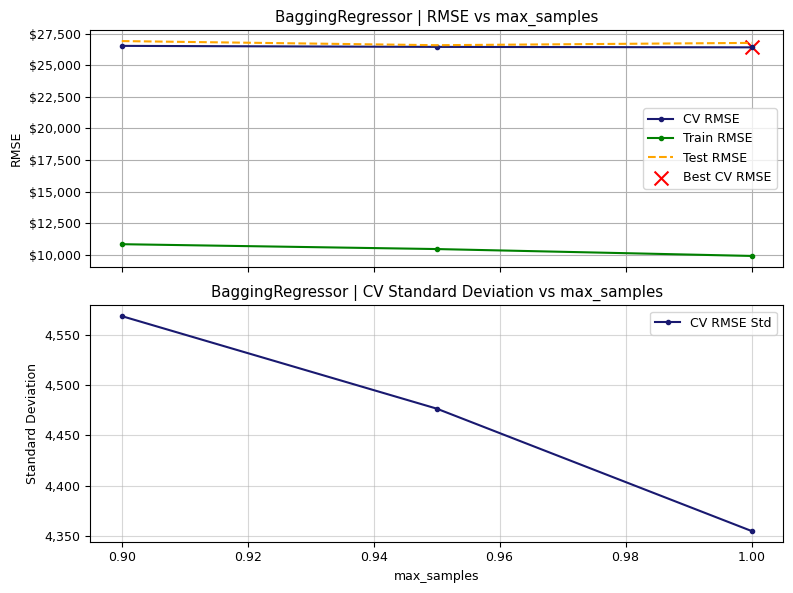

Execute successfully at: 2025-03-15 12:57:19
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=12, tm_min=57, tm_sec=19, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 300, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'Test_Param': 'max_samples', 'Model': 'BaggingRegressor', '(R)MSE_found': 26429.974, 'cv_repeats': 2, 'test_(R)MSE': 26783.192, 'execution_time': '00:00:36', 'timestamp': '2025-03-15 12:57:19'}


{'n_estimators': 300,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42,
 'Test_Param': 'max_samples',
 'Model': 'BaggingRegressor',
 '(R)MSE_found': 26429.974,
 'cv_repeats': 2,
 'test_(R)MSE': 26783.192,
 'execution_time': '00:00:36',
 'timestamp': '2025-03-15 12:57:19'}

In [661]:
best_params_max_samples_1a = sweep_parameter(
    model           = model_1,
    Parameters      = Parameters_BT_1a,
    param           = 'max_samples',
    parameter_list  = get_parameter_list('max_samples'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Bagging['cv_repeats']
)

best_params_max_samples_1a

In [674]:
Parameters_BT_1a = update_clean_model_params(model_1, best_params_max_samples_1a.copy())
Parameters_BT_1a 

{'n_estimators': 300,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42}

#### 1a.3 max_features

 *Specifies the number (or fraction) of features to consider when training each base estimator. Adjusting this parameter can help manage overfitting by limiting the complexity of each individual estimator.*

Running BaggingRegressor with max_features sweep...




Sweeping max_features:   2%|▏         | 1/53 [00:04<03:44,  4.32s/it]

max_features = 20: CV MSE = 26,227.463, Train MSE = 9,777.847, Test MSE = 27,390.956



Sweeping max_features:   4%|▍         | 2/53 [00:08<03:44,  4.40s/it]

max_features = 21: CV MSE = 26,131.160, Train MSE = 9,641.066, Test MSE = 26,926.842



Sweeping max_features:   6%|▌         | 3/53 [00:13<03:45,  4.51s/it]

max_features = 22: CV MSE = 26,106.888, Train MSE = 9,665.288, Test MSE = 26,842.202



Sweeping max_features:   8%|▊         | 4/53 [00:18<03:44,  4.59s/it]

max_features = 23: CV MSE = 26,097.702, Train MSE = 9,592.092, Test MSE = 26,811.174



Sweeping max_features:   9%|▉         | 5/53 [00:22<03:41,  4.62s/it]

max_features = 24: CV MSE = 25,949.653, Train MSE = 9,583.217, Test MSE = 26,577.230



Sweeping max_features:  11%|█▏        | 6/53 [00:28<03:46,  4.83s/it]

max_features = 25: CV MSE = 25,905.912, Train MSE = 9,609.676, Test MSE = 26,518.873



Sweeping max_features:  13%|█▎        | 7/53 [00:33<03:45,  4.90s/it]

max_features = 26: CV MSE = 25,715.875, Train MSE = 9,590.282, Test MSE = 26,424.956



Sweeping max_features:  15%|█▌        | 8/53 [00:38<03:43,  4.98s/it]

max_features = 27: CV MSE = 25,799.988, Train MSE = 9,574.779, Test MSE = 26,326.730



Sweeping max_features:  17%|█▋        | 9/53 [00:43<03:42,  5.06s/it]

max_features = 28: CV MSE = 25,694.177, Train MSE = 9,533.541, Test MSE = 25,964.466



Sweeping max_features:  19%|█▉        | 10/53 [00:48<03:42,  5.18s/it]

max_features = 29: CV MSE = 25,714.393, Train MSE = 9,551.207, Test MSE = 26,148.088



Sweeping max_features:  21%|██        | 11/53 [00:54<03:43,  5.33s/it]

max_features = 30: CV MSE = 25,738.812, Train MSE = 9,566.875, Test MSE = 26,077.853



Sweeping max_features:  23%|██▎       | 12/53 [01:00<03:44,  5.47s/it]

max_features = 31: CV MSE = 25,752.313, Train MSE = 9,568.235, Test MSE = 26,190.158



Sweeping max_features:  25%|██▍       | 13/53 [01:06<03:43,  5.59s/it]

max_features = 32: CV MSE = 25,769.689, Train MSE = 9,446.668, Test MSE = 26,395.116



Sweeping max_features:  26%|██▋       | 14/53 [01:12<03:43,  5.74s/it]

max_features = 33: CV MSE = 25,617.515, Train MSE = 9,536.261, Test MSE = 26,118.591



Sweeping max_features:  28%|██▊       | 15/53 [01:19<03:50,  6.05s/it]

max_features = 34: CV MSE = 25,737.076, Train MSE = 9,554.719, Test MSE = 26,276.734



Sweeping max_features:  30%|███       | 16/53 [01:25<03:49,  6.20s/it]

max_features = 35: CV MSE = 25,726.737, Train MSE = 9,555.540, Test MSE = 26,070.105



Sweeping max_features:  32%|███▏      | 17/53 [01:32<03:49,  6.38s/it]

max_features = 36: CV MSE = 25,697.085, Train MSE = 9,506.373, Test MSE = 26,084.415



Sweeping max_features:  34%|███▍      | 18/53 [01:40<03:56,  6.77s/it]

max_features = 37: CV MSE = 25,729.896, Train MSE = 9,568.074, Test MSE = 26,324.793



Sweeping max_features:  36%|███▌      | 19/53 [01:47<03:51,  6.81s/it]

max_features = 38: CV MSE = 25,671.585, Train MSE = 9,571.848, Test MSE = 26,197.036



Sweeping max_features:  38%|███▊      | 20/53 [01:54<03:47,  6.90s/it]

max_features = 39: CV MSE = 25,701.385, Train MSE = 9,562.522, Test MSE = 26,466.072



Sweeping max_features:  40%|███▉      | 21/53 [02:01<03:42,  6.96s/it]

max_features = 40: CV MSE = 25,617.400, Train MSE = 9,598.130, Test MSE = 26,262.149



Sweeping max_features:  42%|████▏     | 22/53 [02:08<03:38,  7.06s/it]

max_features = 41: CV MSE = 25,773.508, Train MSE = 9,512.499, Test MSE = 26,338.096



Sweeping max_features:  43%|████▎     | 23/53 [02:16<03:39,  7.32s/it]

max_features = 42: CV MSE = 25,703.481, Train MSE = 9,575.162, Test MSE = 26,314.094



Sweeping max_features:  45%|████▌     | 24/53 [02:24<03:36,  7.46s/it]

max_features = 43: CV MSE = 25,748.268, Train MSE = 9,594.979, Test MSE = 26,098.457



Sweeping max_features:  47%|████▋     | 25/53 [02:32<03:33,  7.64s/it]

max_features = 44: CV MSE = 25,775.772, Train MSE = 9,452.327, Test MSE = 26,027.067



Sweeping max_features:  49%|████▉     | 26/53 [02:40<03:29,  7.75s/it]

max_features = 45: CV MSE = 25,734.440, Train MSE = 9,510.393, Test MSE = 26,157.145



Sweeping max_features:  51%|█████     | 27/53 [02:48<03:27,  8.00s/it]

max_features = 46: CV MSE = 25,773.435, Train MSE = 9,449.770, Test MSE = 26,254.149



Sweeping max_features:  53%|█████▎    | 28/53 [02:57<03:22,  8.10s/it]

max_features = 47: CV MSE = 25,805.720, Train MSE = 9,541.985, Test MSE = 26,383.602



Sweeping max_features:  55%|█████▍    | 29/53 [03:05<03:16,  8.19s/it]

max_features = 48: CV MSE = 25,745.457, Train MSE = 9,496.988, Test MSE = 26,594.258



Sweeping max_features:  57%|█████▋    | 30/53 [03:14<03:13,  8.39s/it]

max_features = 49: CV MSE = 25,850.202, Train MSE = 9,532.454, Test MSE = 26,668.420



Sweeping max_features:  58%|█████▊    | 31/53 [03:23<03:08,  8.57s/it]

max_features = 50: CV MSE = 25,736.009, Train MSE = 9,595.508, Test MSE = 26,646.234



Sweeping max_features:  60%|██████    | 32/53 [03:32<03:04,  8.77s/it]

max_features = 51: CV MSE = 25,857.862, Train MSE = 9,605.025, Test MSE = 26,530.583



Sweeping max_features:  62%|██████▏   | 33/53 [03:42<03:02,  9.15s/it]

max_features = 52: CV MSE = 25,824.119, Train MSE = 9,574.617, Test MSE = 26,608.544



Sweeping max_features:  64%|██████▍   | 34/53 [03:52<02:58,  9.39s/it]

max_features = 53: CV MSE = 25,841.814, Train MSE = 9,571.401, Test MSE = 26,362.516



Sweeping max_features:  66%|██████▌   | 35/53 [04:03<02:55,  9.75s/it]

max_features = 54: CV MSE = 25,873.068, Train MSE = 9,657.802, Test MSE = 26,556.338



Sweeping max_features:  68%|██████▊   | 36/53 [04:14<02:54, 10.28s/it]

max_features = 55: CV MSE = 25,886.342, Train MSE = 9,645.319, Test MSE = 26,527.946



Sweeping max_features:  70%|██████▉   | 37/53 [04:25<02:46, 10.40s/it]

max_features = 56: CV MSE = 25,939.450, Train MSE = 9,743.185, Test MSE = 26,737.365



Sweeping max_features:  72%|███████▏  | 38/53 [04:36<02:39, 10.61s/it]

max_features = 57: CV MSE = 25,916.053, Train MSE = 9,664.545, Test MSE = 26,458.072



Sweeping max_features:  74%|███████▎  | 39/53 [04:47<02:31, 10.82s/it]

max_features = 58: CV MSE = 25,941.766, Train MSE = 9,631.749, Test MSE = 26,605.350



Sweeping max_features:  75%|███████▌  | 40/53 [04:59<02:24, 11.13s/it]

max_features = 59: CV MSE = 25,964.615, Train MSE = 9,627.399, Test MSE = 26,894.628



Sweeping max_features:  77%|███████▋  | 41/53 [05:11<02:14, 11.23s/it]

max_features = 60: CV MSE = 25,909.523, Train MSE = 9,765.132, Test MSE = 26,678.318



Sweeping max_features:  79%|███████▉  | 42/53 [05:22<02:05, 11.37s/it]

max_features = 61: CV MSE = 25,942.061, Train MSE = 9,756.146, Test MSE = 26,713.028



Sweeping max_features:  81%|████████  | 43/53 [05:36<01:59, 11.90s/it]

max_features = 62: CV MSE = 25,985.450, Train MSE = 9,837.279, Test MSE = 27,031.122



Sweeping max_features:  83%|████████▎ | 44/53 [05:48<01:48, 12.09s/it]

max_features = 63: CV MSE = 26,127.519, Train MSE = 9,776.951, Test MSE = 26,933.479



Sweeping max_features:  85%|████████▍ | 45/53 [06:01<01:38, 12.26s/it]

max_features = 64: CV MSE = 26,094.189, Train MSE = 9,788.914, Test MSE = 27,008.859



Sweeping max_features:  87%|████████▋ | 46/53 [06:13<01:25, 12.24s/it]

max_features = 65: CV MSE = 26,220.739, Train MSE = 9,727.688, Test MSE = 27,004.861



Sweeping max_features:  89%|████████▊ | 47/53 [06:25<01:13, 12.23s/it]

max_features = 66: CV MSE = 26,215.178, Train MSE = 9,789.441, Test MSE = 26,816.935



Sweeping max_features:  91%|█████████ | 48/53 [06:37<00:59, 12.00s/it]

max_features = 67: CV MSE = 26,301.990, Train MSE = 9,892.226, Test MSE = 26,941.665



Sweeping max_features:  92%|█████████▏| 49/53 [06:48<00:47, 11.93s/it]

max_features = 68: CV MSE = 26,380.970, Train MSE = 9,836.295, Test MSE = 26,957.426



Sweeping max_features:  94%|█████████▍| 50/53 [07:00<00:35, 11.98s/it]

max_features = 69: CV MSE = 26,422.684, Train MSE = 9,883.605, Test MSE = 26,950.242



Sweeping max_features:  96%|█████████▌| 51/53 [07:13<00:24, 12.10s/it]

max_features = 70: CV MSE = 26,355.867, Train MSE = 9,899.500, Test MSE = 26,688.468



Sweeping max_features:  98%|█████████▊| 52/53 [07:25<00:12, 12.15s/it]

max_features = 71: CV MSE = 26,391.809, Train MSE = 9,843.250, Test MSE = 26,937.323



Sweeping max_features: 100%|██████████| 53/53 [07:37<00:00,  8.63s/it]

max_features = 72: CV MSE = 26,491.061, Train MSE = 9,916.354, Test MSE = 26,769.188


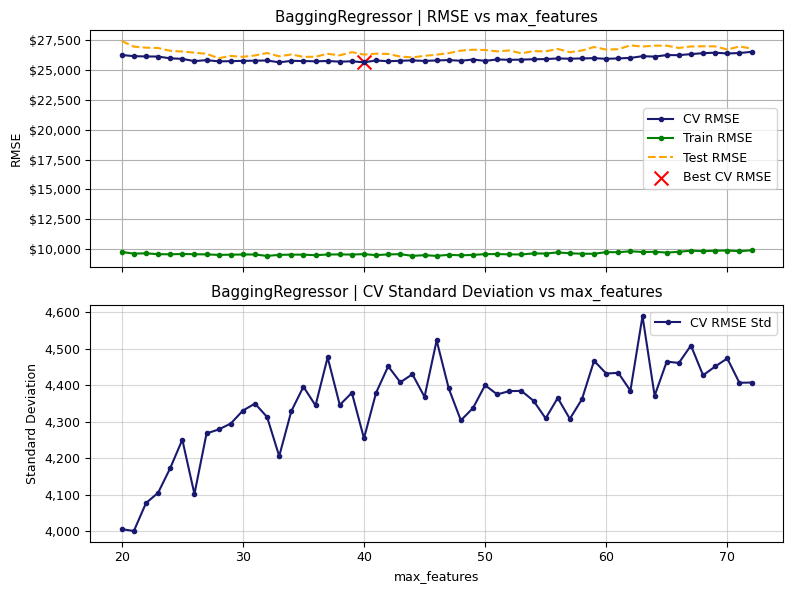

Execute successfully at: 2025-03-15 13:06:21
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=13, tm_min=6, tm_sec=21, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 300, 'max_samples': 1.0, 'max_features': 40, 'bootstrap': True, 'random_state': 42, 'Test_Param': 'max_features', 'Model': 'BaggingRegressor', '(R)MSE_found': 25617.4, 'cv_repeats': 2, 'test_(R)MSE': 26262.149, 'execution_time': '00:07:37', 'timestamp': '2025-03-15 13:06:21'}


{'n_estimators': 300,
 'max_samples': 1.0,
 'max_features': 40,
 'bootstrap': True,
 'random_state': 42,
 'Test_Param': 'max_features',
 'Model': 'BaggingRegressor',
 '(R)MSE_found': 25617.4,
 'cv_repeats': 2,
 'test_(R)MSE': 26262.149,
 'execution_time': '00:07:37',
 'timestamp': '2025-03-15 13:06:21'}

In [675]:
best_params_max_features_1a = sweep_parameter(
    model           = model_1,
    Parameters      = Parameters_BT_1a,
    param           = 'max_features',
    parameter_list  = get_parameter_list('max_features',None, X_train),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Bagging['cv_repeats']
)

best_params_max_features_1a

In [677]:
Parameters_BT_1a = update_clean_model_params(model_1, best_params_max_features_1a.copy())
Parameters_BT_1a 

{'n_estimators': 300,
 'max_samples': 1.0,
 'max_features': 40,
 'bootstrap': True,
 'random_state': 42}

#### 1a.4 bootstrap

*Indicates whether samples are drawn with replacement. Bootstrap sampling introduces randomness into the training process, leading to more diverse estimators and often improved ensemble performance.*

Running BaggingRegressor with bootstrap sweep...




Sweeping bootstrap:  50%|█████     | 1/2 [00:07<00:07,  7.52s/it]

bootstrap = True: CV MSE = 25,617.400, Train MSE = 9,598.130, Test MSE = 26,262.149



Sweeping bootstrap: 100%|██████████| 2/2 [00:19<00:00,  9.65s/it]

bootstrap = False: CV MSE = 25,230.911, Train MSE = 68.706, Test MSE = 25,758.028


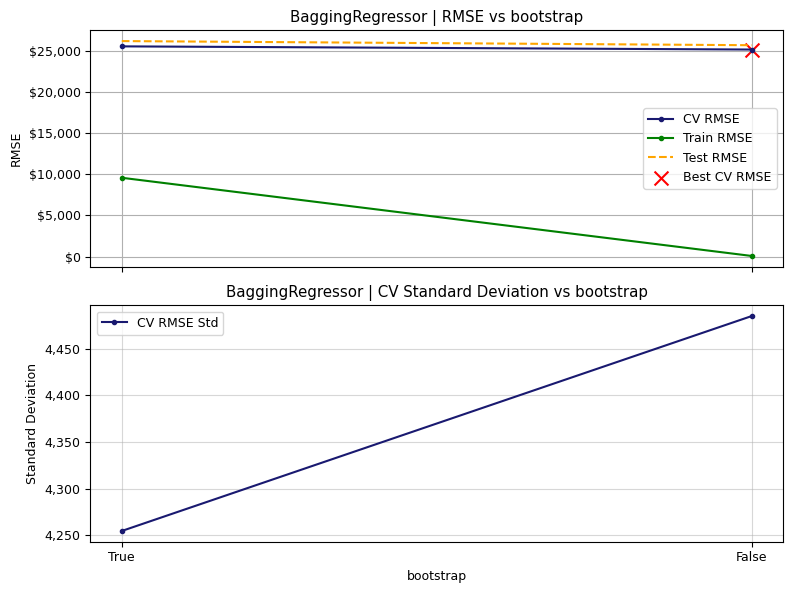

Execute successfully at: 2025-03-15 13:08:49
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=13, tm_min=8, tm_sec=49, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 300, 'max_samples': 1.0, 'max_features': 40, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'bootstrap', 'Model': 'BaggingRegressor', '(R)MSE_found': 25230.911, 'cv_repeats': 2, 'test_(R)MSE': 25758.028, 'execution_time': '00:00:19', 'timestamp': '2025-03-15 13:08:49'}
{'n_estimators': 300, 'max_samples': 1.0, 'max_features': 40, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'bootstrap', 'Model': 'BaggingRegressor', '(R)MSE_found': 25230.911, 'cv_repeats': 2, 'test_(R)MSE': 25758.028, 'execution_time': '00:00:19', 'timestamp': '2025-03-15 13:08:49'}


{'n_estimators': 300,
 'max_samples': 1.0,
 'max_features': 40,
 'bootstrap': False,
 'random_state': 42,
 'Test_Param': 'bootstrap',
 'Model': 'BaggingRegressor',
 '(R)MSE_found': 25230.911,
 'cv_repeats': 2,
 'test_(R)MSE': 25758.028,
 'execution_time': '00:00:19',
 'timestamp': '2025-03-15 13:08:49'}

In [678]:
# bootstrap_parameter_list = [True, False]

# Call the sweep_parameter function
best_params_bootstrap_1a = sweep_parameter(
    model           = model_1,
    Parameters      = Parameters_BT_1a,
    param           = 'bootstrap',
    parameter_list  = get_parameter_list('bootstrap'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Bagging['cv_repeats']
)
#'test_(R)MSE'
print(best_params_bootstrap_1a)
best_params_bootstrap_1a

In [679]:
Parameters_BT_1a = update_clean_model_params(model_1, best_params_bootstrap_1a.copy())
Parameters_BT_1a 

{'n_estimators': 300,
 'max_samples': 1.0,
 'max_features': 40,
 'bootstrap': False,
 'random_state': 42}

#### 1a. Summary

In [695]:
summary_df_1a              = pd.DataFrame([dict_baseline_1a, 
                                           best_params_estimators_1a, 
                                           best_params_max_samples_1a, 
                                           best_params_max_features_1a, 
                                           best_params_bootstrap_1a],
                                           columns = ensemble_df_columns['BaggingRegressor']).round(3)
summary_df_1a              = df_format_dropDuplicateRows(summary_df_1a)

summary_df_1a

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_samples,max_features,bootstrap,execution_time,timestamp
0,BaggingRegressor,Baseline_1a,2,27968.202,29310.360,10,1.0,1.0,True,0.594099,2025-03-15 13:12:00
1,BaggingRegressor,n_estimators,2,26429.974,26783.192,300,1.0,1.0,True,00:07:00,2025-03-15 12:55:12
2,BaggingRegressor,max_samples,2,26429.974,26783.192,300,1.0,1.0,True,00:00:36,2025-03-15 12:57:19
3,BaggingRegressor,max_features,2,25617.400,26262.149,300,1.0,40.0,True,00:07:37,2025-03-15 13:06:21
4,BaggingRegressor,bootstrap,2,25230.911,25758.028,300,1.0,40.0,False,00:00:19,2025-03-15 13:08:49


### Problem 1.A Graded Answer

In [696]:
# TODO:  Set the variable to best CV RMSE score found after Part A

a1a = summary_df_1a['(R)MSE_found'].min()                               # Just to get it to run without error; your answer here (remember to use the RMSE)         

print(f'a1a = ${a1a:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1a = $25,230.91


### **Part 1.B: Refine Parameters for Model Stability**  
After completing the first sweep, **repeat Part A as needed** to refine your model.  
- Your goal is to identify the parameter combination that minimizes the **CV MSE**.  
- **Final tuning goals:**
  - Adjust `n_estimators` with a **tolerance of 10**.
  - Adjust `max_samples` with a **tolerance of 0.1**.
  - Adjust `max_features` with a **tolerance of 1**.
- **Report your final results (including all final parameter choices, and convert MSE to RMSE in dollars when printing out)** and answer the graded question. 

In [697]:
# Define the parameters for the BaggingRegressor
Default_Parameters_Bagging_1b = {
    'n_estimators': 10,            # Number of base estimators in the ensemble
    'max_samples' : 1.0,           # Fraction of samples to draw for each base estimator
    'max_features': 1.0,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    '(R)MSE_found': float('inf'),   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
    'cv_repeats'  : 10,            # Number of repeats for cross-validation
}

#                                 Default_Parameters_Random_Forests['cv_repeats'] = 10

In [698]:
# Your code here -- Add as many code cells as necessary
Parameters_BT_1b = update_clean_model_params(model_1, Default_Parameters_Bagging_1b.copy())
print(Parameters_BT_1b)

{'n_estimators': 10, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42}


#### 1b.0 Baseline

In [699]:
Default_Parameters_Bagging_baseline = Default_Parameters_Bagging_1b.copy()
Default_Parameters_Bagging_baseline = update_clean_model_params(model_1, Default_Parameters_Bagging_baseline)

start = time.time()
# Run the baseline model
mean_cv_mse, std_cv_mse, train_mse, test_mse = run_model(model_1, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test, 
                                                         n_repeats  = Default_Parameters_Bagging_1b['cv_repeats'],
                                                         n_jobs     = -1,
                                                         exp_factor = 0.5,  # Square root of MSE
                                                         **Default_Parameters_Bagging_baseline
                                                        )

end                                 = time.time()
execution_time                      = format_hms(end - start)
timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))


# exp_factor = 0.5
dict_baseline_1b = {
    'Test_Param':              'Baseline_1b',
    'mean_CV_MSE':              mean_cv_mse,
    'std_CV_MSE':               std_cv_mse,
    'train_MSE':                train_mse,
    'test_(R)MSE':              test_mse,
    'cv_repeats':               Default_Parameters_Bagging_1b['cv_repeats'],
    '(R)MSE_found':             mean_cv_mse,
    'n_estimators':             Default_Parameters_Bagging_baseline['n_estimators'],
    'max_samples':              Default_Parameters_Bagging_baseline['max_samples'],
    'max_features':             Default_Parameters_Bagging_baseline['max_features'],
    'bootstrap':                Default_Parameters_Bagging_baseline['bootstrap'],
    'Model':                    model_1.__name__,
    'execution_time':           execution_time,
    'timestamp':                timestamp
    
}


print(f'Execution completed at: {timestamp}')
print("Baseline results for BaggingRegressor:\n", dict_baseline_1b)
dict_baseline_1b

Execution completed at: 2025-03-15 13:18:53
Baseline results for BaggingRegressor:
 {'Test_Param': 'Baseline_1b', 'mean_CV_MSE': 28231.468, 'std_CV_MSE': 3731.603, 'train_MSE': 12796.401, 'test_(R)MSE': 29310.36, 'cv_repeats': 10, '(R)MSE_found': 28231.468, 'n_estimators': 10, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'Model': 'BaggingRegressor', 'execution_time': '00:00:01', 'timestamp': '2025-03-15 13:18:53'}


{'Test_Param': 'Baseline_1b',
 'mean_CV_MSE': 28231.468,
 'std_CV_MSE': 3731.603,
 'train_MSE': 12796.401,
 'test_(R)MSE': 29310.36,
 'cv_repeats': 10,
 '(R)MSE_found': 28231.468,
 'n_estimators': 10,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'Model': 'BaggingRegressor',
 'execution_time': '00:00:01',
 'timestamp': '2025-03-15 13:18:53'}

#### 1b.1 n_estimators

Running BaggingRegressor with n_estimators sweep...




Sweeping n_estimators:   7%|▋         | 1/14 [00:26<05:50, 26.94s/it]

n_estimators = 220: CV MSE = 26,609.628, Train MSE = 9,879.477, Test MSE = 26,948.480



Sweeping n_estimators:  14%|█▍        | 2/14 [00:55<05:37, 28.15s/it]

n_estimators = 230: CV MSE = 26,623.290, Train MSE = 9,901.738, Test MSE = 26,917.779



Sweeping n_estimators:  21%|██▏       | 3/14 [01:25<05:17, 28.90s/it]

n_estimators = 240: CV MSE = 26,625.391, Train MSE = 9,862.385, Test MSE = 26,798.867



Sweeping n_estimators:  29%|██▊       | 4/14 [01:56<04:54, 29.47s/it]

n_estimators = 250: CV MSE = 26,632.050, Train MSE = 9,832.515, Test MSE = 26,758.366



Sweeping n_estimators:  36%|███▌      | 5/14 [02:27<04:32, 30.25s/it]

n_estimators = 260: CV MSE = 26,622.544, Train MSE = 9,866.139, Test MSE = 26,779.747



Sweeping n_estimators:  43%|████▎     | 6/14 [03:00<04:09, 31.19s/it]

n_estimators = 270: CV MSE = 26,613.260, Train MSE = 9,873.410, Test MSE = 26,752.053



Sweeping n_estimators:  50%|█████     | 7/14 [03:34<03:44, 32.01s/it]

n_estimators = 280: CV MSE = 26,608.595, Train MSE = 9,899.299, Test MSE = 26,791.726



Sweeping n_estimators:  57%|█████▋    | 8/14 [04:10<03:18, 33.16s/it]

n_estimators = 290: CV MSE = 26,602.595, Train MSE = 9,897.979, Test MSE = 26,757.883



Sweeping n_estimators:  64%|██████▍   | 9/14 [04:49<02:55, 35.00s/it]

n_estimators = 300: CV MSE = 26,605.964, Train MSE = 9,893.097, Test MSE = 26,783.192



Sweeping n_estimators:  71%|███████▏  | 10/14 [05:29<02:26, 36.66s/it]

n_estimators = 310: CV MSE = 26,609.449, Train MSE = 9,917.190, Test MSE = 26,844.041



Sweeping n_estimators:  79%|███████▊  | 11/14 [06:11<01:54, 38.32s/it]

n_estimators = 320: CV MSE = 26,614.724, Train MSE = 9,865.779, Test MSE = 26,927.868



Sweeping n_estimators:  86%|████████▌ | 12/14 [06:54<01:19, 39.80s/it]

n_estimators = 330: CV MSE = 26,621.559, Train MSE = 9,812.623, Test MSE = 26,927.359



Sweeping n_estimators:  93%|█████████▎| 13/14 [07:35<00:40, 40.16s/it]

n_estimators = 340: CV MSE = 26,627.192, Train MSE = 9,820.755, Test MSE = 26,937.405



Sweeping n_estimators: 100%|██████████| 14/14 [08:17<00:00, 35.53s/it]

n_estimators = 350: CV MSE = 26,620.506, Train MSE = 9,800.364, Test MSE = 26,901.153


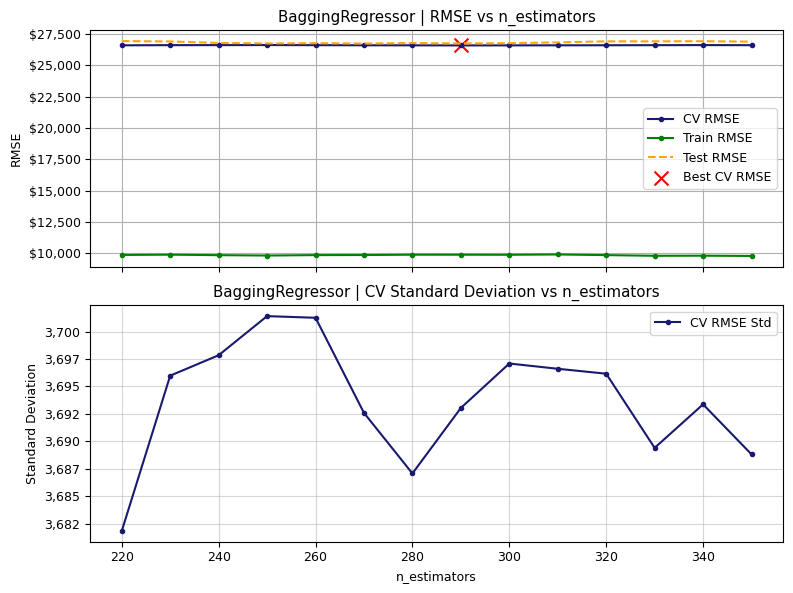

Execute successfully at: 2025-03-15 13:28:18
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=13, tm_min=28, tm_sec=18, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 290, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'Test_Param': 'n_estimators', 'Model': 'BaggingRegressor', '(R)MSE_found': 26602.595, 'cv_repeats': 10, 'test_(R)MSE': 26757.883, 'execution_time': '00:08:17', 'timestamp': '2025-03-15 13:28:18'}


{'n_estimators': 290,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42,
 'Test_Param': 'n_estimators',
 'Model': 'BaggingRegressor',
 '(R)MSE_found': 26602.595,
 'cv_repeats': 10,
 'test_(R)MSE': 26757.883,
 'execution_time': '00:08:17',
 'timestamp': '2025-03-15 13:28:18'}

In [700]:
best_params_estimators_1b = sweep_parameter(
    model           = model_1,
    Parameters      = Parameters_BT_1b,
    param           = 'n_estimators',
    parameter_list  = get_parameter_list('n_estimators', list(np.arange(220, 351, 10))),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Bagging_1b['cv_repeats']
)

best_params_estimators_1b

In [701]:
Parameters_BT_1b = update_clean_model_params(model_1, best_params_estimators_1b.copy())
Parameters_BT_1b 

{'n_estimators': 290,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42}

#### 1b.2 max_samples

Running BaggingRegressor with max_samples sweep...




Sweeping max_samples:  33%|███▎      | 1/3 [00:38<01:16, 38.24s/it]

max_samples = 0.9: CV MSE = 26,689.268, Train MSE = 10,835.501, Test MSE = 26,909.337



Sweeping max_samples:  67%|██████▋   | 2/3 [01:16<00:38, 38.47s/it]

max_samples = 0.95: CV MSE = 26,689.077, Train MSE = 10,449.709, Test MSE = 26,571.396



Sweeping max_samples: 100%|██████████| 3/3 [01:55<00:00, 38.38s/it]

max_samples = 1.0: CV MSE = 26,602.595, Train MSE = 9,897.979, Test MSE = 26,757.883


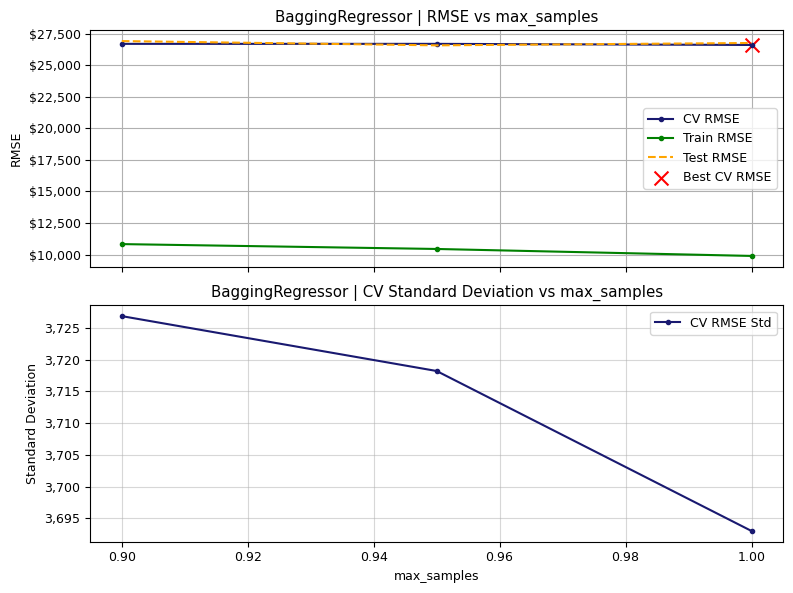

Execute successfully at: 2025-03-15 13:40:24
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=13, tm_min=40, tm_sec=24, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 290, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'Test_Param': 'max_samples', 'Model': 'BaggingRegressor', '(R)MSE_found': 26602.595, 'cv_repeats': 10, 'test_(R)MSE': 26757.883, 'execution_time': '00:01:55', 'timestamp': '2025-03-15 13:40:24'}


{'n_estimators': 290,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42,
 'Test_Param': 'max_samples',
 'Model': 'BaggingRegressor',
 '(R)MSE_found': 26602.595,
 'cv_repeats': 10,
 'test_(R)MSE': 26757.883,
 'execution_time': '00:01:55',
 'timestamp': '2025-03-15 13:40:24'}

In [702]:
best_params_max_samples_1b = sweep_parameter(
    model           = model_1,
    Parameters      = Parameters_BT_1b,
    param           = 'max_samples',
    parameter_list  = get_parameter_list('max_samples'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Bagging_1b['cv_repeats']
)

best_params_max_samples_1b

In [703]:
Parameters_BT_1b = update_clean_model_params(model_1, best_params_max_samples_1b.copy())
Parameters_BT_1b 

{'n_estimators': 290,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42}

#### 1b.3 max_features

Running BaggingRegressor with max_features sweep...




Sweeping max_features:   2%|▏         | 1/53 [00:15<13:03, 15.07s/it]

max_features = 20: CV MSE = 26,532.504, Train MSE = 9,808.364, Test MSE = 27,409.614



Sweeping max_features:   4%|▍         | 2/53 [00:29<12:25, 14.61s/it]

max_features = 21: CV MSE = 26,415.707, Train MSE = 9,694.713, Test MSE = 27,001.642



Sweeping max_features:   6%|▌         | 3/53 [00:43<11:52, 14.25s/it]

max_features = 22: CV MSE = 26,314.750, Train MSE = 9,690.996, Test MSE = 26,815.717



Sweeping max_features:   8%|▊         | 4/53 [00:57<11:36, 14.21s/it]

max_features = 23: CV MSE = 26,285.102, Train MSE = 9,613.685, Test MSE = 26,811.410



Sweeping max_features:   9%|▉         | 5/53 [01:12<11:33, 14.45s/it]

max_features = 24: CV MSE = 26,128.021, Train MSE = 9,597.071, Test MSE = 26,548.812



Sweeping max_features:  11%|█▏        | 6/53 [01:28<11:42, 14.94s/it]

max_features = 25: CV MSE = 26,030.187, Train MSE = 9,622.421, Test MSE = 26,507.835



Sweeping max_features:  13%|█▎        | 7/53 [01:47<12:28, 16.28s/it]

max_features = 26: CV MSE = 25,902.476, Train MSE = 9,611.529, Test MSE = 26,427.367



Sweeping max_features:  15%|█▌        | 8/53 [02:04<12:32, 16.71s/it]

max_features = 27: CV MSE = 25,898.938, Train MSE = 9,583.875, Test MSE = 26,338.322



Sweeping max_features:  17%|█▋        | 9/53 [02:21<12:21, 16.86s/it]

max_features = 28: CV MSE = 25,831.783, Train MSE = 9,548.683, Test MSE = 25,981.929



Sweeping max_features:  19%|█▉        | 10/53 [02:39<12:09, 16.96s/it]

max_features = 29: CV MSE = 25,812.741, Train MSE = 9,566.174, Test MSE = 26,126.764



Sweeping max_features:  21%|██        | 11/53 [02:56<11:54, 17.01s/it]

max_features = 30: CV MSE = 25,804.856, Train MSE = 9,587.079, Test MSE = 26,060.348



Sweeping max_features:  23%|██▎       | 12/53 [03:13<11:37, 17.00s/it]

max_features = 31: CV MSE = 25,818.219, Train MSE = 9,577.213, Test MSE = 26,179.773



Sweeping max_features:  25%|██▍       | 13/53 [03:30<11:28, 17.22s/it]

max_features = 32: CV MSE = 25,781.651, Train MSE = 9,471.761, Test MSE = 26,378.230



Sweeping max_features:  26%|██▋       | 14/53 [03:48<11:21, 17.46s/it]

max_features = 33: CV MSE = 25,743.670, Train MSE = 9,568.155, Test MSE = 26,079.069



Sweeping max_features:  28%|██▊       | 15/53 [04:07<11:13, 17.73s/it]

max_features = 34: CV MSE = 25,767.755, Train MSE = 9,563.265, Test MSE = 26,243.173



Sweeping max_features:  30%|███       | 16/53 [04:26<11:15, 18.27s/it]

max_features = 35: CV MSE = 25,763.687, Train MSE = 9,586.394, Test MSE = 26,037.688



Sweeping max_features:  32%|███▏      | 17/53 [04:46<11:10, 18.61s/it]

max_features = 36: CV MSE = 25,708.815, Train MSE = 9,522.312, Test MSE = 26,071.784



Sweeping max_features:  34%|███▍      | 18/53 [05:05<11:01, 18.91s/it]

max_features = 37: CV MSE = 25,698.996, Train MSE = 9,591.856, Test MSE = 26,293.259



Sweeping max_features:  36%|███▌      | 19/53 [05:26<10:56, 19.30s/it]

max_features = 38: CV MSE = 25,706.573, Train MSE = 9,588.789, Test MSE = 26,178.418



Sweeping max_features:  38%|███▊      | 20/53 [05:46<10:51, 19.73s/it]

max_features = 39: CV MSE = 25,714.608, Train MSE = 9,572.245, Test MSE = 26,505.383



Sweeping max_features:  40%|███▉      | 21/53 [06:08<10:46, 20.20s/it]

max_features = 40: CV MSE = 25,650.685, Train MSE = 9,614.682, Test MSE = 26,236.333



Sweeping max_features:  42%|████▏     | 22/53 [06:29<10:40, 20.67s/it]

max_features = 41: CV MSE = 25,699.741, Train MSE = 9,539.536, Test MSE = 26,321.799



Sweeping max_features:  43%|████▎     | 23/53 [06:52<10:33, 21.12s/it]

max_features = 42: CV MSE = 25,710.001, Train MSE = 9,592.862, Test MSE = 26,283.202



Sweeping max_features:  45%|████▌     | 24/53 [07:15<10:32, 21.82s/it]

max_features = 43: CV MSE = 25,689.391, Train MSE = 9,623.140, Test MSE = 26,093.195



Sweeping max_features:  47%|████▋     | 25/53 [07:38<10:24, 22.32s/it]

max_features = 44: CV MSE = 25,741.312, Train MSE = 9,476.546, Test MSE = 26,012.036



Sweeping max_features:  49%|████▉     | 26/53 [08:02<10:08, 22.55s/it]

max_features = 45: CV MSE = 25,742.793, Train MSE = 9,519.135, Test MSE = 26,182.465



Sweeping max_features:  51%|█████     | 27/53 [08:27<10:06, 23.33s/it]

max_features = 46: CV MSE = 25,774.130, Train MSE = 9,466.941, Test MSE = 26,237.412



Sweeping max_features:  53%|█████▎    | 28/53 [08:52<10:01, 24.06s/it]

max_features = 47: CV MSE = 25,824.614, Train MSE = 9,572.735, Test MSE = 26,366.326



Sweeping max_features:  55%|█████▍    | 29/53 [09:20<10:03, 25.13s/it]

max_features = 48: CV MSE = 25,777.792, Train MSE = 9,521.068, Test MSE = 26,580.836



Sweeping max_features:  57%|█████▋    | 30/53 [09:48<09:55, 25.89s/it]

max_features = 49: CV MSE = 25,831.253, Train MSE = 9,544.802, Test MSE = 26,667.264



Sweeping max_features:  58%|█████▊    | 31/53 [10:16<09:42, 26.48s/it]

max_features = 50: CV MSE = 25,837.809, Train MSE = 9,613.229, Test MSE = 26,622.478



Sweeping max_features:  60%|██████    | 32/53 [10:44<09:26, 26.96s/it]

max_features = 51: CV MSE = 25,869.407, Train MSE = 9,628.523, Test MSE = 26,546.046



Sweeping max_features:  62%|██████▏   | 33/53 [11:12<09:04, 27.23s/it]

max_features = 52: CV MSE = 25,912.369, Train MSE = 9,597.652, Test MSE = 26,586.595



Sweeping max_features:  64%|██████▍   | 34/53 [11:41<08:47, 27.78s/it]

max_features = 53: CV MSE = 25,966.012, Train MSE = 9,578.857, Test MSE = 26,307.081



Sweeping max_features:  66%|██████▌   | 35/53 [12:08<08:16, 27.61s/it]

max_features = 54: CV MSE = 25,963.222, Train MSE = 9,662.520, Test MSE = 26,545.076



Sweeping max_features:  68%|██████▊   | 36/53 [12:36<07:54, 27.90s/it]

max_features = 55: CV MSE = 26,007.637, Train MSE = 9,654.526, Test MSE = 26,505.969



Sweeping max_features:  70%|██████▉   | 37/53 [13:05<07:28, 28.05s/it]

max_features = 56: CV MSE = 25,996.974, Train MSE = 9,757.336, Test MSE = 26,718.951



Sweeping max_features:  72%|███████▏  | 38/53 [13:33<07:03, 28.23s/it]

max_features = 57: CV MSE = 26,013.420, Train MSE = 9,673.907, Test MSE = 26,444.468



Sweeping max_features:  74%|███████▎  | 39/53 [14:03<06:41, 28.70s/it]

max_features = 58: CV MSE = 26,005.639, Train MSE = 9,645.212, Test MSE = 26,601.333



Sweeping max_features:  75%|███████▌  | 40/53 [14:34<06:22, 29.40s/it]

max_features = 59: CV MSE = 26,058.682, Train MSE = 9,629.508, Test MSE = 26,845.954



Sweeping max_features:  77%|███████▋  | 41/53 [15:05<05:56, 29.67s/it]

max_features = 60: CV MSE = 26,100.853, Train MSE = 9,773.416, Test MSE = 26,639.145



Sweeping max_features:  79%|███████▉  | 42/53 [15:35<05:29, 29.99s/it]

max_features = 61: CV MSE = 26,157.233, Train MSE = 9,761.575, Test MSE = 26,658.535



Sweeping max_features:  81%|████████  | 43/53 [16:08<05:09, 30.90s/it]

max_features = 62: CV MSE = 26,149.598, Train MSE = 9,846.842, Test MSE = 26,995.148



Sweeping max_features:  83%|████████▎ | 44/53 [16:41<04:43, 31.50s/it]

max_features = 63: CV MSE = 26,209.901, Train MSE = 9,791.879, Test MSE = 26,908.507



Sweeping max_features:  85%|████████▍ | 45/53 [17:13<04:12, 31.56s/it]

max_features = 64: CV MSE = 26,239.231, Train MSE = 9,793.747, Test MSE = 27,001.466



Sweeping max_features:  87%|████████▋ | 46/53 [17:46<03:43, 31.91s/it]

max_features = 65: CV MSE = 26,296.949, Train MSE = 9,726.579, Test MSE = 26,970.436



Sweeping max_features:  89%|████████▊ | 47/53 [18:18<03:12, 32.16s/it]

max_features = 66: CV MSE = 26,363.067, Train MSE = 9,787.680, Test MSE = 26,780.798



Sweeping max_features:  91%|█████████ | 48/53 [18:52<02:43, 32.60s/it]

max_features = 67: CV MSE = 26,432.716, Train MSE = 9,899.403, Test MSE = 26,927.226



Sweeping max_features:  92%|█████████▏| 49/53 [19:26<02:11, 32.96s/it]

max_features = 68: CV MSE = 26,431.303, Train MSE = 9,838.773, Test MSE = 26,913.538



Sweeping max_features:  94%|█████████▍| 50/53 [20:00<01:39, 33.27s/it]

max_features = 69: CV MSE = 26,535.518, Train MSE = 9,890.960, Test MSE = 26,935.863



Sweeping max_features:  96%|█████████▌| 51/53 [20:36<01:08, 34.18s/it]

max_features = 70: CV MSE = 26,553.107, Train MSE = 9,907.204, Test MSE = 26,670.126



Sweeping max_features:  98%|█████████▊| 52/53 [21:16<00:35, 35.76s/it]

max_features = 71: CV MSE = 26,535.476, Train MSE = 9,851.585, Test MSE = 26,937.558



Sweeping max_features: 100%|██████████| 53/53 [21:57<00:00, 24.85s/it]

max_features = 72: CV MSE = 26,631.341, Train MSE = 9,917.026, Test MSE = 26,779.748


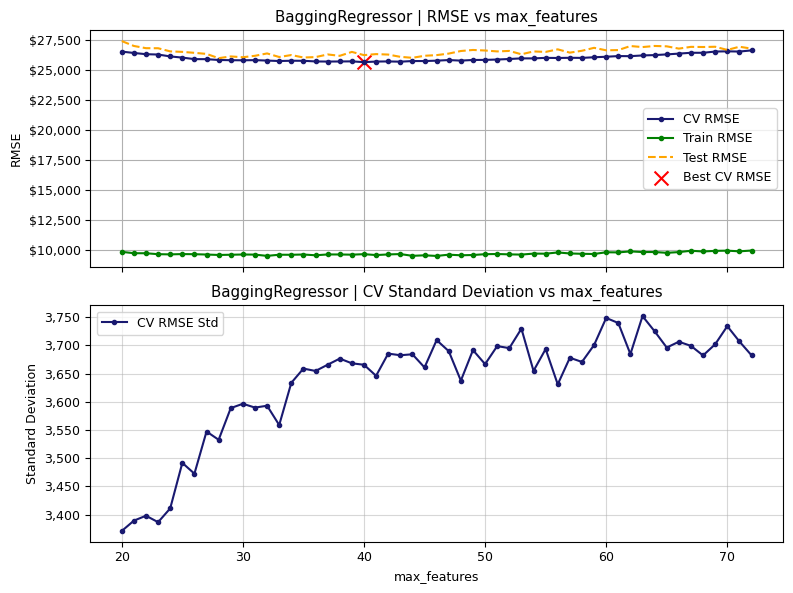

Execute successfully at: 2025-03-15 14:18:05
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=14, tm_min=18, tm_sec=5, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 290, 'max_samples': 1.0, 'max_features': 40, 'bootstrap': True, 'random_state': 42, 'Test_Param': 'max_features', 'Model': 'BaggingRegressor', '(R)MSE_found': 25650.685, 'cv_repeats': 10, 'test_(R)MSE': 26236.333, 'execution_time': '00:21:57', 'timestamp': '2025-03-15 14:18:05'}


{'n_estimators': 290,
 'max_samples': 1.0,
 'max_features': 40,
 'bootstrap': True,
 'random_state': 42,
 'Test_Param': 'max_features',
 'Model': 'BaggingRegressor',
 '(R)MSE_found': 25650.685,
 'cv_repeats': 10,
 'test_(R)MSE': 26236.333,
 'execution_time': '00:21:57',
 'timestamp': '2025-03-15 14:18:05'}

In [704]:
best_params_max_features_1b = sweep_parameter(
    model           = model_1,
    Parameters      = Parameters_BT_1b,
    param           = 'max_features',
    parameter_list  = get_parameter_list('max_features', None ,X_train),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Bagging_1b['cv_repeats']
)

best_params_max_features_1b

In [705]:
Parameters_BT_1b = update_clean_model_params(model_1, best_params_max_features_1b.copy())
Parameters_BT_1b

{'n_estimators': 290,
 'max_samples': 1.0,
 'max_features': 40,
 'bootstrap': True,
 'random_state': 42}

#### 1b.4 bootstrap

Running BaggingRegressor with bootstrap sweep...




Sweeping bootstrap:  50%|█████     | 1/2 [00:22<00:22, 22.46s/it]

bootstrap = True: CV MSE = 25,650.685, Train MSE = 9,614.682, Test MSE = 26,236.333



Sweeping bootstrap: 100%|██████████| 2/2 [01:00<00:00, 30.20s/it]

bootstrap = False: CV MSE = 25,152.423, Train MSE = 68.788, Test MSE = 25,737.937


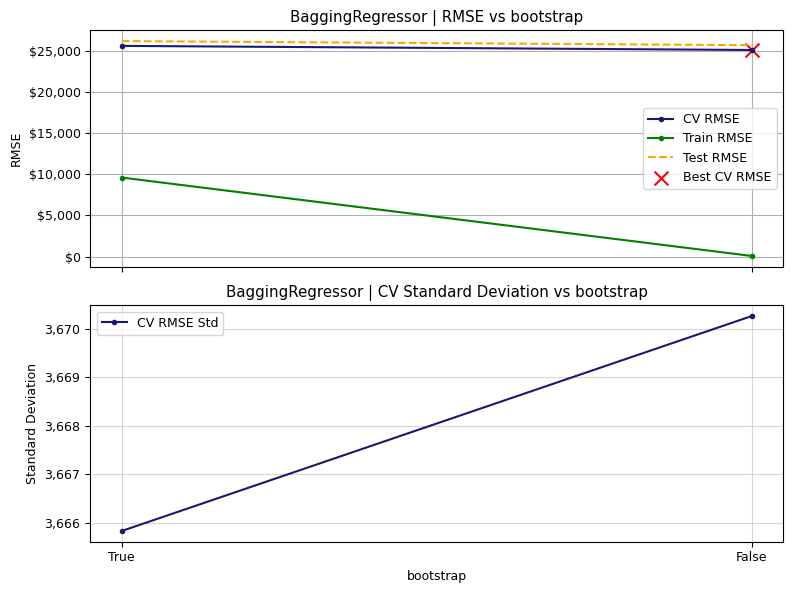

Execute successfully at: 2025-03-15 14:20:21
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=14, tm_min=20, tm_sec=21, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 290, 'max_samples': 1.0, 'max_features': 40, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'bootstrap', 'Model': 'BaggingRegressor', '(R)MSE_found': 25152.423, 'cv_repeats': 10, 'test_(R)MSE': 25737.937, 'execution_time': '00:01:00', 'timestamp': '2025-03-15 14:20:21'}
{'n_estimators': 290, 'max_samples': 1.0, 'max_features': 40, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'bootstrap', 'Model': 'BaggingRegressor', '(R)MSE_found': 25152.423, 'cv_repeats': 10, 'test_(R)MSE': 25737.937, 'execution_time': '00:01:00', 'timestamp': '2025-03-15 14:20:21'}


In [706]:

best_params_bootstrap_1b = sweep_parameter(
    model           = model_1,
    Parameters      = Parameters_BT_1b,
    param           = 'bootstrap',
    parameter_list  = get_parameter_list('bootstrap'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Bagging_1b['cv_repeats']
)

print(best_params_bootstrap_1b)

In [708]:
Parameters_BT_1b = update_clean_model_params(model_1, best_params_bootstrap_1b.copy())
Parameters_BT_1b

{'n_estimators': 290,
 'max_samples': 1.0,
 'max_features': 40,
 'bootstrap': False,
 'random_state': 42}

#### 1b. Summary

In [709]:
summary_df_1b = pd.DataFrame([dict_baseline_1b, 
                              best_params_estimators_1b, 
                              best_params_max_samples_1b, 
                              best_params_max_features_1b, 
                              best_params_bootstrap_1b],
                              columns = ensemble_df_columns['BaggingRegressor']).round(3)

summary_df_1b = df_format_dropDuplicateRows(summary_df_1b)

summary_df_1b

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_samples,max_features,bootstrap,execution_time,timestamp
0,BaggingRegressor,Baseline_1b,10,28231.468,29310.360,10,1.0,1.0,True,00:00:01,2025-03-15 13:18:53
1,BaggingRegressor,n_estimators,10,26602.595,26757.883,290,1.0,1.0,True,00:08:17,2025-03-15 13:28:18
2,BaggingRegressor,max_samples,10,26602.595,26757.883,290,1.0,1.0,True,00:01:55,2025-03-15 13:40:24
3,BaggingRegressor,max_features,10,25650.685,26236.333,290,1.0,40.0,True,00:21:57,2025-03-15 14:18:05
4,BaggingRegressor,bootstrap,10,25152.423,25737.937,290,1.0,40.0,False,00:01:00,2025-03-15 14:20:21


### Problem 1.B Graded Answer

In [710]:
# TODO:  Set the variable to best CV RMSE score found after Part B (it may not be different than Part A)

a1b = summary_df_1b['(R)MSE_found'].min()                              # Just to get it to run without error; your answer here (remember to use the RMSE)          

print(f'a1b = ${a1b:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1b = $25,152.42


### **Part 1.C: Use `GridSearchCV` for Exhaustive Search**  
Once you have completed your parameter sweeps in Part B, you will verify and perhaps even refine your results using exhaustive grid search (not random search). 
- In your results from Part B, identify **unstable parameter ranges** (review Problem 4 from Homework 06).
- Perform  **exhaustive grid searches** within appropriately restricted ranges using `GridSearchCV`.  
- **Print out the best result found by exhaustive search (including the final parameter choices, and convert MSE to RMSE in dollars)** and answer the graded question.

NOTE: Do *not* simply redo all of Parts A and B, and you should repeat your grid search runs using the techniques described in Appendix 4 until you are sure you have either verified your results_df from Part B or found a model with an even lower CV MSE score than you found in Part B.   

#### 1.C RandomizedSearchCV

 RandomizedSearch CV randomly selects a specified number of combinations from the provided parameter grid.

In [ ]:

# models      = [BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor]

model_1     = BaggingRegressor
param_dist  = {
    'n_estimators': get_parameter_list('n_estimators', list(np.arange(200, 301, 10))),                 
    'max_samples' : [1.0],
    'max_features': get_parameter_list('max_features', list(np.arange(28, 46, 1)), X_train),
    'bootstrap'   : get_parameter_list('bootstrap')
    # 'random_state': random_state 
    }

best_params_randomsearch_1c_df = run_GridSearch_RandomizedSearch_CV(
    ensemble_model      = model_1, 
    parameter_grid      = param_dist, 
    randomized_search   = True,
    show_RMSE           = True,
    X_train             = X_train,
    y_train             = y_train,
    iterations          = 10,
    n_jobs              = -1,
    verbose             = True,
    n_repeats           = 10,
    cv_folds            = 5,
    random_state        = 42
    )

Using RandomizedSearchCV............................................
results_df.columns:
 Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_max_samples', 'param_max_features',
       'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

Search Results (Top 10):

n_estimators max_samples max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score
         280         1.0           42      24261.571      8530.477            53.166           40.618
         220         1.0           42      24293.610      8407.546            53.523           41.099
         210         1.0

In [717]:
best_params_randomsearch_1c_df

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_samples,max_features,bootstrap,execution_time,timestamp
0,BaggingRegressor,RandomizedSearchCV,10,24261.5707,25580.136,280,1.0,42,False,00:00:24,2025-03-15 14:39:42


#### 1.C GridSearchCV

In [590]:
best_params_gridsearch_1c_df = run_GridSearch_RandomizedSearch_CV(
                                ensemble_model      = model_1, 
                                parameter_grid      = param_dist, 
                                randomized_search   = False,
                                show_RMSE           = True,
                                X_train             = X_train,
                                y_train             = y_train,
                                iterations          = 10,
                                n_jobs              = -1,
                                verbose             = True,
                                n_repeats           = 10,
                                cv_folds            = 5,
                                random_state        = 42

)

Using GridSearchCV............................................
results_df.columns:
 Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_bootstrap', 'param_max_features', 'param_max_samples',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

Search Results (Top 10):

n_estimators max_samples max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score
         280         1.0           36      24131.871      9006.846            74.227           52.274
         270         1.0           38      24155.620      8856.577            62.953           45.833
         280         1.0      

In [592]:
best_params_gridsearch_1c_df

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_samples,max_features,bootstrap,execution_time
0,BaggingRegressor,GridSearchCV,10,24131.8714,25990.327,280,1.0,36,False,00:12:26


In [719]:
results_list = []
results_list.append(best_params_randomsearch_1c_df)
results_list.append(best_params_gridsearch_1c_df)


# Combine all DataFrames into one
combined_results_1c_df = pd.concat(results_list, ignore_index = True)
combined_results_1c_df

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_samples,max_features,bootstrap,execution_time,timestamp
0,BaggingRegressor,RandomizedSearchCV,10,24261.5707,25580.136,280,1.0,42,False,00:00:24,2025-03-15 14:39:42
1,BaggingRegressor,GridSearchCV,10,24131.8714,25990.327,280,1.0,36,False,00:12:26,NaN


### Problem 1.C Graded Answer

In [720]:
summary_df_1c = pd.concat([summary_df_1a,
                           summary_df_1b,
                            combined_results_1c_df], 
                            ignore_index = True).round(3)
summary_df_1c

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_samples,max_features,bootstrap,execution_time,timestamp
0,BaggingRegressor,Baseline_1a,2,27968.202,29310.360,10,1.0,1.0,True,0.594099,2025-03-15 13:12:00
1,BaggingRegressor,n_estimators,2,26429.974,26783.192,300,1.0,1.0,True,00:07:00,2025-03-15 12:55:12
2,BaggingRegressor,max_samples,2,26429.974,26783.192,300,1.0,1.0,True,00:00:36,2025-03-15 12:57:19
3,BaggingRegressor,max_features,2,25617.400,26262.149,300,1.0,40.0,True,00:07:37,2025-03-15 13:06:21
4,BaggingRegressor,bootstrap,2,25230.911,25758.028,300,1.0,40.0,False,00:00:19,2025-03-15 13:08:49
5,BaggingRegressor,Baseline_1b,10,28231.468,29310.360,10,1.0,1.0,True,00:00:01,2025-03-15 13:18:53
6,BaggingRegressor,n_estimators,10,26602.595,26757.883,290,1.0,1.0,True,00:08:17,2025-03-15 13:28:18
7,BaggingRegressor,max_samples,10,26602.595,26757.883,290,1.0,1.0,True,00:01:55,2025-03-15 13:40:24
8,BaggingRegressor,max_features,10,25650.685,26236.333,290,1.0,40.0,True,00:21:57,2025-03-15 14:18:05
9,BaggingRegressor,bootstrap,10,25152.423,25737.937,290,1.0,40.0,False,00:01:00,2025-03-15 14:20:21


In [722]:
# TODO:  Set the variable to best CV RMSE score found in Part C (it may not be different than Parts A and B)

a1c = combined_results_1c_df['(R)MSE_found'].min()                              # Just to get it to run without error; your answer here (remember to use the RMSE)           

print(f'a1c = ${a1c:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1c = $24,131.87


### **Part 1.D: Evaluate Model Generalization**  
At this point, you *may* have **two competing models**:  
1. The model found in **Part B** (from parameter sweeps).  
2. The model found in **Part C** (from `GridSearchCV`).  

To determine which model will **generalize best to new data**, **read Appendix 5** and carefully consider:
1. Does the **Part B model** perform best?
2. Does the **Part C model** (if different) generalize better?
3. Are there **additional insights from the plots** that suggest an alternative choice?  

If your decision is (3), choose the parameters by examination of the plots to build your best model for **Part E.** 
There is no precise algorithm for choosing a models by examination of plots, and this is the kind of "judgement call" that you will get better at as you gain experience with building complex models. 

Then answer the graded question and the non-graded question. 

### Problem 1.D Graded Answer

In [723]:
# TODO:  Which of options 1, 2, or 3 did you choose?

a1d = 2                                # Should be integer 1, 2, or 3          

print(f'a1d = {a1d}')                    # Do not change this line, and DO NOT print anything else in this cell

a1d = 2


### Problem 1.D Non-Graded Answer but Please Do It

Describe in a couple of sentences how your examination of the plots led to your decision. (You'll be expected to answer many such questions when you do your project, so this is good practice, and I'll read as many of your answers as I can.)

Your answer: 

<span style="color:magenta">

    Adding estimators beyond a certain point yields diminishing improvements in RMSE -- however, it does yield declining standard deviation of the CV RMSE. Flattish lines for CV_RMSE and Test_RMSE with declining standard deviation of CV_RMSE suggest stability in the tested range of estimators, and stability is a positive indicator of generalization.

    Re: max_samples.... not much change in sensitivity, so I opted for the most thorough hyperparameter value possible :  1.0. 

    For max_features, performance degrades beyond 40 features -- it's clear the sweet spot is in the range [30, 39].

    Bootstrap: the minimal difference in CV and Test RMSE between the two bootstrap values implies a relatively small impact on the overall performance of the model.   
</span>






### **Part 1.E: Report the Test Score of the Best Model**  
Once you have selected the best model in **Part D**, report its **final test score** and answer the graded question.   


In [725]:
# Run your best model here on the test data and print out the resulting test RMSE. 

best_model_1e_df = get_best_row(summary_df_1c, '(R)MSE_found')
best_model_1e_df


,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_samples,max_features,bootstrap,execution_time,timestamp
11,BaggingRegressor,GridSearchCV,10,24131.871,25990.327,280,1.0,36.0,False,00:12:26,NaN


### Problem 1.E Graded Answer

In [726]:
# TODO:  Assign the variable to the test RMSE of the model you selected in Part E

a1e = best_model_1e_df['test_(R)MSE'].values[0]                               # Just to get it to run without error; your answer here  (be sure to use the RMSE)         

print(f'a1e = ${a1e:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1e = $25,990.33


## Problem Two: Random Forests

Now you will do the exact same thing as in Problem One, but for `RandomForestRegressor`. 
(Instructions are omitted, refer to them above.) 

### **Part 2.A: Iteratively Sweep Parameters and Visualize Results using `sweep_parameter(...)`**  

In [727]:
# Define the parameters for the Random Forest

Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
    '(R)MSE_found': float('inf'), # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                 # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
    'cv_repeats'  : 2          # Number of repeats for cross-validation
}

model_2     = RandomForestRegressor 
rf_columns  = ensemble_df_columns[model_2.__name__]
# rf_columns

#### 2a.0 Baseline

In [730]:

Default_Parameters_RandomForests_baseline = Default_Parameters_Random_Forests.copy()
Default_Parameters_RandomForests_baseline = update_clean_model_params(model_2, 
                                                         Default_Parameters_RandomForests_baseline
                                                         )

start = time.time()
# Run the baseline model
mean_cv_mse, std_cv_mse, train_mse, test_mse = run_model(model_2, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test, 
                                                         n_repeats  = Default_Parameters_Random_Forests['cv_repeats'],
                                                         n_jobs     = -1,
                                                         exp_factor = 0.5,  # Square root of MSE
                                                         **Default_Parameters_RandomForests_baseline
                                                        )
end                                 = time.time()
execution_time                      = format_hms(end - start)
timestamp                           = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))

dict_baseline_2a = {
    'mean_CV_MSE':      mean_cv_mse,
    'std_CV_MSE':       std_cv_mse,
    'train_MSE':        train_mse,
    'test_(R)MSE':      test_mse,
    '(R)MSE_found':     mean_cv_mse,
    'cv_repeats':       Default_Parameters_Random_Forests['cv_repeats'],
    'execution_time':   execution_time,

    'n_estimators':     Default_Parameters_RandomForests_baseline['n_estimators'],
    'max_depth':        Default_Parameters_RandomForests_baseline['max_depth'],
    'max_features':     Default_Parameters_RandomForests_baseline['max_features'],
    'bootstrap':        Default_Parameters_RandomForests_baseline['bootstrap'],
    'Model':            model_2.__name__,
    'Test_Param':       'Baseline_2a',
    'timestamp':        timestamp
}


print("Baseline results for RandomForestsRegressor:\n", dict_baseline_2a)
dict_baseline_2a

Baseline results for RandomForestsRegressor:
 {'mean_CV_MSE': 26483.789, 'std_CV_MSE': 4532.429, 'train_MSE': 10076.192, 'test_(R)MSE': 26508.767, '(R)MSE_found': 26483.789, 'cv_repeats': 2, 'execution_time': '00:00:04', 'n_estimators': 100, 'max_depth': None, 'max_features': None, 'bootstrap': True, 'Model': 'RandomForestRegressor', 'Test_Param': 'Baseline_2a', 'timestamp': '2025-03-15 14:46:20'}


{'mean_CV_MSE': 26483.789,
 'std_CV_MSE': 4532.429,
 'train_MSE': 10076.192,
 'test_(R)MSE': 26508.767,
 '(R)MSE_found': 26483.789,
 'cv_repeats': 2,
 'execution_time': '00:00:04',
 'n_estimators': 100,
 'max_depth': None,
 'max_features': None,
 'bootstrap': True,
 'Model': 'RandomForestRegressor',
 'Test_Param': 'Baseline_2a',
 'timestamp': '2025-03-15 14:46:20'}

#### 2a.1 n_estimators

In [607]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2a = update_clean_model_params(model_2, Default_Parameters_Random_Forests.copy())
print(Parameters_BT_2a)

{'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42}


Running RandomForestRegressor with n_estimators sweep...




Sweeping n_estimators:   4%|▍         | 1/25 [00:03<01:34,  3.94s/it]

n_estimators = 200: CV MSE = 24,886.695, Train MSE = 212.370, Test MSE = 25,847.325



Sweeping n_estimators:   8%|▊         | 2/25 [00:08<01:34,  4.12s/it]

n_estimators = 225: CV MSE = 24,857.742, Train MSE = 213.222, Test MSE = 25,796.918



Sweeping n_estimators:  12%|█▏        | 3/25 [00:12<01:35,  4.36s/it]

n_estimators = 250: CV MSE = 24,848.691, Train MSE = 211.636, Test MSE = 25,754.929



Sweeping n_estimators:  16%|█▌        | 4/25 [00:17<01:38,  4.67s/it]

n_estimators = 275: CV MSE = 24,843.116, Train MSE = 208.332, Test MSE = 25,733.904



Sweeping n_estimators:  20%|██        | 5/25 [00:23<01:40,  5.02s/it]

n_estimators = 300: CV MSE = 24,810.013, Train MSE = 207.197, Test MSE = 25,757.855



Sweeping n_estimators:  24%|██▍       | 6/25 [00:29<01:41,  5.33s/it]

n_estimators = 325: CV MSE = 24,824.834, Train MSE = 205.098, Test MSE = 25,837.526



Sweeping n_estimators:  28%|██▊       | 7/25 [00:37<01:48,  6.03s/it]

n_estimators = 350: CV MSE = 24,845.048, Train MSE = 202.983, Test MSE = 25,724.783



Sweeping n_estimators:  32%|███▏      | 8/25 [00:44<01:53,  6.65s/it]

n_estimators = 375: CV MSE = 24,859.723, Train MSE = 203.971, Test MSE = 25,801.318



Sweeping n_estimators:  36%|███▌      | 9/25 [00:53<01:55,  7.20s/it]

n_estimators = 400: CV MSE = 24,886.177, Train MSE = 206.417, Test MSE = 25,823.490



Sweeping n_estimators:  40%|████      | 10/25 [01:01<01:54,  7.63s/it]

n_estimators = 425: CV MSE = 24,880.897, Train MSE = 206.562, Test MSE = 25,866.846



Sweeping n_estimators:  44%|████▍     | 11/25 [01:10<01:52,  8.03s/it]

n_estimators = 450: CV MSE = 24,876.144, Train MSE = 205.338, Test MSE = 25,892.333



Sweeping n_estimators:  48%|████▊     | 12/25 [01:20<01:49,  8.41s/it]

n_estimators = 475: CV MSE = 24,889.271, Train MSE = 204.541, Test MSE = 25,901.640



Sweeping n_estimators:  52%|█████▏    | 13/25 [01:30<01:46,  8.87s/it]

n_estimators = 500: CV MSE = 24,861.712, Train MSE = 204.247, Test MSE = 25,950.164



Sweeping n_estimators:  56%|█████▌    | 14/25 [01:40<01:44,  9.47s/it]

n_estimators = 525: CV MSE = 24,885.310, Train MSE = 204.191, Test MSE = 25,956.634



Sweeping n_estimators:  60%|██████    | 15/25 [01:52<01:41, 10.18s/it]

n_estimators = 550: CV MSE = 24,889.536, Train MSE = 205.144, Test MSE = 25,929.841



Sweeping n_estimators:  64%|██████▍   | 16/25 [02:05<01:37, 10.83s/it]

n_estimators = 575: CV MSE = 24,884.568, Train MSE = 205.844, Test MSE = 25,925.299



Sweeping n_estimators:  68%|██████▊   | 17/25 [02:17<01:30, 11.32s/it]

n_estimators = 600: CV MSE = 24,878.764, Train MSE = 208.199, Test MSE = 25,925.205



Sweeping n_estimators:  72%|███████▏  | 18/25 [02:30<01:21, 11.68s/it]

n_estimators = 625: CV MSE = 24,879.889, Train MSE = 210.321, Test MSE = 25,968.830



Sweeping n_estimators:  76%|███████▌  | 19/25 [02:45<01:16, 12.81s/it]

n_estimators = 650: CV MSE = 24,880.290, Train MSE = 209.778, Test MSE = 25,950.981



Sweeping n_estimators:  80%|████████  | 20/25 [02:59<01:05, 13.13s/it]

n_estimators = 675: CV MSE = 24,870.277, Train MSE = 209.031, Test MSE = 25,956.871



Sweeping n_estimators:  84%|████████▍ | 21/25 [03:13<00:53, 13.43s/it]

n_estimators = 700: CV MSE = 24,880.716, Train MSE = 209.599, Test MSE = 25,994.123



Sweeping n_estimators:  88%|████████▊ | 22/25 [03:27<00:40, 13.44s/it]

n_estimators = 725: CV MSE = 24,878.187, Train MSE = 209.902, Test MSE = 25,976.074



Sweeping n_estimators:  92%|█████████▏| 23/25 [03:41<00:27, 13.61s/it]

n_estimators = 750: CV MSE = 24,882.751, Train MSE = 211.811, Test MSE = 25,962.715



Sweeping n_estimators:  96%|█████████▌| 24/25 [03:55<00:13, 13.98s/it]

n_estimators = 775: CV MSE = 24,882.582, Train MSE = 210.156, Test MSE = 25,951.741



Sweeping n_estimators: 100%|██████████| 25/25 [04:11<00:00, 10.08s/it]

n_estimators = 800: CV MSE = 24,865.606, Train MSE = 210.847, Test MSE = 25,980.556


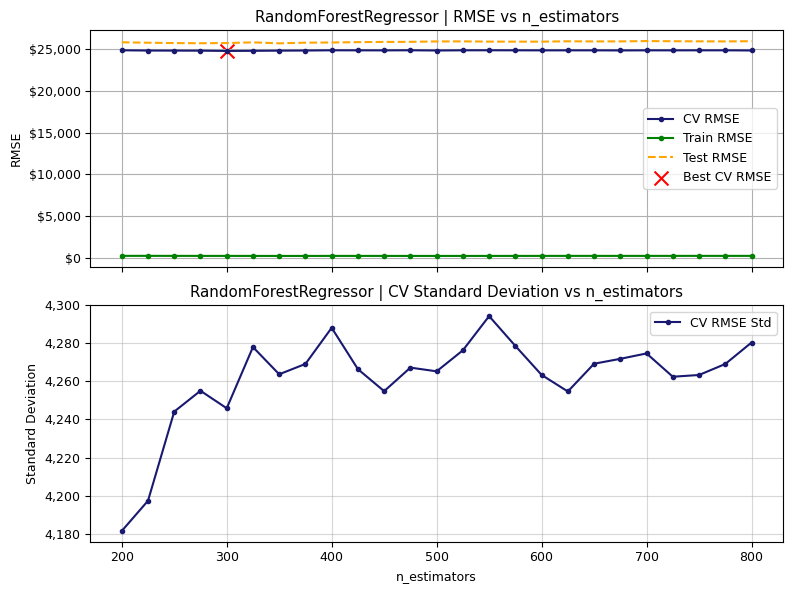

Execute successfully at: 2025-03-15 14:53:57
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=14, tm_min=53, tm_sec=57, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 300, 'max_features': 19, 'max_depth': 20, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'n_estimators', 'Model': 'RandomForestRegressor', '(R)MSE_found': 24810.013, 'cv_repeats': 2, 'test_(R)MSE': 25757.855, 'execution_time': '00:04:11', 'timestamp': '2025-03-15 14:53:57'}


{'n_estimators': 300,
 'max_features': 19,
 'max_depth': 20,
 'bootstrap': False,
 'random_state': 42,
 'Test_Param': 'n_estimators',
 'Model': 'RandomForestRegressor',
 '(R)MSE_found': 24810.013,
 'cv_repeats': 2,
 'test_(R)MSE': 25757.855,
 'execution_time': '00:04:11',
 'timestamp': '2025-03-15 14:53:57'}

In [732]:

best_params_estimators_2a = sweep_parameter(
    model           = model_2,
    Parameters      = Parameters_BT_2a,
    param           = 'n_estimators',
    parameter_list  = get_parameter_list('n_estimators',list(np.arange(200, 801, 25))),
    # parameter_list  = get_parameter_list('n_estimators'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Random_Forests['cv_repeats']
)

best_params_estimators_2a

In [733]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2a = update_clean_model_params(model_2, best_params_estimators_2a.copy())
Parameters_BT_2a 

{'n_estimators': 300,
 'max_features': 19,
 'max_depth': 20,
 'bootstrap': False,
 'random_state': 42}

#### 2a.2 max_depth

Running RandomForestRegressor with max_depth sweep...




Sweeping max_depth:   4%|▍         | 1/25 [00:07<03:00,  7.51s/it]

max_depth = None: CV MSE = 24,899.244, Train MSE = 0.097, Test MSE = 26,162.672



Sweeping max_depth:   8%|▊         | 2/25 [00:08<01:30,  3.95s/it]

max_depth = 2: CV MSE = 41,711.806, Train MSE = 41,046.279, Test MSE = 46,074.893



Sweeping max_depth:  12%|█▏        | 3/25 [00:10<01:01,  2.77s/it]

max_depth = 3: CV MSE = 36,252.883, Train MSE = 34,508.083, Test MSE = 39,321.336



Sweeping max_depth:  16%|█▌        | 4/25 [00:12<00:49,  2.34s/it]

max_depth = 4: CV MSE = 32,287.668, Train MSE = 28,774.386, Test MSE = 34,929.035



Sweeping max_depth:  20%|██        | 5/25 [00:14<00:44,  2.23s/it]

max_depth = 5: CV MSE = 29,792.125, Train MSE = 24,222.048, Test MSE = 32,118.116



Sweeping max_depth:  24%|██▍       | 6/25 [00:16<00:42,  2.26s/it]

max_depth = 6: CV MSE = 28,030.061, Train MSE = 20,305.386, Test MSE = 29,899.499



Sweeping max_depth:  28%|██▊       | 7/25 [00:19<00:43,  2.41s/it]

max_depth = 7: CV MSE = 26,886.034, Train MSE = 16,679.995, Test MSE = 28,324.186



Sweeping max_depth:  32%|███▏      | 8/25 [00:22<00:44,  2.63s/it]

max_depth = 8: CV MSE = 26,145.280, Train MSE = 13,389.954, Test MSE = 27,273.451



Sweeping max_depth:  36%|███▌      | 9/25 [00:25<00:46,  2.88s/it]

max_depth = 9: CV MSE = 25,563.542, Train MSE = 10,568.289, Test MSE = 26,502.155



Sweeping max_depth:  40%|████      | 10/25 [00:29<00:47,  3.16s/it]

max_depth = 10: CV MSE = 25,252.595, Train MSE = 8,159.320, Test MSE = 26,934.684



Sweeping max_depth:  44%|████▍     | 11/25 [00:33<00:48,  3.47s/it]

max_depth = 11: CV MSE = 25,065.763, Train MSE = 6,178.361, Test MSE = 26,330.368



Sweeping max_depth:  48%|████▊     | 12/25 [00:38<00:49,  3.78s/it]

max_depth = 12: CV MSE = 24,938.021, Train MSE = 4,595.985, Test MSE = 26,421.586



Sweeping max_depth:  52%|█████▏    | 13/25 [00:42<00:48,  4.08s/it]

max_depth = 13: CV MSE = 24,904.584, Train MSE = 3,338.455, Test MSE = 26,033.061



Sweeping max_depth:  56%|█████▌    | 14/25 [00:47<00:47,  4.33s/it]

max_depth = 14: CV MSE = 24,899.768, Train MSE = 2,397.277, Test MSE = 26,240.560



Sweeping max_depth:  60%|██████    | 15/25 [00:53<00:46,  4.63s/it]

max_depth = 15: CV MSE = 24,958.173, Train MSE = 1,691.245, Test MSE = 25,969.126



Sweeping max_depth:  64%|██████▍   | 16/25 [00:58<00:43,  4.84s/it]

max_depth = 16: CV MSE = 24,923.502, Train MSE = 1,182.996, Test MSE = 26,097.720



Sweeping max_depth:  68%|██████▊   | 17/25 [01:03<00:40,  5.07s/it]

max_depth = 17: CV MSE = 24,780.745, Train MSE = 829.149, Test MSE = 25,872.792



Sweeping max_depth:  72%|███████▏  | 18/25 [01:09<00:36,  5.26s/it]

max_depth = 18: CV MSE = 24,901.122, Train MSE = 531.809, Test MSE = 26,126.733



Sweeping max_depth:  76%|███████▌  | 19/25 [01:15<00:32,  5.49s/it]

max_depth = 19: CV MSE = 24,826.761, Train MSE = 346.846, Test MSE = 26,116.483



Sweeping max_depth:  80%|████████  | 20/25 [01:21<00:28,  5.65s/it]

max_depth = 20: CV MSE = 24,810.013, Train MSE = 207.197, Test MSE = 25,757.855



Sweeping max_depth:  84%|████████▍ | 21/25 [01:27<00:23,  5.80s/it]

max_depth = 21: CV MSE = 24,897.084, Train MSE = 139.949, Test MSE = 26,349.596



Sweeping max_depth:  88%|████████▊ | 22/25 [01:33<00:17,  5.84s/it]

max_depth = 22: CV MSE = 24,913.069, Train MSE = 86.377, Test MSE = 26,341.003



Sweeping max_depth:  92%|█████████▏| 23/25 [01:39<00:11,  5.90s/it]

max_depth = 23: CV MSE = 24,851.862, Train MSE = 50.988, Test MSE = 26,182.657



Sweeping max_depth:  96%|█████████▌| 24/25 [01:45<00:05,  5.96s/it]

max_depth = 24: CV MSE = 24,898.290, Train MSE = 33.529, Test MSE = 25,981.307



Sweeping max_depth: 100%|██████████| 25/25 [01:52<00:00,  4.48s/it]

max_depth = 25: CV MSE = 24,875.856, Train MSE = 18.268, Test MSE = 26,204.360


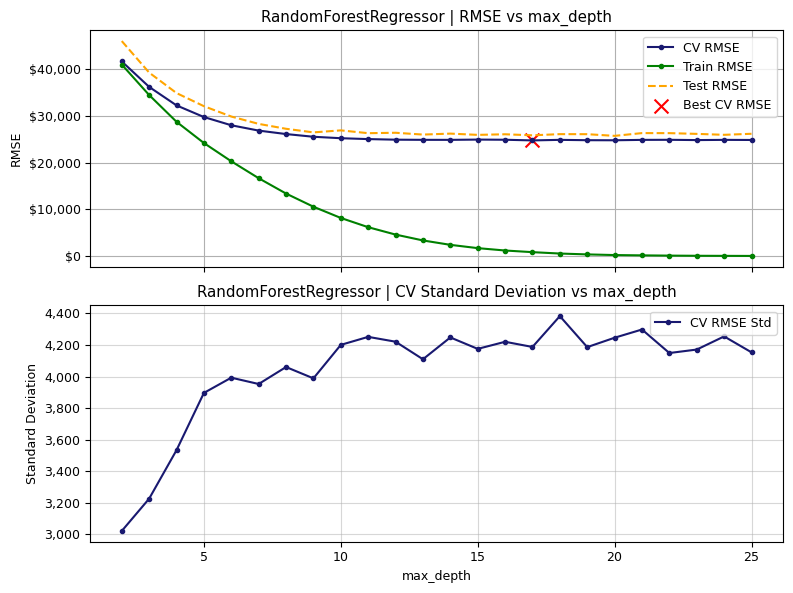

Execute successfully at: 2025-03-15 15:21:19
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=15, tm_min=21, tm_sec=19, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 300, 'max_features': 19, 'max_depth': 17, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'max_depth', 'Model': 'RandomForestRegressor', '(R)MSE_found': 24780.745, 'cv_repeats': 2, 'test_(R)MSE': 25872.792, 'execution_time': '00:01:52', 'timestamp': '2025-03-15 15:21:19'}


{'n_estimators': 300,
 'max_features': 19,
 'max_depth': 17,
 'bootstrap': False,
 'random_state': 42,
 'Test_Param': 'max_depth',
 'Model': 'RandomForestRegressor',
 '(R)MSE_found': 24780.745,
 'cv_repeats': 2,
 'test_(R)MSE': 25872.792,
 'execution_time': '00:01:52',
 'timestamp': '2025-03-15 15:21:19'}

In [734]:
best_params_max_depth_2a = sweep_parameter(
    model           = model_2,
    Parameters      = Parameters_BT_2a,
    param           = 'max_depth',
    parameter_list  = get_parameter_list('max_depth'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Random_Forests['cv_repeats']
)

best_params_max_depth_2a

In [738]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##
Parameters_BT_2a = update_clean_model_params(model_2, best_params_max_depth_2a.copy())
Parameters_BT_2a 

{'n_estimators': 300,
 'max_features': 19,
 'max_depth': 17,
 'bootstrap': False,
 'random_state': 42}

#### 2a.3 max_features

Running RandomForestRegressor with max_features sweep...




Sweeping max_features:   3%|▎         | 1/31 [00:22<11:03, 22.10s/it]

max_features = None: CV MSE = 35,521.221, Train MSE = 1,294.670, Test MSE = 33,789.070



Sweeping max_features:   6%|▋         | 2/31 [00:26<05:41, 11.76s/it]

max_features = 10: CV MSE = 25,037.287, Train MSE = 1,063.515, Test MSE = 25,631.687



Sweeping max_features:  10%|▉         | 3/31 [00:30<03:46,  8.09s/it]

max_features = 11: CV MSE = 24,905.388, Train MSE = 1,034.627, Test MSE = 26,027.646



Sweeping max_features:  13%|█▎        | 4/31 [00:34<02:53,  6.43s/it]

max_features = 12: CV MSE = 24,765.336, Train MSE = 963.240, Test MSE = 25,540.940



Sweeping max_features:  16%|█▌        | 5/31 [00:38<02:25,  5.60s/it]

max_features = 13: CV MSE = 24,963.494, Train MSE = 922.390, Test MSE = 25,878.960



Sweeping max_features:  19%|█▉        | 6/31 [00:42<02:09,  5.16s/it]

max_features = 14: CV MSE = 24,995.312, Train MSE = 887.789, Test MSE = 26,038.089



Sweeping max_features:  23%|██▎       | 7/31 [00:47<01:58,  4.96s/it]

max_features = 15: CV MSE = 24,790.831, Train MSE = 887.922, Test MSE = 25,657.327



Sweeping max_features:  26%|██▌       | 8/31 [00:52<01:52,  4.91s/it]

max_features = 16: CV MSE = 24,781.959, Train MSE = 885.719, Test MSE = 26,411.644



Sweeping max_features:  29%|██▉       | 9/31 [00:57<01:48,  4.95s/it]

max_features = 17: CV MSE = 24,802.802, Train MSE = 842.542, Test MSE = 25,787.972



Sweeping max_features:  32%|███▏      | 10/31 [01:02<01:46,  5.08s/it]

max_features = 18: CV MSE = 24,818.094, Train MSE = 878.952, Test MSE = 26,130.590



Sweeping max_features:  35%|███▌      | 11/31 [01:08<01:47,  5.39s/it]

max_features = 19: CV MSE = 24,780.745, Train MSE = 829.149, Test MSE = 25,872.792



Sweeping max_features:  39%|███▊      | 12/31 [01:14<01:46,  5.60s/it]

max_features = 20: CV MSE = 24,944.701, Train MSE = 769.276, Test MSE = 25,922.638



Sweeping max_features:  42%|████▏     | 13/31 [01:20<01:43,  5.74s/it]

max_features = 21: CV MSE = 24,998.460, Train MSE = 775.509, Test MSE = 26,030.914



Sweeping max_features:  45%|████▌     | 14/31 [01:26<01:39,  5.88s/it]

max_features = 22: CV MSE = 25,040.377, Train MSE = 780.823, Test MSE = 26,712.798



Sweeping max_features:  48%|████▊     | 15/31 [01:33<01:37,  6.10s/it]

max_features = 23: CV MSE = 25,018.214, Train MSE = 781.340, Test MSE = 25,960.804



Sweeping max_features:  52%|█████▏    | 16/31 [01:40<01:35,  6.36s/it]

max_features = 24: CV MSE = 24,993.072, Train MSE = 744.302, Test MSE = 26,449.303



Sweeping max_features:  55%|█████▍    | 17/31 [01:47<01:32,  6.59s/it]

max_features = 25: CV MSE = 24,994.022, Train MSE = 705.828, Test MSE = 26,870.923



Sweeping max_features:  58%|█████▊    | 18/31 [01:54<01:28,  6.81s/it]

max_features = 26: CV MSE = 25,067.653, Train MSE = 735.010, Test MSE = 26,616.374



Sweeping max_features:  61%|██████▏   | 19/31 [02:02<01:24,  7.01s/it]

max_features = 27: CV MSE = 25,158.965, Train MSE = 691.226, Test MSE = 26,239.065



Sweeping max_features:  65%|██████▍   | 20/31 [02:10<01:19,  7.25s/it]

max_features = 28: CV MSE = 25,128.413, Train MSE = 703.979, Test MSE = 26,824.393



Sweeping max_features:  68%|██████▊   | 21/31 [02:18<01:14,  7.45s/it]

max_features = 29: CV MSE = 25,033.769, Train MSE = 703.832, Test MSE = 25,981.453



Sweeping max_features:  71%|███████   | 22/31 [02:26<01:09,  7.68s/it]

max_features = 30: CV MSE = 25,279.172, Train MSE = 661.212, Test MSE = 26,323.218



Sweeping max_features:  74%|███████▍  | 23/31 [02:34<01:02,  7.87s/it]

max_features = 31: CV MSE = 25,170.176, Train MSE = 675.070, Test MSE = 26,464.986



Sweeping max_features:  77%|███████▋  | 24/31 [02:43<00:56,  8.05s/it]

max_features = 32: CV MSE = 25,174.118, Train MSE = 669.586, Test MSE = 26,421.388



Sweeping max_features:  81%|████████  | 25/31 [02:51<00:49,  8.25s/it]

max_features = 33: CV MSE = 25,223.004, Train MSE = 657.660, Test MSE = 25,849.438



Sweeping max_features:  84%|████████▍ | 26/31 [03:01<00:43,  8.62s/it]

max_features = 34: CV MSE = 25,316.757, Train MSE = 659.168, Test MSE = 26,536.089



Sweeping max_features:  87%|████████▋ | 27/31 [03:11<00:35,  8.99s/it]

max_features = 35: CV MSE = 25,443.220, Train MSE = 650.924, Test MSE = 26,138.424



Sweeping max_features:  90%|█████████ | 28/31 [03:20<00:27,  9.12s/it]

max_features = 36: CV MSE = 25,362.553, Train MSE = 646.936, Test MSE = 26,349.091



Sweeping max_features:  94%|█████████▎| 29/31 [03:30<00:18,  9.27s/it]

max_features = 37: CV MSE = 25,549.772, Train MSE = 648.652, Test MSE = 26,655.125



Sweeping max_features:  97%|█████████▋| 30/31 [03:40<00:09,  9.47s/it]

max_features = 38: CV MSE = 25,593.143, Train MSE = 628.709, Test MSE = 26,304.209



Sweeping max_features: 100%|██████████| 31/31 [03:50<00:00,  7.43s/it]

max_features = 39: CV MSE = 25,657.509, Train MSE = 619.079, Test MSE = 26,021.338


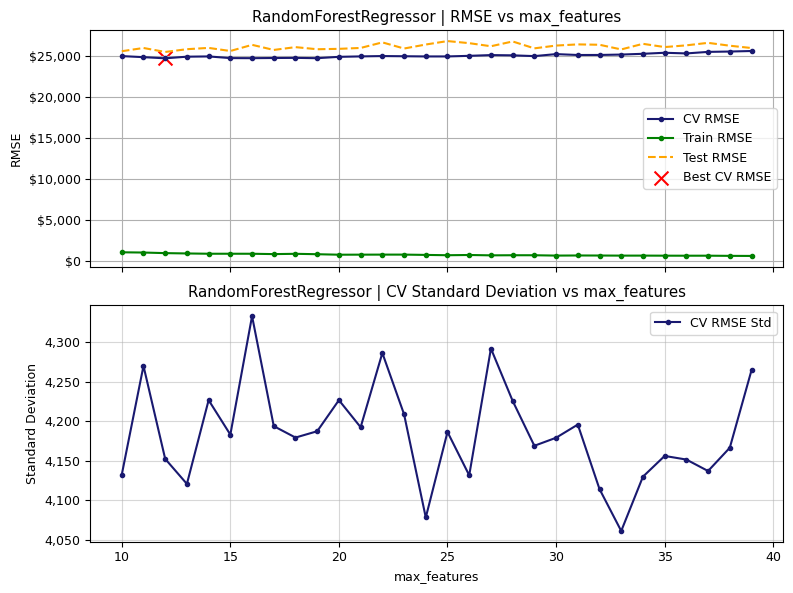

Execute successfully at: 2025-03-15 16:34:19
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=16, tm_min=34, tm_sec=19, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 300, 'max_features': 12, 'max_depth': 17, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'max_features', 'Model': 'RandomForestRegressor', '(R)MSE_found': 24765.336, 'cv_repeats': 2, 'test_(R)MSE': 25540.94, 'execution_time': '00:03:50', 'timestamp': '2025-03-15 16:34:19'}


{'n_estimators': 300,
 'max_features': 12,
 'max_depth': 17,
 'bootstrap': False,
 'random_state': 42,
 'Test_Param': 'max_features',
 'Model': 'RandomForestRegressor',
 '(R)MSE_found': 24765.336,
 'cv_repeats': 2,
 'test_(R)MSE': 25540.94,
 'execution_time': '00:03:50',
 'timestamp': '2025-03-15 16:34:19'}

In [739]:
best_params_max_features_2a = sweep_parameter(
    model           = model_2,
    Parameters      = Parameters_BT_2a,
    param           = 'max_features',
    # parameter_list  = get_parameter_list('max_features', X_train),
    parameter_list  = [None] + list(range(10, 40)),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 2
)

best_params_max_features_2a

In [740]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2a = update_clean_model_params(model_2, best_params_max_features_2a.copy())
Parameters_BT_2a 

{'n_estimators': 300,
 'max_features': 12,
 'max_depth': 17,
 'bootstrap': False,
 'random_state': 42}

#### 2a.4 bootstrap

Running RandomForestRegressor with bootstrap sweep...




Sweeping bootstrap:  50%|█████     | 1/2 [00:04<00:04,  4.87s/it]

bootstrap = True: CV MSE = 25,701.187, Train MSE = 9,627.833, Test MSE = 26,512.347



Sweeping bootstrap: 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]

bootstrap = False: CV MSE = 24,765.336, Train MSE = 963.240, Test MSE = 25,540.940


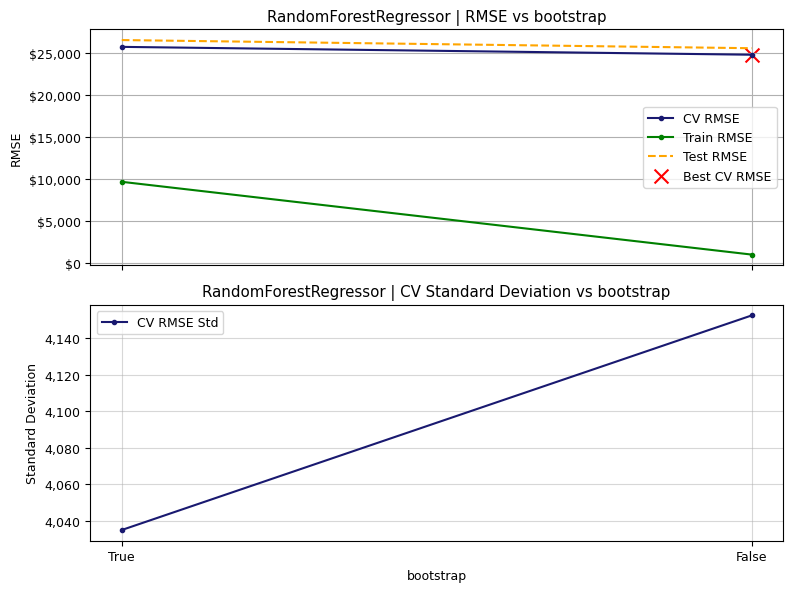

Execute successfully at: 2025-03-15 16:44:46
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=16, tm_min=44, tm_sec=46, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 300, 'max_features': 12, 'max_depth': 17, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'bootstrap', 'Model': 'RandomForestRegressor', '(R)MSE_found': 24765.336, 'cv_repeats': 2, 'test_(R)MSE': 25540.94, 'execution_time': '00:00:09', 'timestamp': '2025-03-15 16:44:46'}
{'n_estimators': 300, 'max_features': 12, 'max_depth': 17, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'bootstrap', 'Model': 'RandomForestRegressor', '(R)MSE_found': 24765.336, 'cv_repeats': 2, 'test_(R)MSE': 25540.94, 'execution_time': '00:00:09', 'timestamp': '2025-03-15 16:44:46'}


In [741]:

best_params_bootstrap_2a = sweep_parameter(
    model           = model_2,
    Parameters      = Parameters_BT_2a,
    param           = 'bootstrap',
    parameter_list  = get_parameter_list('bootstrap'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 2
)

print(best_params_bootstrap_2a)

In [743]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2a = update_clean_model_params(model_2, best_params_bootstrap_2a.copy())
Parameters_BT_2a 

{'n_estimators': 300,
 'max_features': 12,
 'max_depth': 17,
 'bootstrap': False,
 'random_state': 42}

#### 2a. Summary

In [744]:
summary_df_2a = pd.DataFrame([dict_baseline_2a, 
                            best_params_estimators_2a, 
                            best_params_max_depth_2a, 
                            best_params_max_features_2a,
                            best_params_bootstrap_2a],
                            columns = ensemble_df_columns['RandomForestRegressor']                         
                        )
summary_df_2a = df_format_dropDuplicateRows(summary_df_2a)

summary_df_2a

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_depth,max_features,bootstrap,execution_time,timestamp
0,RandomForestRegressor,Baseline_2a,2,26483.789,26508.767,100,None,None,True,00:00:04,2025-03-15 14:46:20
1,RandomForestRegressor,n_estimators,2,24810.013,25757.855,300,20.0,19.0,False,00:04:11,2025-03-15 14:53:57
2,RandomForestRegressor,max_depth,2,24780.745,25872.792,300,17.0,19.0,False,00:01:52,2025-03-15 15:21:19
3,RandomForestRegressor,max_features,2,24765.336,25540.94,300,17.0,12.0,False,00:03:50,2025-03-15 16:34:19
4,RandomForestRegressor,bootstrap,2,24765.336,25540.94,300,17.0,12.0,False,00:00:09,2025-03-15 16:44:46


### Problem 2.A Graded Answer

In [746]:
# TODO:  Set the variable to best CV RMSE score found after Part 2.A

a2a = best_params_bootstrap_2a['(R)MSE_found']                               # Just to get it to run without error; your answer here (remember to use the RMSE)         

print(f'a2a = ${a2a:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = $24,765.34


### **Part 2.B: Refine Parameters for Model Stability**  


#### 2b.0 Baseline

In [747]:

Default_Parameters_Random_Forests['cv_repeats'] = 10
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2b = update_clean_model_params(model_2, Default_Parameters_Random_Forests.copy())
print(Parameters_BT_2b)


{'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42}


In [748]:
Default_Parameters_RandomForests_baseline = Default_Parameters_Random_Forests.copy()
Default_Parameters_RandomForests_baseline = update_clean_model_params(model_2, 
                                                         Default_Parameters_RandomForests_baseline
                                                         )

start = time.time()
# Run the baseline model
mean_cv_mse, std_cv_mse, train_mse, test_mse = run_model(model_2, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test, 
                                                         n_repeats  = Default_Parameters_Random_Forests['cv_repeats'],
                                                         n_jobs     = -1,
                                                         exp_factor = 0.5,  # Square root of MSE
                                                         **Default_Parameters_RandomForests_baseline
                                                        )

end                                 = time.time()
execution_time                      = format_hms(end - start)
timestamp                           = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))


dict_baseline_2b = {
    'mean_CV_MSE':      mean_cv_mse,
    'std_CV_MSE':       std_cv_mse,
    'train_MSE':        train_mse,
    'test_(R)MSE':      test_mse,
    'cv_repeats':       Default_Parameters_Random_Forests['cv_repeats'],
    '(R)MSE_found':     mean_cv_mse,
    'n_estimators':     Default_Parameters_RandomForests_baseline['n_estimators'],
    'max_depth':        Default_Parameters_RandomForests_baseline['max_depth'],
    'max_features':     Default_Parameters_RandomForests_baseline['max_features'],
    'bootstrap':        Default_Parameters_RandomForests_baseline['bootstrap'],
    'Model':            model_2.__name__,
    'Test_Param':       'Baseline_2b',
    'execution_time':   execution_time,
    'timestamp':        timestamp
}


print("Baseline results for RandomForestsRegressor:\n", dict_baseline_2b)
dict_baseline_2b


Baseline results for RandomForestsRegressor:
 {'mean_CV_MSE': 26714.787, 'std_CV_MSE': 3711.593, 'train_MSE': 10076.192, 'test_(R)MSE': 26508.767, 'cv_repeats': 10, '(R)MSE_found': 26714.787, 'n_estimators': 100, 'max_depth': None, 'max_features': None, 'bootstrap': True, 'Model': 'RandomForestRegressor', 'Test_Param': 'Baseline_2b', 'execution_time': '00:00:13', 'timestamp': '2025-03-15 16:45:27'}


{'mean_CV_MSE': 26714.787,
 'std_CV_MSE': 3711.593,
 'train_MSE': 10076.192,
 'test_(R)MSE': 26508.767,
 'cv_repeats': 10,
 '(R)MSE_found': 26714.787,
 'n_estimators': 100,
 'max_depth': None,
 'max_features': None,
 'bootstrap': True,
 'Model': 'RandomForestRegressor',
 'Test_Param': 'Baseline_2b',
 'execution_time': '00:00:13',
 'timestamp': '2025-03-15 16:45:27'}

#### 2b.1 n_estimators

In [628]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2b = update_clean_model_params(model_2, Default_Parameters_Random_Forests.copy())
print(Parameters_BT_2b)

{'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42}


Running RandomForestRegressor with n_estimators sweep...




Sweeping n_estimators:  12%|█▎        | 1/8 [00:50<05:54, 50.62s/it]

n_estimators = 385: CV MSE = 26,607.615, Train MSE = 9,757.993, Test MSE = 26,908.727



Sweeping n_estimators:  25%|██▌       | 2/8 [01:44<05:15, 52.57s/it]

n_estimators = 390: CV MSE = 26,605.127, Train MSE = 9,759.899, Test MSE = 26,885.438



Sweeping n_estimators:  38%|███▊      | 3/8 [02:33<04:14, 51.00s/it]

n_estimators = 395: CV MSE = 26,602.339, Train MSE = 9,773.197, Test MSE = 26,897.320



Sweeping n_estimators:  50%|█████     | 4/8 [03:22<03:20, 50.06s/it]

n_estimators = 400: CV MSE = 26,601.523, Train MSE = 9,781.712, Test MSE = 26,913.270



Sweeping n_estimators:  62%|██████▎   | 5/8 [04:11<02:29, 49.83s/it]

n_estimators = 405: CV MSE = 26,604.585, Train MSE = 9,790.846, Test MSE = 26,925.128



Sweeping n_estimators:  75%|███████▌  | 6/8 [05:01<01:39, 49.67s/it]

n_estimators = 410: CV MSE = 26,604.712, Train MSE = 9,788.200, Test MSE = 26,946.224



Sweeping n_estimators:  88%|████████▊ | 7/8 [05:51<00:49, 49.82s/it]

n_estimators = 415: CV MSE = 26,605.904, Train MSE = 9,796.941, Test MSE = 26,973.654



Sweeping n_estimators: 100%|██████████| 8/8 [06:41<00:00, 50.20s/it]

n_estimators = 420: CV MSE = 26,605.095, Train MSE = 9,779.281, Test MSE = 27,002.881


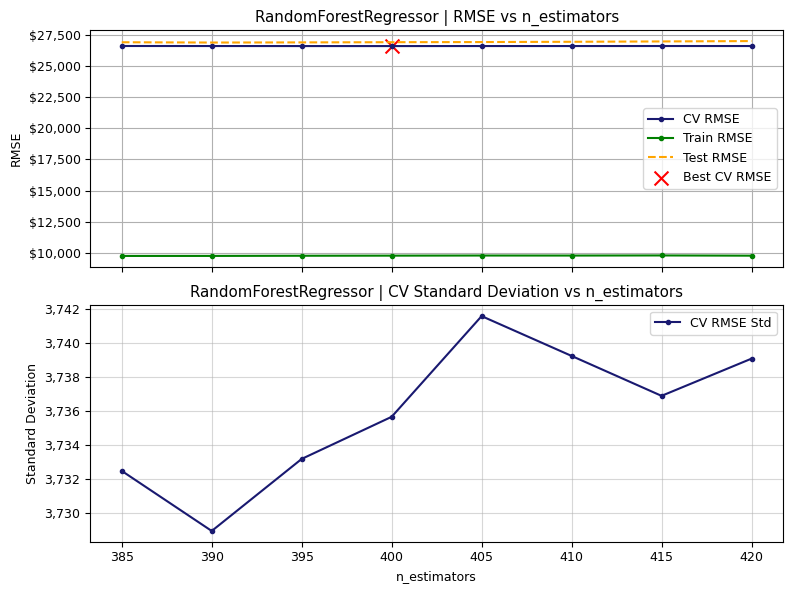

Execute successfully at: 2025-03-15 16:52:31
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=16, tm_min=52, tm_sec=31, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 400, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'Test_Param': 'n_estimators', 'Model': 'RandomForestRegressor', '(R)MSE_found': 26601.523, 'cv_repeats': 10, 'test_(R)MSE': 26913.27, 'execution_time': '00:06:41', 'timestamp': '2025-03-15 16:52:31'}


{'n_estimators': 400,
 'max_features': None,
 'max_depth': None,
 'bootstrap': True,
 'random_state': 42,
 'Test_Param': 'n_estimators',
 'Model': 'RandomForestRegressor',
 '(R)MSE_found': 26601.523,
 'cv_repeats': 10,
 'test_(R)MSE': 26913.27,
 'execution_time': '00:06:41',
 'timestamp': '2025-03-15 16:52:31'}

In [749]:

best_params_estimators_2b = sweep_parameter(
    model           = model_2,
    Parameters      = Parameters_BT_2b,
    param           = 'n_estimators',
    parameter_list  = get_parameter_list('n_estimators',list(np.arange(385, 421, 5))),
    # parameter_list  = get_parameter_list('n_estimators'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Random_Forests['cv_repeats']
)

best_params_estimators_2b

#### 2b.2 max_depth

In [753]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2b = update_clean_model_params(model_2, best_params_estimators_2b.copy())
print(Parameters_BT_2b)

{'n_estimators': 400, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42}


Running RandomForestRegressor with max_depth sweep...




Sweeping max_depth:   9%|▉         | 1/11 [00:52<08:40, 52.02s/it]

max_depth = 25: CV MSE = 26,609.499, Train MSE = 9,803.251, Test MSE = 26,926.940



Sweeping max_depth:  18%|█▊        | 2/11 [01:45<07:54, 52.73s/it]

max_depth = 26: CV MSE = 26,604.577, Train MSE = 9,788.850, Test MSE = 26,891.693



Sweeping max_depth:  27%|██▋       | 3/11 [02:39<07:07, 53.46s/it]

max_depth = 27: CV MSE = 26,605.225, Train MSE = 9,781.790, Test MSE = 26,876.045



Sweeping max_depth:  36%|███▋      | 4/11 [03:28<06:00, 51.50s/it]

max_depth = 28: CV MSE = 26,601.973, Train MSE = 9,780.483, Test MSE = 26,918.110



Sweeping max_depth:  45%|████▌     | 5/11 [04:16<05:02, 50.43s/it]

max_depth = 29: CV MSE = 26,603.288, Train MSE = 9,778.806, Test MSE = 26,917.876



Sweeping max_depth:  55%|█████▍    | 6/11 [05:04<04:07, 49.56s/it]

max_depth = 30: CV MSE = 26,603.571, Train MSE = 9,781.381, Test MSE = 26,922.409



Sweeping max_depth:  64%|██████▎   | 7/11 [05:52<03:15, 48.96s/it]

max_depth = 31: CV MSE = 26,601.691, Train MSE = 9,782.549, Test MSE = 26,913.762



Sweeping max_depth:  73%|███████▎  | 8/11 [06:40<02:26, 48.67s/it]

max_depth = 32: CV MSE = 26,601.524, Train MSE = 9,780.654, Test MSE = 26,908.684



Sweeping max_depth:  82%|████████▏ | 9/11 [07:27<01:36, 48.26s/it]

max_depth = 33: CV MSE = 26,601.862, Train MSE = 9,781.209, Test MSE = 26,909.142



Sweeping max_depth:  91%|█████████ | 10/11 [08:16<00:48, 48.37s/it]

max_depth = 34: CV MSE = 26,601.829, Train MSE = 9,781.712, Test MSE = 26,913.270



Sweeping max_depth: 100%|██████████| 11/11 [09:04<00:00, 49.49s/it]

max_depth = 35: CV MSE = 26,601.643, Train MSE = 9,781.712, Test MSE = 26,913.270


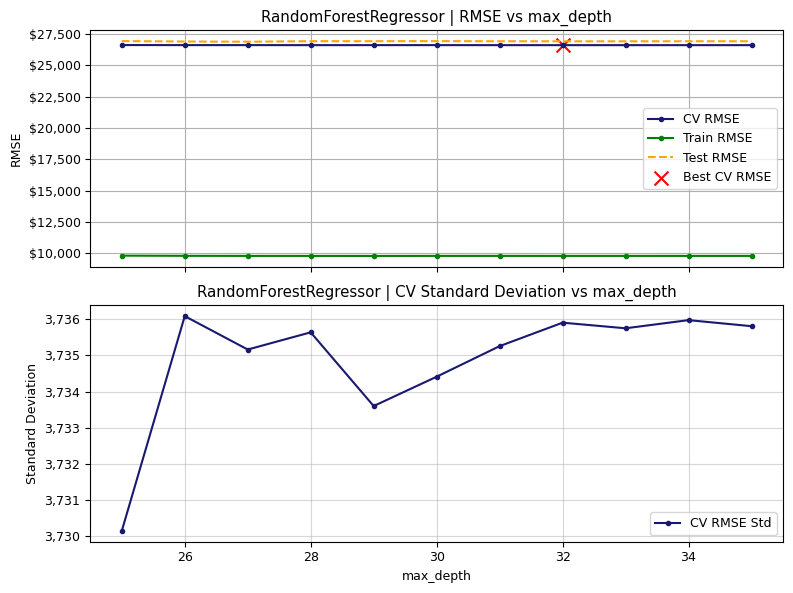

Execute successfully at: 2025-03-15 18:43:38
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=18, tm_min=43, tm_sec=38, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 400, 'max_features': None, 'max_depth': 32, 'bootstrap': True, 'random_state': 42, 'Test_Param': 'max_depth', 'Model': 'RandomForestRegressor', '(R)MSE_found': 26601.524, 'cv_repeats': 10, 'test_(R)MSE': 26908.684, 'execution_time': '00:09:04', 'timestamp': '2025-03-15 18:43:38'}


{'n_estimators': 400,
 'max_features': None,
 'max_depth': 32,
 'bootstrap': True,
 'random_state': 42,
 'Test_Param': 'max_depth',
 'Model': 'RandomForestRegressor',
 '(R)MSE_found': 26601.524,
 'cv_repeats': 10,
 'test_(R)MSE': 26908.684,
 'execution_time': '00:09:04',
 'timestamp': '2025-03-15 18:43:38'}

In [756]:
best_params_max_depth_2b = sweep_parameter(
    model           = model_2,
    Parameters      = Parameters_BT_2b,
    param           = 'max_depth',
    parameter_list  = get_parameter_list('max_depth', list(np.arange(25,36,1))),  

    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Random_Forests['cv_repeats']
)

best_params_max_depth_2b

In [758]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2b = update_clean_model_params(model_2, best_params_max_depth_2b.copy())
print(Parameters_BT_2b)

{'n_estimators': 400, 'max_features': None, 'max_depth': 32, 'bootstrap': True, 'random_state': 42}


#### 2b.3 max_features

Running RandomForestRegressor with max_features sweep...




Sweeping max_features:   8%|▊         | 1/12 [00:13<02:33, 13.97s/it]

max_features = 15: CV MSE = 25,759.291, Train MSE = 9,367.260, Test MSE = 25,962.562



Sweeping max_features:  17%|█▋        | 2/12 [00:28<02:21, 14.13s/it]

max_features = 16: CV MSE = 25,671.500, Train MSE = 9,374.817, Test MSE = 26,652.424



Sweeping max_features:  25%|██▌       | 3/12 [00:42<02:09, 14.42s/it]

max_features = 17: CV MSE = 25,665.133, Train MSE = 9,369.742, Test MSE = 26,502.090



Sweeping max_features:  33%|███▎      | 4/12 [00:58<02:00, 15.01s/it]

max_features = 18: CV MSE = 25,690.299, Train MSE = 9,445.813, Test MSE = 26,414.580



Sweeping max_features:  42%|████▏     | 5/12 [01:15<01:48, 15.45s/it]

max_features = 19: CV MSE = 25,669.790, Train MSE = 9,390.857, Test MSE = 26,591.700



Sweeping max_features:  50%|█████     | 6/12 [01:31<01:35, 15.90s/it]

max_features = 20: CV MSE = 25,693.589, Train MSE = 9,343.006, Test MSE = 26,329.232



Sweeping max_features:  58%|█████▊    | 7/12 [01:49<01:21, 16.35s/it]

max_features = 21: CV MSE = 25,616.940, Train MSE = 9,418.849, Test MSE = 26,278.135



Sweeping max_features:  67%|██████▋   | 8/12 [02:07<01:07, 16.87s/it]

max_features = 22: CV MSE = 25,677.274, Train MSE = 9,438.862, Test MSE = 26,147.174



Sweeping max_features:  75%|███████▌  | 9/12 [02:27<00:53, 17.80s/it]

max_features = 23: CV MSE = 25,675.184, Train MSE = 9,380.207, Test MSE = 26,667.880



Sweeping max_features:  83%|████████▎ | 10/12 [10:49<05:35, 167.52s/it]

max_features = 24: CV MSE = 25,703.715, Train MSE = 9,350.443, Test MSE = 26,219.245



Sweeping max_features:  92%|█████████▏| 11/12 [11:11<02:02, 122.88s/it]

max_features = 25: CV MSE = 25,655.099, Train MSE = 9,369.007, Test MSE = 26,170.472



Sweeping max_features: 100%|██████████| 12/12 [11:33<00:00, 57.81s/it]

max_features = 26: CV MSE = 25,708.065, Train MSE = 9,402.631, Test MSE = 26,050.123


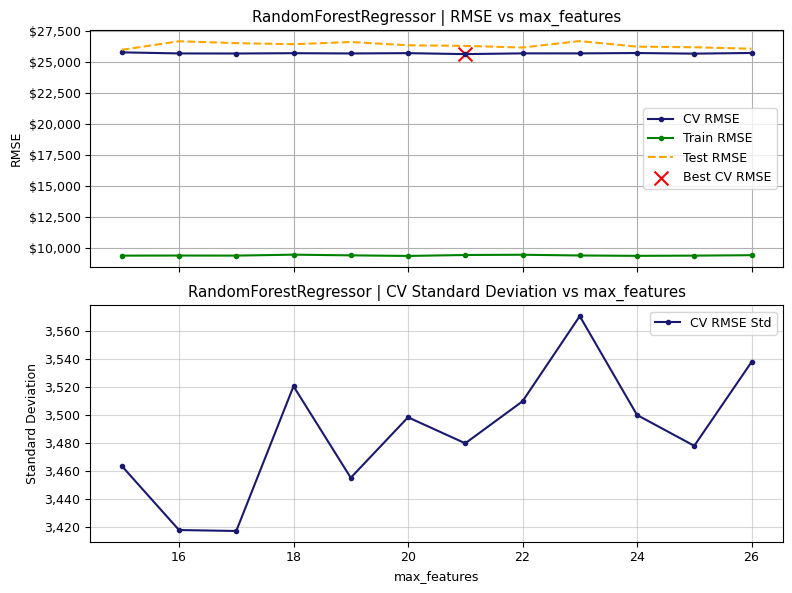

Execute successfully at: 2025-03-15 18:59:31
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=18, tm_min=59, tm_sec=31, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 400, 'max_features': 21, 'max_depth': 32, 'bootstrap': True, 'random_state': 42, 'Test_Param': 'max_features', 'Model': 'RandomForestRegressor', '(R)MSE_found': 25616.94, 'cv_repeats': 10, 'test_(R)MSE': 26278.135, 'execution_time': '00:11:33', 'timestamp': '2025-03-15 18:59:31'}


{'n_estimators': 400,
 'max_features': 21,
 'max_depth': 32,
 'bootstrap': True,
 'random_state': 42,
 'Test_Param': 'max_features',
 'Model': 'RandomForestRegressor',
 '(R)MSE_found': 25616.94,
 'cv_repeats': 10,
 'test_(R)MSE': 26278.135,
 'execution_time': '00:11:33',
 'timestamp': '2025-03-15 18:59:31'}

In [759]:
best_params_max_features_2b = sweep_parameter(
    model           = model_2,
    Parameters      = Parameters_BT_2b,
    param           = 'max_features',
    # parameter_list  = get_parameter_list('max_features', X_train),
    # parameter_list  = [None] + list(range(2,24)),
    parameter_list  =  get_parameter_list('max_features', list(range(15,27)), X_train),    #  list(range(15,27)),

    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Random_Forests['cv_repeats']
)

best_params_max_features_2b

In [760]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2b = update_clean_model_params(model_2, best_params_max_features_2b.copy())
print(Parameters_BT_2b)

{'n_estimators': 400, 'max_features': 21, 'max_depth': 32, 'bootstrap': True, 'random_state': 42}


#### 2b.4 bootstrap

Running RandomForestRegressor with bootstrap sweep...




Sweeping bootstrap:  50%|█████     | 1/2 [00:20<00:20, 20.61s/it]

bootstrap = True: CV MSE = 25,616.940, Train MSE = 9,418.849, Test MSE = 26,278.135



Sweeping bootstrap: 100%|██████████| 2/2 [00:48<00:00, 24.35s/it]

bootstrap = False: CV MSE = 24,961.174, Train MSE = 0.447, Test MSE = 26,089.108


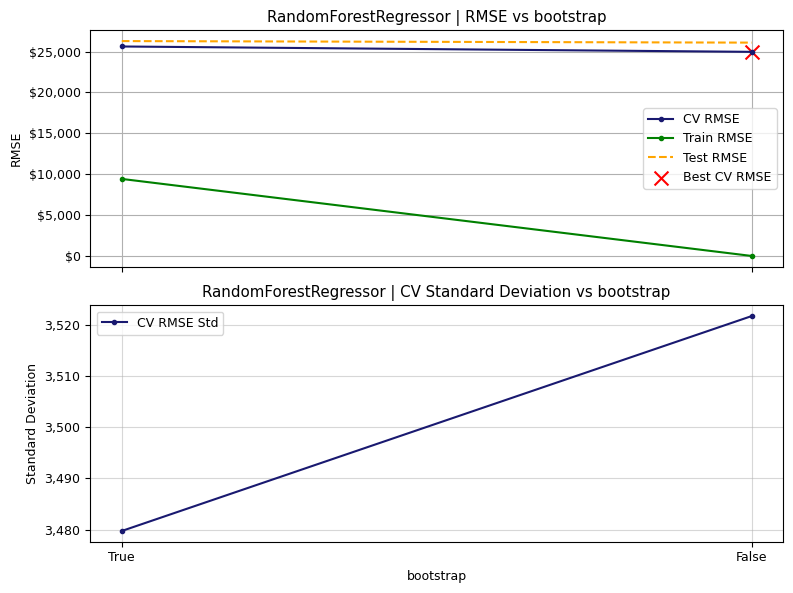

Execute successfully at: 2025-03-15 20:46:48
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=15, tm_hour=20, tm_min=46, tm_sec=48, tm_wday=5, tm_yday=74, tm_isdst=1)
Parameters: {'n_estimators': 400, 'max_features': 21, 'max_depth': 32, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'bootstrap', 'Model': 'RandomForestRegressor', '(R)MSE_found': 24961.174, 'cv_repeats': 10, 'test_(R)MSE': 26089.108, 'execution_time': '00:00:48', 'timestamp': '2025-03-15 20:46:48'}
{'n_estimators': 400, 'max_features': 21, 'max_depth': 32, 'bootstrap': False, 'random_state': 42, 'Test_Param': 'bootstrap', 'Model': 'RandomForestRegressor', '(R)MSE_found': 24961.174, 'cv_repeats': 10, 'test_(R)MSE': 26089.108, 'execution_time': '00:00:48', 'timestamp': '2025-03-15 20:46:48'}


In [761]:

best_params_bootstrap_2b = sweep_parameter(
    model           = model_2,
    Parameters      = Parameters_BT_2b,
    param           = 'bootstrap',
    parameter_list  = get_parameter_list('bootstrap'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_Random_Forests['cv_repeats']
)

print(best_params_bootstrap_2b)

In [762]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_2b = update_clean_model_params(model_2, best_params_bootstrap_2b.copy())
Parameters_BT_2b 

{'n_estimators': 400,
 'max_features': 21,
 'max_depth': 32,
 'bootstrap': False,
 'random_state': 42}

#### 2b. Summary

In [763]:
summary_df_2b = pd.DataFrame([dict_baseline_2b, 
                            best_params_estimators_2b, 
                            best_params_max_depth_2b, 
                            best_params_max_features_2b,
                            best_params_bootstrap_2b],
                            columns = ensemble_df_columns['RandomForestRegressor']
                        )
summary_df_2b = df_format_dropDuplicateRows(summary_df_2b)
summary_df_2b

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_depth,max_features,bootstrap,execution_time,timestamp
0,RandomForestRegressor,Baseline_2b,10,26714.787,26508.767,100,None,None,True,00:00:13,2025-03-15 16:45:27
1,RandomForestRegressor,n_estimators,10,26601.523,26913.27,400,None,None,True,00:06:41,2025-03-15 16:52:31
2,RandomForestRegressor,max_depth,10,26601.524,26908.684,400,32.0,None,True,00:09:04,2025-03-15 18:43:38
3,RandomForestRegressor,max_features,10,25616.94,26278.135,400,32.0,21.0,True,00:11:33,2025-03-15 18:59:31
4,RandomForestRegressor,bootstrap,10,24961.174,26089.108,400,32.0,21.0,False,00:00:48,2025-03-15 20:46:48


### Problem 2.B Graded Answer

In [764]:
# TODO:  Set the variable to best CV RMSE score found after Part 2.B (it may not be different than Part 2.A)

a2b = summary_df_2b['(R)MSE_found'].min()                                # Just to get it to run without error; your answer here           

print(f'a2b = ${a2b:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = $24,961.17


### **Part 2.C: Use `GridSearchCV` for Exhaustive Search**  

#### 2.C RandomizedSearchCV

In [766]:
# Define the parameter grid
param_dist = {
    'n_estimators'  : get_parameter_list('n_estimators', list(np.arange(385, 426, 5))),                 
    'max_depth'     : get_parameter_list('max_depth'),
    'max_features'  : get_parameter_list('max_features', list(np.arange(15, 31)), X_train),  # start from 32/33 features
    'bootstrap'     : get_parameter_list('bootstrap'),  
}


best_params_randomsearch_2c_df = run_GridSearch_RandomizedSearch_CV(
    ensemble_model      = model_2, 
    parameter_grid      = param_dist, 
    randomized_search   = True,
    show_RMSE           = True,
    X_train             = X_train,
    y_train             = y_train,
    iterations          = 10,
    n_jobs              = -1,
    verbose             = True,
    n_repeats           = 10,
    cv_folds            = 5,
    random_state        = 42
    )

best_params_randomsearch_2c_df

Using RandomizedSearchCV............................................
results_df.columns:
 Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_max_features', 'param_max_depth',
       'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

Search Results (Top 10):

n_estimators max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score
         395           16      24120.644      9835.771           456.079          171.339
         385           25      24365.948     10225.717          1303.732          402.563
         405           30      24548.399     10642.454        

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_depth,max_features,bootstrap,execution_time,timestamp
0,RandomForestRegressor,RandomizedSearchCV,10,24120.644,25964.406,395,18,16,False,00:00:19,2025-03-15 20:57:26


#### 2.c GridSearchCV

In [769]:
best_params_gridsearch_2c_df = run_GridSearch_RandomizedSearch_CV(
                                ensemble_model      = model_2, 
                                parameter_grid      = param_dist, 
                                randomized_search   = False,
                                show_RMSE           = True,
                                X_train             = X_train,
                                y_train             = y_train,
                                iterations          = 10,
                                n_jobs              = -1,
                                verbose             = True,
                                n_repeats           = 10,
                                cv_folds            = 5,
                                random_state        = 42

)

best_params_gridsearch_2c_df

Using GridSearchCV............................................
results_df.columns:
 Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_bootstrap', 'param_max_depth', 'param_max_features',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

Search Results (Top 10):

n_estimators max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score
         395           18      23961.598      9941.689            57.867           33.250
         390           18      23967.478      9907.947            57.878           32.920
         400           18      23972.053      9941.263            57

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_depth,max_features,bootstrap,execution_time,timestamp
0,RandomForestRegressor,GridSearchCV,10,23961.5982,26079.684,395,22,18,False,03:02:20,2025-03-16 00:24:07


In [770]:
results_list = []
results_list.append(best_params_randomsearch_2c_df)
results_list.append(best_params_gridsearch_2c_df)

# Combine all DataFrames into one
combined_results_2c_df = pd.concat(results_list, ignore_index = True)
combined_results_2c_df

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_depth,max_features,bootstrap,execution_time,timestamp
0,RandomForestRegressor,RandomizedSearchCV,10,24120.6440,25964.406,395,18,16,False,00:00:19,2025-03-15 20:57:26
1,RandomForestRegressor,GridSearchCV,10,23961.5982,26079.684,395,22,18,False,03:02:20,2025-03-16 00:24:07


In [772]:
summary_df_2c = pd.concat([summary_df_2a,
                           summary_df_2b,
                           combined_results_2c_df], ignore_index = True)
summary_df_2c

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_depth,max_features,bootstrap,execution_time,timestamp
0,RandomForestRegressor,Baseline_2a,2,26483.789,26508.767,100,None,None,True,00:00:04,2025-03-15 14:46:20
1,RandomForestRegressor,n_estimators,2,24810.013,25757.855,300,20.0,19.0,False,00:04:11,2025-03-15 14:53:57
2,RandomForestRegressor,max_depth,2,24780.745,25872.792,300,17.0,19.0,False,00:01:52,2025-03-15 15:21:19
3,RandomForestRegressor,max_features,2,24765.336,25540.94,300,17.0,12.0,False,00:03:50,2025-03-15 16:34:19
4,RandomForestRegressor,bootstrap,2,24765.336,25540.94,300,17.0,12.0,False,00:00:09,2025-03-15 16:44:46
5,RandomForestRegressor,Baseline_2b,10,26714.787,26508.767,100,None,None,True,00:00:13,2025-03-15 16:45:27
6,RandomForestRegressor,n_estimators,10,26601.523,26913.27,400,None,None,True,00:06:41,2025-03-15 16:52:31
7,RandomForestRegressor,max_depth,10,26601.524,26908.684,400,32.0,None,True,00:09:04,2025-03-15 18:43:38
8,RandomForestRegressor,max_features,10,25616.94,26278.135,400,32.0,21.0,True,00:11:33,2025-03-15 18:59:31
9,RandomForestRegressor,bootstrap,10,24961.174,26089.108,400,32.0,21.0,False,00:00:48,2025-03-15 20:46:48


### Problem 2.C Graded Answer

In [773]:
# TODO:  Set the variable to best CV RMSE score found in Part C (it may not be different than Parts A and B)

a2c = combined_results_2c_df['(R)MSE_found'].min()                            # Just to get it to run without error; your answer here           

print(f'a2c = ${a2c:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2c = $23,961.60


### **Part 2.D: Evaluate Model Generalization**  


### Problem 2.D Graded Answer

In [774]:
# TODO:  Which of options 1, 2, or 3 did you choose?

a2d = 2                                # Should be integer 1, 2, or 3          

print(f'a2d = {a2d}')                    # Do not change this line, and DO NOT print anything else in this cell

a2d = 2


### Problem 2.D Non-Graded Answer but Please Do It

Describe in a couple of sentences how your examination of the plots led to your decision. (You'll be expected to answer many such questions when you do your project, so this is good practice, and I'll read as many of your answers as I can.)

Your answer: 
<span style="color:magenta"> While GridSeachCV has slightly lower CV RMSE, the RandomizedSearchCV model offers a strong combination of good Test RMSE, efficient hyperparameter tuning, and a lower risk of overfitting. In terms of balancing performance and generalization, the RandomizedSearchCV model using  </span>






### **Part 2.E: Report the Test Score of the Best Model**  
Once you have selected the best model, **report its final test score** and answer the graded question.   


In [775]:
# Run your best model here on the test data and print out the resulting test RMSE. 

summary_2e_df       = summary_df_2c.copy()
best_model_2e_df   = get_best_row(summary_2e_df, '(R)MSE_found', 'min')
best_model_2e_df

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,max_depth,max_features,bootstrap,execution_time,timestamp
11,RandomForestRegressor,GridSearchCV,10,23961.5982,26079.684,395,22,18,False,03:02:20,2025-03-16 00:24:07


### Problem 2.E Graded Answer

In [776]:
# TODO:  Assign the variable to the test RMSE of the model you selected in Part E

a2e = best_model_2e_df['test_(R)MSE'].values[0]                            # Just to get it to run without error; your answer here           

print(f'a2e = ${a2e:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2e = $26,079.68


## Problem Three: Gradient Boosting Trees

Now you will do the exact same thing as in Problem One, but for `GradientBoostingRegressor`. 
(Instructions are omitted, refer to them above.) 

### **Part 3.A: Iteratively Sweep Parameters and Visualize Results using `sweep_parameter(...)`**  

In [777]:
Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.

    'random_state'            : 42,              # Controls randomness of boosting. Useful for reproducibility.
    '(R)MSE_found'            : float('inf'),     # NOT a parameter, but will record the MSE found for the current parameter choices
    'cv_repeats'              : 2
}

model_3 = GradientBoostingRegressor
  

#### 3a.0 Baseline

In [778]:
Default_Parameters_GradientBoosting_baseline = Default_Parameters_GradientBoosting.copy()
Default_Parameters_GradientBoosting_baseline = update_clean_model_params(model_3, 
                                                         Default_Parameters_GradientBoosting_baseline
                                                         )

start = time.time()
# Run the baseline model
mean_cv_mse, std_cv_mse, train_mse, test_mse = run_model(model_3, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test, 
                                                         n_repeats  = Default_Parameters_GradientBoosting['cv_repeats'],
                                                         n_jobs     = -1,
                                                         exp_factor = 0.5,  # Square root of MSE
                                                         **Default_Parameters_GradientBoosting_baseline
                                                        )


end                                 = time.time()
execution_time                      = format_hms(end - start)
timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))

dict_baseline_3a = {
    'mean_CV_(R)MSE':   mean_cv_mse,
    'std_CV_(R)MSE':    std_cv_mse,
    'train_(R)MSE':     train_mse,
    'test_(R)MSE':      test_mse,
    'cv_repeats':       Default_Parameters_GradientBoosting['cv_repeats'],
    '(R)MSE_found':     mean_cv_mse,
    'learning_rate':    Default_Parameters_GradientBoosting_baseline['learning_rate'],
    'n_estimators':     Default_Parameters_GradientBoosting_baseline['n_estimators'],
    'max_depth':        Default_Parameters_GradientBoosting_baseline['max_depth'],
    'max_features':     Default_Parameters_GradientBoosting_baseline['max_features'],
    'Model':            model_3.__name__,
    'Test_Param':       'Baseline_3a',
    'execution_time':   execution_time,
    'timestamp':        timestamp
}


print("Baseline results for GradientBoostingRegressor:\n", dict_baseline_3a)
dict_baseline_3a

Baseline results for GradientBoostingRegressor:
 {'mean_CV_(R)MSE': 24008.425, 'std_CV_(R)MSE': 4581.966, 'train_(R)MSE': 15698.48, 'test_(R)MSE': 26532.469, 'cv_repeats': 2, '(R)MSE_found': 24008.425, 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'Model': 'GradientBoostingRegressor', 'Test_Param': 'Baseline_3a', 'execution_time': '00:00:03', 'timestamp': '2025-03-16 00:58:19'}


{'mean_CV_(R)MSE': 24008.425,
 'std_CV_(R)MSE': 4581.966,
 'train_(R)MSE': 15698.48,
 'test_(R)MSE': 26532.469,
 'cv_repeats': 2,
 '(R)MSE_found': 24008.425,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'max_depth': 3,
 'max_features': None,
 'Model': 'GradientBoostingRegressor',
 'Test_Param': 'Baseline_3a',
 'execution_time': '00:00:03',
 'timestamp': '2025-03-16 00:58:19'}

In [779]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_3a = update_clean_model_params(model_3, Default_Parameters_GradientBoosting.copy())
print(Parameters_BT_3a)

{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42}


#### 3a.1 Learning Rate

Controls the contribution of each tree to the final prediction and is crucial for balancing bias and variance.
- tightly coupled with <i> n_estimators </i> (the number of boosting stages or trees). 
- Lower learning rates generally require more trees to achieve optimal performance.
- Higher learning rates might work better with fewer trees.

Running GradientBoostingRegressor with learning_rate sweep...




Sweeping learning_rate:  10%|█         | 1/10 [00:01<00:17,  1.93s/it]

learning_rate = 0.01: CV MSE = 44,204.377, Train MSE = 42,633.733, Test MSE = 50,839.749



Sweeping learning_rate:  20%|██        | 2/10 [00:03<00:13,  1.74s/it]

learning_rate = 0.060000000000000005: CV MSE = 24,970.667, Train MSE = 17,724.920, Test MSE = 27,122.231



Sweeping learning_rate:  30%|███       | 3/10 [00:05<00:11,  1.63s/it]

learning_rate = 0.11: CV MSE = 24,707.993, Train MSE = 15,267.406, Test MSE = 25,766.575



Sweeping learning_rate:  40%|████      | 4/10 [00:06<00:09,  1.60s/it]

learning_rate = 0.16: CV MSE = 23,935.635, Train MSE = 13,868.451, Test MSE = 24,827.651



Sweeping learning_rate:  50%|█████     | 5/10 [00:08<00:07,  1.57s/it]

learning_rate = 0.21000000000000002: CV MSE = 24,275.621, Train MSE = 12,708.512, Test MSE = 24,916.529



Sweeping learning_rate:  60%|██████    | 6/10 [00:09<00:06,  1.56s/it]

learning_rate = 0.26: CV MSE = 24,529.694, Train MSE = 11,918.579, Test MSE = 24,238.718



Sweeping learning_rate:  70%|███████   | 7/10 [00:11<00:04,  1.61s/it]

learning_rate = 0.31: CV MSE = 24,735.954, Train MSE = 11,147.082, Test MSE = 25,531.403



Sweeping learning_rate:  80%|████████  | 8/10 [00:12<00:03,  1.61s/it]

learning_rate = 0.36000000000000004: CV MSE = 25,851.507, Train MSE = 10,539.676, Test MSE = 27,871.115



Sweeping learning_rate:  90%|█████████ | 9/10 [00:14<00:01,  1.57s/it]

learning_rate = 0.41000000000000003: CV MSE = 25,891.707, Train MSE = 9,953.058, Test MSE = 27,728.554



Sweeping learning_rate: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]

learning_rate = 0.46: CV MSE = 25,995.839, Train MSE = 10,032.860, Test MSE = 29,308.979


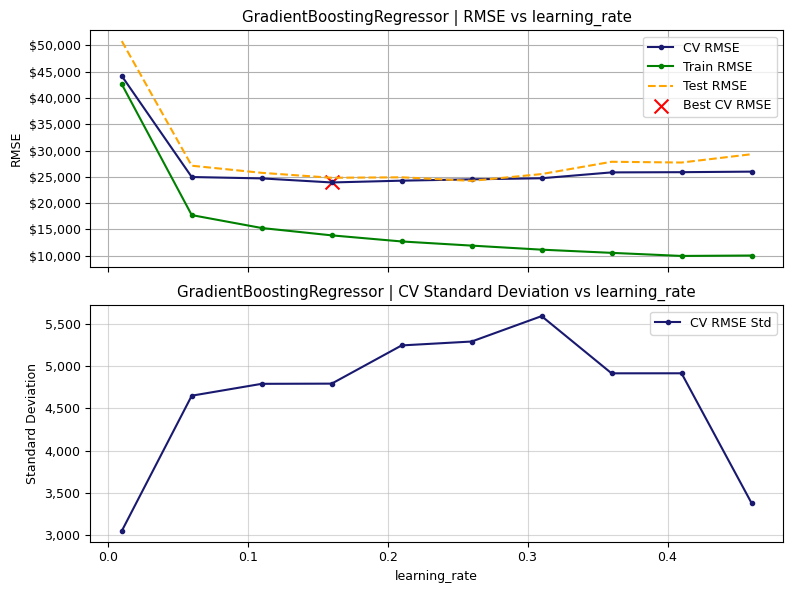

Execute successfully at: 2025-03-16 00:58:35
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=16, tm_hour=0, tm_min=58, tm_sec=35, tm_wday=6, tm_yday=75, tm_isdst=1)
Parameters: {'learning_rate': 0.16, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'Test_Param': 'learning_rate', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 23935.635, 'cv_repeats': 2, 'test_(R)MSE': 24827.651, 'execution_time': '00:00:16', 'timestamp': '2025-03-16 00:58:35'}


{'learning_rate': 0.16,
 'n_estimators': 100,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42,
 'Test_Param': 'learning_rate',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 23935.635,
 'cv_repeats': 2,
 'test_(R)MSE': 24827.651,
 'execution_time': '00:00:16',
 'timestamp': '2025-03-16 00:58:35'}

In [780]:
best_params_learningrate_3a = sweep_parameter(
    model           = model_3,
    Parameters      = Parameters_BT_3a,
    param           = 'learning_rate',
    parameter_list  = get_parameter_list('learning_rate'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_GradientBoosting['cv_repeats']
)

best_params_learningrate_3a

In [781]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_3a = update_clean_model_params(model_3, best_params_learningrate_3a.copy())
print(Parameters_BT_3a)

{'learning_rate': 0.16, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42}


#### 3a.2 n_estimators

Running GradientBoostingRegressor with n_estimators sweep...




Sweeping n_estimators:   6%|▋         | 1/16 [00:03<00:54,  3.61s/it]

n_estimators = 250: CV MSE = 23,696.255, Train MSE = 9,788.605, Test MSE = 24,888.630



Sweeping n_estimators:  12%|█▎        | 2/16 [00:08<01:00,  4.35s/it]

n_estimators = 300: CV MSE = 23,653.468, Train MSE = 8,923.682, Test MSE = 24,804.095



Sweeping n_estimators:  19%|█▉        | 3/16 [00:13<01:00,  4.64s/it]

n_estimators = 350: CV MSE = 23,617.825, Train MSE = 8,165.271, Test MSE = 24,816.797



Sweeping n_estimators:  25%|██▌       | 4/16 [00:19<00:59,  5.00s/it]

n_estimators = 400: CV MSE = 23,593.307, Train MSE = 7,525.979, Test MSE = 24,643.402



Sweeping n_estimators:  31%|███▏      | 5/16 [00:25<01:00,  5.47s/it]

n_estimators = 450: CV MSE = 23,600.384, Train MSE = 6,980.924, Test MSE = 24,616.306



Sweeping n_estimators:  38%|███▊      | 6/16 [00:32<00:59,  5.96s/it]

n_estimators = 500: CV MSE = 23,609.873, Train MSE = 6,481.843, Test MSE = 24,668.696



Sweeping n_estimators:  44%|████▍     | 7/16 [00:39<00:58,  6.51s/it]

n_estimators = 550: CV MSE = 23,615.912, Train MSE = 6,020.684, Test MSE = 24,672.685



Sweeping n_estimators:  50%|█████     | 8/16 [00:47<00:56,  7.01s/it]

n_estimators = 600: CV MSE = 23,628.424, Train MSE = 5,612.010, Test MSE = 24,662.242



Sweeping n_estimators:  56%|█████▋    | 9/16 [00:56<00:53,  7.65s/it]

n_estimators = 650: CV MSE = 23,621.127, Train MSE = 5,239.690, Test MSE = 24,685.624



Sweeping n_estimators:  62%|██████▎   | 10/16 [01:06<00:49,  8.23s/it]

n_estimators = 700: CV MSE = 23,631.961, Train MSE = 4,927.256, Test MSE = 24,738.322



Sweeping n_estimators:  69%|██████▉   | 11/16 [01:16<00:43,  8.77s/it]

n_estimators = 750: CV MSE = 23,635.156, Train MSE = 4,623.163, Test MSE = 24,736.949



Sweeping n_estimators:  75%|███████▌  | 12/16 [01:27<00:37,  9.34s/it]

n_estimators = 800: CV MSE = 23,647.033, Train MSE = 4,328.551, Test MSE = 24,786.765



Sweeping n_estimators:  81%|████████▏ | 13/16 [01:38<00:29,  9.92s/it]

n_estimators = 850: CV MSE = 23,658.527, Train MSE = 4,060.177, Test MSE = 24,810.479



Sweeping n_estimators:  88%|████████▊ | 14/16 [01:50<00:21, 10.54s/it]

n_estimators = 900: CV MSE = 23,656.792, Train MSE = 3,812.646, Test MSE = 24,830.847



Sweeping n_estimators:  94%|█████████▍| 15/16 [02:03<00:11, 11.19s/it]

n_estimators = 950: CV MSE = 23,665.183, Train MSE = 3,596.017, Test MSE = 24,867.300



Sweeping n_estimators: 100%|██████████| 16/16 [02:17<00:00,  8.57s/it]

n_estimators = 1000: CV MSE = 23,675.004, Train MSE = 3,387.136, Test MSE = 24,882.214


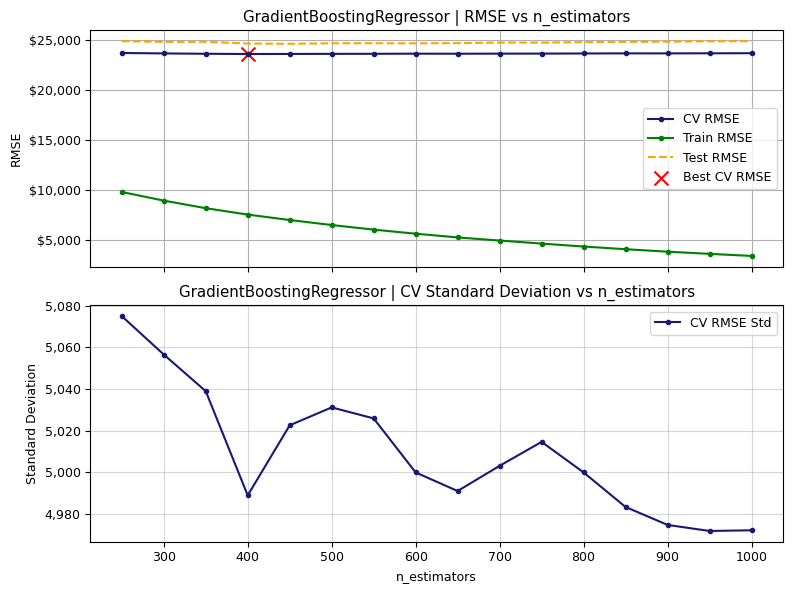

Execute successfully at: 2025-03-16 01:00:52
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=16, tm_hour=1, tm_min=0, tm_sec=52, tm_wday=6, tm_yday=75, tm_isdst=1)
Parameters: {'learning_rate': 0.16, 'n_estimators': 400, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'Test_Param': 'n_estimators', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 23593.307, 'cv_repeats': 2, 'test_(R)MSE': 24643.402, 'execution_time': '00:02:17', 'timestamp': '2025-03-16 01:00:52'}


{'learning_rate': 0.16,
 'n_estimators': 400,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42,
 'Test_Param': 'n_estimators',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 23593.307,
 'cv_repeats': 2,
 'test_(R)MSE': 24643.402,
 'execution_time': '00:02:17',
 'timestamp': '2025-03-16 01:00:52'}

In [782]:

best_params_estimators_3a = sweep_parameter(
    model           = model_3,
    Parameters      = Parameters_BT_3a,
    param           = 'n_estimators',
    parameter_list  = get_parameter_list('n_estimators', list(np.arange(250, 1001, 50))),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_GradientBoosting['cv_repeats']
)

best_params_estimators_3a

In [783]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_3a = update_clean_model_params(model_3, best_params_estimators_3a.copy())
Parameters_BT_3a

{'learning_rate': 0.16,
 'n_estimators': 400,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42}

#### 3a.3 max_depth

Running GradientBoostingRegressor with max_depth sweep...




Sweeping max_depth:   7%|▋         | 1/14 [00:10<02:17, 10.61s/it]

max_depth = None: CV MSE = 35,560.682, Train MSE = 0.000, Test MSE = 33,714.384



Sweeping max_depth:  14%|█▍        | 2/14 [00:14<01:19,  6.66s/it]

max_depth = 2: CV MSE = 24,195.687, Train MSE = 12,326.107, Test MSE = 27,254.909



Sweeping max_depth:  21%|██▏       | 3/14 [00:20<01:08,  6.23s/it]

max_depth = 3: CV MSE = 23,593.307, Train MSE = 7,525.979, Test MSE = 24,643.402



Sweeping max_depth:  29%|██▊       | 4/14 [00:27<01:06,  6.70s/it]

max_depth = 4: CV MSE = 24,420.201, Train MSE = 3,804.723, Test MSE = 27,457.658



Sweeping max_depth:  36%|███▌      | 5/14 [00:36<01:08,  7.59s/it]

max_depth = 5: CV MSE = 23,919.505, Train MSE = 1,493.171, Test MSE = 23,684.475



Sweeping max_depth:  43%|████▎     | 6/14 [00:47<01:09,  8.73s/it]

max_depth = 6: CV MSE = 25,023.562, Train MSE = 471.336, Test MSE = 23,854.031



Sweeping max_depth:  50%|█████     | 7/14 [01:00<01:10, 10.06s/it]

max_depth = 7: CV MSE = 25,807.629, Train MSE = 86.586, Test MSE = 24,488.814



Sweeping max_depth:  57%|█████▋    | 8/14 [01:14<01:08, 11.44s/it]

max_depth = 8: CV MSE = 26,747.248, Train MSE = 10.005, Test MSE = 24,440.724



Sweeping max_depth:  64%|██████▍   | 9/14 [01:31<01:04, 12.91s/it]

max_depth = 9: CV MSE = 28,596.917, Train MSE = 1.957, Test MSE = 25,466.615



Sweeping max_depth:  71%|███████▏  | 10/14 [01:48<00:57, 14.44s/it]

max_depth = 10: CV MSE = 29,601.691, Train MSE = 0.080, Test MSE = 27,582.168



Sweeping max_depth:  79%|███████▊  | 11/14 [02:08<00:47, 16.00s/it]

max_depth = 11: CV MSE = 30,773.590, Train MSE = 0.002, Test MSE = 29,312.330



Sweeping max_depth:  86%|████████▌ | 12/14 [02:29<00:35, 17.57s/it]

max_depth = 12: CV MSE = 32,026.262, Train MSE = 0.000, Test MSE = 30,040.808



Sweeping max_depth:  93%|█████████▎| 13/14 [02:52<00:19, 19.19s/it]

max_depth = 13: CV MSE = 32,882.299, Train MSE = 0.000, Test MSE = 31,158.233



Sweeping max_depth: 100%|██████████| 14/14 [03:13<00:00, 13.84s/it]

max_depth = 14: CV MSE = 34,050.780, Train MSE = 0.000, Test MSE = 31,641.451


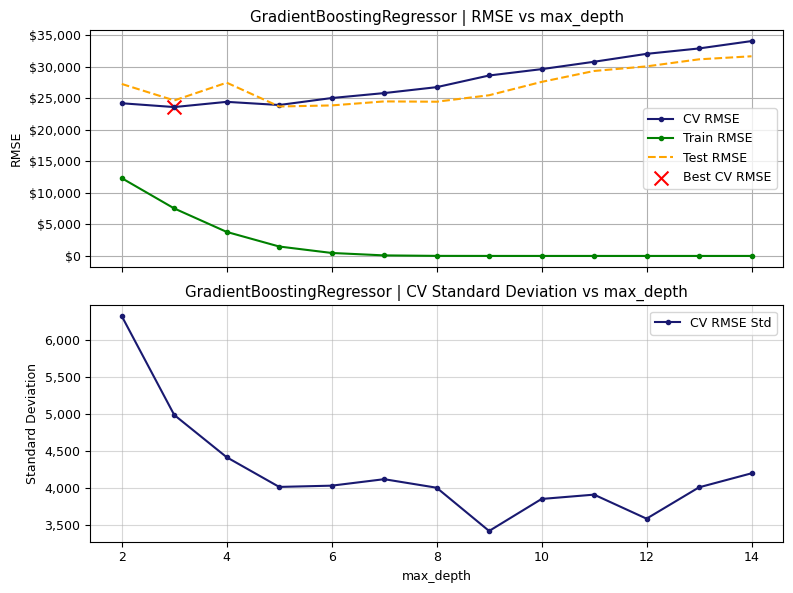

Execute successfully at: 2025-03-16 01:04:06
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=16, tm_hour=1, tm_min=4, tm_sec=6, tm_wday=6, tm_yday=75, tm_isdst=1)
Parameters: {'learning_rate': 0.16, 'n_estimators': 400, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'Test_Param': 'max_depth', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 23593.307, 'cv_repeats': 2, 'test_(R)MSE': 24643.402, 'execution_time': '00:03:13', 'timestamp': '2025-03-16 01:04:06'}


{'learning_rate': 0.16,
 'n_estimators': 400,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42,
 'Test_Param': 'max_depth',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 23593.307,
 'cv_repeats': 2,
 'test_(R)MSE': 24643.402,
 'execution_time': '00:03:13',
 'timestamp': '2025-03-16 01:04:06'}

In [784]:
best_params_max_depth_3a = sweep_parameter(
    model           = model_3,
    Parameters      = Parameters_BT_3a,
    param           = 'max_depth',
    parameter_list  = get_parameter_list('max_depth', [None] + list(np.arange(2, 15))),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_GradientBoosting['cv_repeats']
)

best_params_max_depth_3a

In [785]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_3a = update_clean_model_params(model_3, best_params_max_depth_3a.copy())
Parameters_BT_3a

{'learning_rate': 0.16,
 'n_estimators': 400,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42}

#### 3a.4 max_features

Running GradientBoostingRegressor with max_features sweep...




Sweeping max_features:   3%|▎         | 1/33 [00:00<00:20,  1.57it/s]

max_features = 3: CV MSE = 24,695.573, Train MSE = 11,344.031, Test MSE = 27,242.783



Sweeping max_features:   6%|▌         | 2/33 [00:01<00:20,  1.53it/s]

max_features = 4: CV MSE = 24,712.321, Train MSE = 10,563.954, Test MSE = 24,428.991



Sweeping max_features:   9%|▉         | 3/33 [00:02<00:22,  1.34it/s]

max_features = 5: CV MSE = 24,548.324, Train MSE = 10,391.058, Test MSE = 28,547.996



Sweeping max_features:  12%|█▏        | 4/33 [00:02<00:22,  1.29it/s]

max_features = 6: CV MSE = 23,595.738, Train MSE = 10,053.081, Test MSE = 23,650.067



Sweeping max_features:  15%|█▌        | 5/33 [00:03<00:22,  1.23it/s]

max_features = 7: CV MSE = 23,924.085, Train MSE = 9,745.926, Test MSE = 26,198.913



Sweeping max_features:  18%|█▊        | 6/33 [00:04<00:23,  1.14it/s]

max_features = 8: CV MSE = 23,737.098, Train MSE = 9,520.651, Test MSE = 26,510.275



Sweeping max_features:  21%|██        | 7/33 [00:05<00:24,  1.06it/s]

max_features = 9: CV MSE = 24,334.026, Train MSE = 9,641.371, Test MSE = 27,738.325



Sweeping max_features:  24%|██▍       | 8/33 [00:07<00:24,  1.01it/s]

max_features = 10: CV MSE = 23,834.556, Train MSE = 9,227.929, Test MSE = 27,478.219



Sweeping max_features:  27%|██▋       | 9/33 [00:08<00:25,  1.05s/it]

max_features = 11: CV MSE = 23,074.979, Train MSE = 9,216.081, Test MSE = 25,713.580



Sweeping max_features:  30%|███       | 10/33 [00:09<00:25,  1.10s/it]

max_features = 12: CV MSE = 23,693.532, Train MSE = 9,093.692, Test MSE = 26,808.552



Sweeping max_features:  33%|███▎      | 11/33 [00:10<00:26,  1.18s/it]

max_features = 13: CV MSE = 24,532.549, Train MSE = 8,771.032, Test MSE = 24,842.584



Sweeping max_features:  36%|███▋      | 12/33 [00:12<00:25,  1.24s/it]

max_features = 14: CV MSE = 24,177.334, Train MSE = 8,829.984, Test MSE = 27,130.016



Sweeping max_features:  39%|███▉      | 13/33 [00:13<00:26,  1.30s/it]

max_features = 15: CV MSE = 23,009.491, Train MSE = 8,767.752, Test MSE = 27,122.436



Sweeping max_features:  42%|████▏     | 14/33 [00:15<00:26,  1.37s/it]

max_features = 16: CV MSE = 24,056.948, Train MSE = 8,899.547, Test MSE = 26,624.087



Sweeping max_features:  45%|████▌     | 15/33 [00:16<00:25,  1.40s/it]

max_features = 17: CV MSE = 23,778.482, Train MSE = 8,762.120, Test MSE = 26,159.652



Sweeping max_features:  48%|████▊     | 16/33 [00:18<00:25,  1.50s/it]

max_features = 18: CV MSE = 23,864.019, Train MSE = 8,393.442, Test MSE = 26,047.859



Sweeping max_features:  52%|█████▏    | 17/33 [00:20<00:24,  1.56s/it]

max_features = 19: CV MSE = 23,755.810, Train MSE = 8,355.299, Test MSE = 24,719.422



Sweeping max_features:  55%|█████▍    | 18/33 [00:21<00:24,  1.64s/it]

max_features = 20: CV MSE = 24,082.747, Train MSE = 8,366.471, Test MSE = 27,127.496



Sweeping max_features:  58%|█████▊    | 19/33 [00:23<00:23,  1.70s/it]

max_features = 21: CV MSE = 23,923.671, Train MSE = 8,314.374, Test MSE = 27,007.633



Sweeping max_features:  61%|██████    | 20/33 [00:25<00:23,  1.79s/it]

max_features = 22: CV MSE = 24,053.240, Train MSE = 8,353.236, Test MSE = 26,995.350



Sweeping max_features:  64%|██████▎   | 21/33 [00:27<00:22,  1.84s/it]

max_features = 23: CV MSE = 24,162.915, Train MSE = 8,273.030, Test MSE = 27,007.702



Sweeping max_features:  67%|██████▋   | 22/33 [00:29<00:21,  1.92s/it]

max_features = 24: CV MSE = 24,144.257, Train MSE = 8,309.638, Test MSE = 27,372.635



Sweeping max_features:  70%|██████▉   | 23/33 [00:31<00:19,  1.98s/it]

max_features = 25: CV MSE = 24,446.879, Train MSE = 8,332.658, Test MSE = 26,717.469



Sweeping max_features:  73%|███████▎  | 24/33 [00:34<00:18,  2.10s/it]

max_features = 26: CV MSE = 23,073.899, Train MSE = 8,407.540, Test MSE = 26,000.487



Sweeping max_features:  76%|███████▌  | 25/33 [00:36<00:17,  2.16s/it]

max_features = 27: CV MSE = 24,005.830, Train MSE = 8,108.429, Test MSE = 28,235.369



Sweeping max_features:  79%|███████▉  | 26/33 [00:38<00:15,  2.23s/it]

max_features = 28: CV MSE = 24,286.326, Train MSE = 8,058.880, Test MSE = 29,354.754



Sweeping max_features:  82%|████████▏ | 27/33 [00:41<00:13,  2.28s/it]

max_features = 29: CV MSE = 23,530.553, Train MSE = 7,868.411, Test MSE = 28,036.618



Sweeping max_features:  85%|████████▍ | 28/33 [00:43<00:11,  2.33s/it]

max_features = 30: CV MSE = 24,099.272, Train MSE = 7,940.669, Test MSE = 26,620.230



Sweeping max_features:  88%|████████▊ | 29/33 [00:46<00:09,  2.41s/it]

max_features = 31: CV MSE = 23,763.153, Train MSE = 7,961.903, Test MSE = 28,172.304



Sweeping max_features:  91%|█████████ | 30/33 [00:49<00:07,  2.49s/it]

max_features = 32: CV MSE = 23,604.206, Train MSE = 8,118.428, Test MSE = 26,796.398



Sweeping max_features:  94%|█████████▍| 31/33 [00:51<00:05,  2.55s/it]

max_features = 33: CV MSE = 24,350.241, Train MSE = 7,784.453, Test MSE = 27,365.852



Sweeping max_features:  97%|█████████▋| 32/33 [00:54<00:02,  2.61s/it]

max_features = 34: CV MSE = 23,498.205, Train MSE = 8,045.649, Test MSE = 25,988.049



Sweeping max_features: 100%|██████████| 33/33 [00:57<00:00,  1.74s/it]

max_features = 35: CV MSE = 24,108.892, Train MSE = 7,835.706, Test MSE = 26,104.802


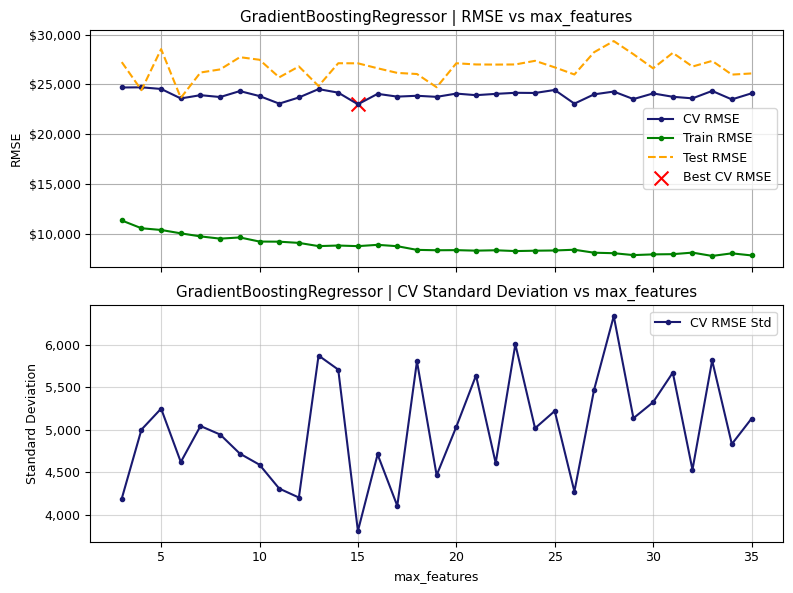

Execute successfully at: 2025-03-16 01:05:04
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=16, tm_hour=1, tm_min=5, tm_sec=4, tm_wday=6, tm_yday=75, tm_isdst=1)
Parameters: {'learning_rate': 0.16, 'n_estimators': 400, 'max_depth': 3, 'max_features': 15, 'random_state': 42, 'Test_Param': 'max_features', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 23009.491, 'cv_repeats': 2, 'test_(R)MSE': 27122.436, 'execution_time': '00:00:57', 'timestamp': '2025-03-16 01:05:04'}


{'learning_rate': 0.16,
 'n_estimators': 400,
 'max_depth': 3,
 'max_features': 15,
 'random_state': 42,
 'Test_Param': 'max_features',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 23009.491,
 'cv_repeats': 2,
 'test_(R)MSE': 27122.436,
 'execution_time': '00:00:57',
 'timestamp': '2025-03-16 01:05:04'}

In [786]:
best_params_max_features_3a = sweep_parameter(
    model           = model_3,
    Parameters      = Parameters_BT_3a,
    param           = 'max_features',
    parameter_list  = get_parameter_list('max_features',list(np.arange(3, 36, 1)), X_train),

    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_GradientBoosting['cv_repeats']
)

best_params_max_features_3a

In [787]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_3a = update_clean_model_params(model_3, best_params_max_features_3a.copy())
Parameters_BT_3a

{'learning_rate': 0.16,
 'n_estimators': 400,
 'max_depth': 3,
 'max_features': 15,
 'random_state': 42}

#### 3a. Summary

In [788]:
ensemble_df_columns[model_3.__name__]

['Model',
 'Test_Param',
 'cv_repeats',
 '(R)MSE_found',
 'test_(R)MSE',
 'n_estimators',
 'learning_rate',
 'max_depth',
 'max_features',
 'bootstrap',
 'execution_time',
 'timestamp']

In [789]:
summary_df_3a = pd.DataFrame([dict_baseline_3a,
                            best_params_learningrate_3a, 
                            best_params_estimators_3a, 
                            best_params_max_depth_3a, 
                            best_params_max_features_3a
                            ],
                            columns = ensemble_df_columns[model_3.__name__]
                        )
summary_df_3a = df_format_dropDuplicateRows(summary_df_3a)
summary_df_3a

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,learning_rate,max_depth,max_features,bootstrap,execution_time,timestamp
0,GradientBoostingRegressor,Baseline_3a,2,24008.425,26532.469,100,0.1,3,None,None,00:00:03,2025-03-16 00:58:19
1,GradientBoostingRegressor,learning_rate,2,23935.635,24827.651,100,0.16,3,None,None,00:00:16,2025-03-16 00:58:35
2,GradientBoostingRegressor,n_estimators,2,23593.307,24643.402,400,0.16,3,None,None,00:02:17,2025-03-16 01:00:52
3,GradientBoostingRegressor,max_depth,2,23593.307,24643.402,400,0.16,3,None,None,00:03:13,2025-03-16 01:04:06
4,GradientBoostingRegressor,max_features,2,23009.491,27122.436,400,0.16,3,15.0,None,00:00:57,2025-03-16 01:05:04


### Problem 3.A Graded Answer

In [790]:
# TODO:  Set the variable to best CV RMSE score found after Part 3.A

a3a = summary_df_3a['(R)MSE_found'].min()                                # Just to get it to run without error; your answer here (remember to use the RMSE)         

print(f'a3a = ${a3a:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3a = $23,009.49


### **Part 3.B: Refine Parameters for Model Stability**  


In [791]:
Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'random_state'            : 42,              # Controls randomness of boosting. Useful for reproducibility.
    '(R)MSE_found'            : float('inf'),     # NOT a parameter, but will record the MSE found for the current parameter choices
    'cv_repeats'              : 10
}


#### 3b.0 Baseline

In [792]:
Default_Parameters_GradientBoosting_baseline = Default_Parameters_GradientBoosting.copy()
Default_Parameters_GradientBoosting_baseline = update_clean_model_params(model_3, 
                                                         Default_Parameters_GradientBoosting_baseline
                                                         )

start = time.time()

mean_cv_mse, std_cv_mse, train_mse, test_mse = run_model(model_3, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test, 
                                                         n_repeats  = Default_Parameters_GradientBoosting['cv_repeats'],
                                                         n_jobs     = -1,
                                                         exp_factor = 0.5,  # Square root of MSE
                                                         **Default_Parameters_GradientBoosting_baseline
                                                        )

# exp_factor = 0.5
end                                 = time.time()
execution_time                      = format_hms(end - start)
timestamp                           = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))

dict_baseline_3b = {
    'mean_CV_(R)MSE':   mean_cv_mse,
    'std_CV_(R)MSE':    std_cv_mse,
    'train_(R)MSE':     train_mse,
    'test_(R)MSE':      test_mse,
    '(R)MSE_found':     mean_cv_mse,
    'cv_repeats':       Default_Parameters_GradientBoosting['cv_repeats'],
    'learning_rate':    Default_Parameters_GradientBoosting_baseline['learning_rate'],
    'n_estimators':     Default_Parameters_GradientBoosting_baseline['n_estimators'],
    'max_depth':        Default_Parameters_GradientBoosting_baseline['max_depth'],
    'max_features':     Default_Parameters_GradientBoosting_baseline['max_features'],
    'Model':            model_3.__name__,
    'Test_Param':       'Baseline_3b',
    'execution_time':   execution_time,
    'timestamp':        timestamp
}

print("Baseline results for GradientBoostingRegressor:\n", dict_baseline_3b)
dict_baseline_3b

Baseline results for GradientBoostingRegressor:
 {'mean_CV_(R)MSE': 24136.061, 'std_CV_(R)MSE': 3847.36, 'train_(R)MSE': 15698.48, 'test_(R)MSE': 26532.469, '(R)MSE_found': 24136.061, 'cv_repeats': 10, 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'Model': 'GradientBoostingRegressor', 'Test_Param': 'Baseline_3b', 'execution_time': '00:00:04', 'timestamp': '2025-03-16 01:05:08'}


{'mean_CV_(R)MSE': 24136.061,
 'std_CV_(R)MSE': 3847.36,
 'train_(R)MSE': 15698.48,
 'test_(R)MSE': 26532.469,
 '(R)MSE_found': 24136.061,
 'cv_repeats': 10,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'max_depth': 3,
 'max_features': None,
 'Model': 'GradientBoostingRegressor',
 'Test_Param': 'Baseline_3b',
 'execution_time': '00:00:04',
 'timestamp': '2025-03-16 01:05:08'}

In [793]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_3b = update_clean_model_params(model_3, Default_Parameters_GradientBoosting.copy())
print(Parameters_BT_3b)

{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42}


#### 3b.1 Learning Rate

Running GradientBoostingRegressor with learning_rate sweep...




Sweeping learning_rate:  10%|█         | 1/10 [00:04<00:39,  4.38s/it]

learning_rate = 0.01: CV MSE = 44,338.709, Train MSE = 42,633.733, Test MSE = 50,839.749



Sweeping learning_rate:  20%|██        | 2/10 [00:08<00:35,  4.44s/it]

learning_rate = 0.060000000000000005: CV MSE = 24,864.814, Train MSE = 17,724.920, Test MSE = 27,122.231



Sweeping learning_rate:  30%|███       | 3/10 [00:13<00:30,  4.40s/it]

learning_rate = 0.11: CV MSE = 24,163.319, Train MSE = 15,267.406, Test MSE = 25,766.575



Sweeping learning_rate:  40%|████      | 4/10 [00:17<00:26,  4.37s/it]

learning_rate = 0.16: CV MSE = 23,915.231, Train MSE = 13,868.451, Test MSE = 24,827.651



Sweeping learning_rate:  50%|█████     | 5/10 [00:21<00:21,  4.30s/it]

learning_rate = 0.21000000000000002: CV MSE = 24,366.523, Train MSE = 12,708.512, Test MSE = 24,916.529



Sweeping learning_rate:  60%|██████    | 6/10 [00:25<00:17,  4.27s/it]

learning_rate = 0.26: CV MSE = 24,456.225, Train MSE = 11,918.579, Test MSE = 24,238.718



Sweeping learning_rate:  70%|███████   | 7/10 [00:30<00:12,  4.25s/it]

learning_rate = 0.31: CV MSE = 24,635.881, Train MSE = 11,147.082, Test MSE = 25,531.403



Sweeping learning_rate:  80%|████████  | 8/10 [00:34<00:08,  4.28s/it]

learning_rate = 0.36000000000000004: CV MSE = 25,021.586, Train MSE = 10,539.676, Test MSE = 27,871.115



Sweeping learning_rate:  90%|█████████ | 9/10 [00:38<00:04,  4.25s/it]

learning_rate = 0.41000000000000003: CV MSE = 25,748.235, Train MSE = 9,953.058, Test MSE = 27,728.554



Sweeping learning_rate: 100%|██████████| 10/10 [00:42<00:00,  4.30s/it]

learning_rate = 0.46: CV MSE = 26,179.486, Train MSE = 10,032.860, Test MSE = 29,308.979


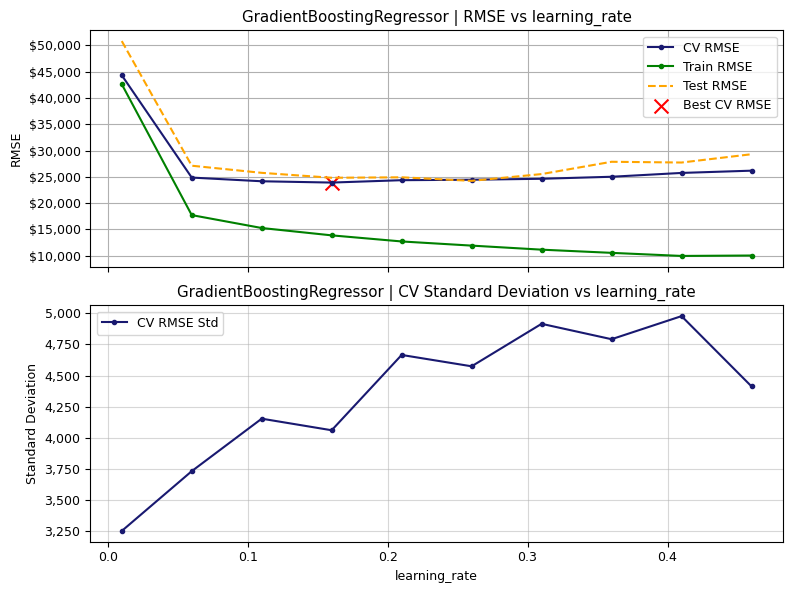

Execute successfully at: 2025-03-16 01:05:51
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=16, tm_hour=1, tm_min=5, tm_sec=51, tm_wday=6, tm_yday=75, tm_isdst=1)
Parameters: {'learning_rate': 0.16, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'Test_Param': 'learning_rate', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 23915.231, 'cv_repeats': 10, 'test_(R)MSE': 24827.651, 'execution_time': '00:00:42', 'timestamp': '2025-03-16 01:05:51'}


{'learning_rate': 0.16,
 'n_estimators': 100,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42,
 'Test_Param': 'learning_rate',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 23915.231,
 'cv_repeats': 10,
 'test_(R)MSE': 24827.651,
 'execution_time': '00:00:42',
 'timestamp': '2025-03-16 01:05:51'}

In [794]:

best_params_learningrate_3b = sweep_parameter(
    model           = model_3,
    Parameters      = Parameters_BT_3b,
    param           = 'learning_rate',
    parameter_list  = get_parameter_list('learning_rate'),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_GradientBoosting['cv_repeats']
)

best_params_learningrate_3b

In [795]:

Parameters_BT_3b = update_clean_model_params(model_3, best_params_learningrate_3b.copy())
print(Parameters_BT_3b)

{'learning_rate': 0.16, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42}


#### 3b.2 n_estimators

Running GradientBoostingRegressor with n_estimators sweep...




Sweeping n_estimators:   9%|▉         | 1/11 [00:14<02:29, 14.91s/it]

n_estimators = 350: CV MSE = 23,515.636, Train MSE = 8,165.271, Test MSE = 24,816.797



Sweeping n_estimators:  18%|█▊        | 2/11 [00:29<02:14, 14.97s/it]

n_estimators = 360: CV MSE = 23,514.166, Train MSE = 8,027.702, Test MSE = 24,804.123



Sweeping n_estimators:  27%|██▋       | 3/11 [00:45<02:01, 15.13s/it]

n_estimators = 370: CV MSE = 23,508.217, Train MSE = 7,900.833, Test MSE = 24,723.859



Sweeping n_estimators:  36%|███▋      | 4/11 [01:01<01:49, 15.58s/it]

n_estimators = 380: CV MSE = 23,510.773, Train MSE = 7,786.855, Test MSE = 24,704.125



Sweeping n_estimators:  45%|████▌     | 5/11 [01:18<01:37, 16.18s/it]

n_estimators = 390: CV MSE = 23,514.338, Train MSE = 7,630.678, Test MSE = 24,711.001



Sweeping n_estimators:  55%|█████▍    | 6/11 [01:36<01:23, 16.72s/it]

n_estimators = 400: CV MSE = 23,508.692, Train MSE = 7,525.979, Test MSE = 24,643.402



Sweeping n_estimators:  64%|██████▎   | 7/11 [01:54<01:09, 17.27s/it]

n_estimators = 410: CV MSE = 23,511.919, Train MSE = 7,434.162, Test MSE = 24,634.430



Sweeping n_estimators:  73%|███████▎  | 8/11 [02:13<00:52, 17.64s/it]

n_estimators = 420: CV MSE = 23,509.784, Train MSE = 7,274.938, Test MSE = 24,671.320



Sweeping n_estimators:  82%|████████▏ | 9/11 [02:32<00:35, 18.00s/it]

n_estimators = 430: CV MSE = 23,518.019, Train MSE = 7,162.160, Test MSE = 24,636.853



Sweeping n_estimators:  91%|█████████ | 10/11 [02:51<00:18, 18.44s/it]

n_estimators = 440: CV MSE = 23,513.264, Train MSE = 7,070.996, Test MSE = 24,606.635



Sweeping n_estimators: 100%|██████████| 11/11 [03:11<00:00, 17.39s/it]

n_estimators = 450: CV MSE = 23,516.017, Train MSE = 6,980.924, Test MSE = 24,616.306


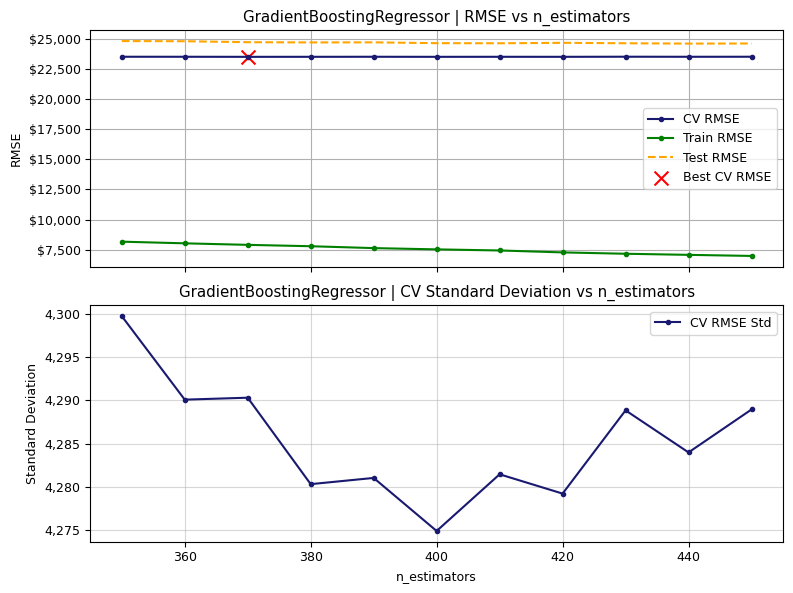

Execute successfully at: 2025-03-16 01:09:03
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=16, tm_hour=1, tm_min=9, tm_sec=3, tm_wday=6, tm_yday=75, tm_isdst=1)
Parameters: {'learning_rate': 0.16, 'n_estimators': 370, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'Test_Param': 'n_estimators', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 23508.217, 'cv_repeats': 10, 'test_(R)MSE': 24723.859, 'execution_time': '00:03:11', 'timestamp': '2025-03-16 01:09:03'}


{'learning_rate': 0.16,
 'n_estimators': 370,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42,
 'Test_Param': 'n_estimators',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 23508.217,
 'cv_repeats': 10,
 'test_(R)MSE': 24723.859,
 'execution_time': '00:03:11',
 'timestamp': '2025-03-16 01:09:03'}

In [796]:
best_params_estimators_3b = sweep_parameter(
    model           = model_3,
    Parameters      = Parameters_BT_3b,
    param           = 'n_estimators',
    parameter_list  = get_parameter_list('n_estimators', list(np.arange(350, 451, 10))),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_GradientBoosting['cv_repeats']
)

best_params_estimators_3b

In [797]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_3b = update_clean_model_params(model_3, best_params_estimators_3b.copy())
Parameters_BT_3b

{'learning_rate': 0.16,
 'n_estimators': 370,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42}

#### 3b.3 max_depth

Running GradientBoostingRegressor with max_depth sweep...




Sweeping max_depth:  10%|█         | 1/10 [00:33<05:05, 33.90s/it]

max_depth = None: CV MSE = 36,285.229, Train MSE = 0.000, Test MSE = 33,714.384



Sweeping max_depth:  20%|██        | 2/10 [00:45<02:46, 20.77s/it]

max_depth = 2: CV MSE = 23,553.054, Train MSE = 12,635.060, Test MSE = 27,287.988



Sweeping max_depth:  30%|███       | 3/10 [01:01<02:09, 18.53s/it]

max_depth = 3: CV MSE = 23,508.217, Train MSE = 7,900.833, Test MSE = 24,723.859



Sweeping max_depth:  40%|████      | 4/10 [01:21<01:54, 19.07s/it]

max_depth = 4: CV MSE = 24,190.726, Train MSE = 4,160.117, Test MSE = 27,432.158



Sweeping max_depth:  50%|█████     | 5/10 [01:46<01:45, 21.16s/it]

max_depth = 5: CV MSE = 24,201.653, Train MSE = 1,748.347, Test MSE = 23,675.410



Sweeping max_depth:  60%|██████    | 6/10 [02:15<01:35, 24.00s/it]

max_depth = 6: CV MSE = 25,096.763, Train MSE = 584.777, Test MSE = 23,849.611



Sweeping max_depth:  70%|███████   | 7/10 [02:50<01:22, 27.55s/it]

max_depth = 7: CV MSE = 25,927.151, Train MSE = 124.669, Test MSE = 24,490.305



Sweeping max_depth:  80%|████████  | 8/10 [03:30<01:02, 31.39s/it]

max_depth = 8: CV MSE = 26,932.652, Train MSE = 16.361, Test MSE = 24,441.037



Sweeping max_depth:  90%|█████████ | 9/10 [04:16<00:35, 35.94s/it]

max_depth = 9: CV MSE = 28,373.346, Train MSE = 3.317, Test MSE = 25,466.601



Sweeping max_depth: 100%|██████████| 10/10 [05:08<00:00, 30.88s/it]

max_depth = 10: CV MSE = 29,629.639, Train MSE = 0.157, Test MSE = 27,582.166


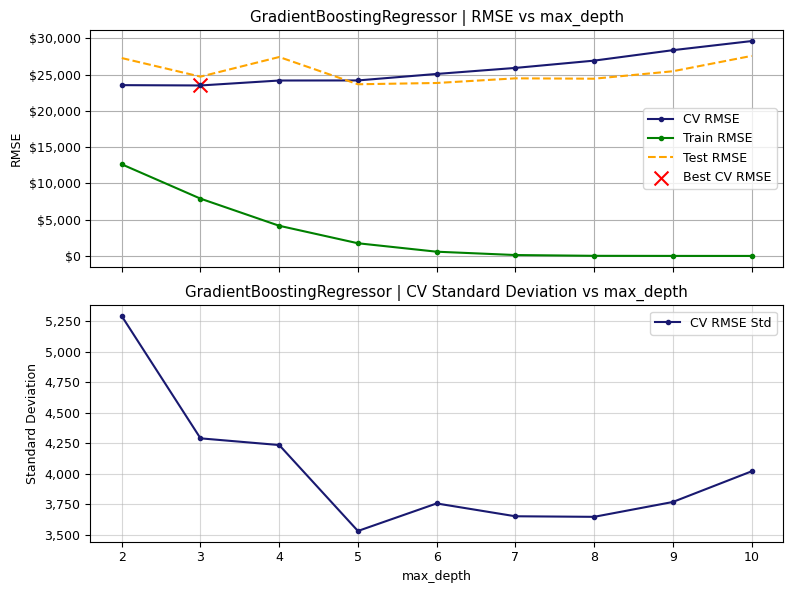

Execute successfully at: 2025-03-16 01:14:12
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=16, tm_hour=1, tm_min=14, tm_sec=12, tm_wday=6, tm_yday=75, tm_isdst=1)
Parameters: {'learning_rate': 0.16, 'n_estimators': 370, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'Test_Param': 'max_depth', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 23508.217, 'cv_repeats': 10, 'test_(R)MSE': 24723.859, 'execution_time': '00:05:08', 'timestamp': '2025-03-16 01:14:12'}


{'learning_rate': 0.16,
 'n_estimators': 370,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42,
 'Test_Param': 'max_depth',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 23508.217,
 'cv_repeats': 10,
 'test_(R)MSE': 24723.859,
 'execution_time': '00:05:08',
 'timestamp': '2025-03-16 01:14:12'}

In [798]:
best_params_max_depth_3b = sweep_parameter(
    model           = model_3,
    Parameters      = Parameters_BT_3b,
    param           = 'max_depth',
    parameter_list  = [None] + list(range(2, 11)),
    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_GradientBoosting['cv_repeats']
)

best_params_max_depth_3b

In [799]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_3b = update_clean_model_params(model_3, best_params_max_depth_3b.copy())
Parameters_BT_3b

{'learning_rate': 0.16,
 'n_estimators': 370,
 'max_depth': 3,
 'max_features': None,
 'random_state': 42}

#### 3b.4 max_features

Running GradientBoostingRegressor with max_features sweep...




Sweeping max_features:   4%|▍         | 1/25 [00:17<06:48, 17.03s/it]

max_features = None: CV MSE = 23,508.217, Train MSE = 7,900.833, Test MSE = 24,723.859



Sweeping max_features:   8%|▊         | 2/25 [00:18<02:58,  7.75s/it]

max_features = 2: CV MSE = 24,944.027, Train MSE = 12,785.071, Test MSE = 26,404.233



Sweeping max_features:  12%|█▏        | 3/25 [00:19<01:48,  4.93s/it]

max_features = 3: CV MSE = 24,359.088, Train MSE = 11,678.020, Test MSE = 27,251.574



Sweeping max_features:  16%|█▌        | 4/25 [00:21<01:16,  3.65s/it]

max_features = 4: CV MSE = 24,655.327, Train MSE = 10,881.403, Test MSE = 24,520.479



Sweeping max_features:  20%|██        | 5/25 [00:23<01:00,  3.05s/it]

max_features = 5: CV MSE = 24,155.191, Train MSE = 10,793.813, Test MSE = 28,661.649



Sweeping max_features:  24%|██▍       | 6/25 [00:25<00:52,  2.74s/it]

max_features = 6: CV MSE = 24,116.318, Train MSE = 10,395.831, Test MSE = 23,740.357



Sweeping max_features:  28%|██▊       | 7/25 [00:28<00:50,  2.78s/it]

max_features = 7: CV MSE = 24,281.332, Train MSE = 10,098.170, Test MSE = 26,147.112



Sweeping max_features:  32%|███▏      | 8/25 [00:31<00:46,  2.74s/it]

max_features = 8: CV MSE = 23,785.832, Train MSE = 9,838.671, Test MSE = 26,501.882



Sweeping max_features:  36%|███▌      | 9/25 [00:34<00:44,  2.78s/it]

max_features = 9: CV MSE = 24,043.932, Train MSE = 10,093.458, Test MSE = 27,691.444



Sweeping max_features:  40%|████      | 10/25 [00:37<00:43,  2.88s/it]

max_features = 10: CV MSE = 23,618.318, Train MSE = 9,618.448, Test MSE = 27,558.255



Sweeping max_features:  44%|████▍     | 11/25 [00:40<00:42,  3.01s/it]

max_features = 11: CV MSE = 23,039.208, Train MSE = 9,610.712, Test MSE = 25,727.345



Sweeping max_features:  48%|████▊     | 12/25 [00:44<00:41,  3.18s/it]

max_features = 12: CV MSE = 23,498.755, Train MSE = 9,466.403, Test MSE = 26,925.387



Sweeping max_features:  52%|█████▏    | 13/25 [00:47<00:40,  3.35s/it]

max_features = 13: CV MSE = 24,083.975, Train MSE = 9,151.567, Test MSE = 24,866.470



Sweeping max_features:  56%|█████▌    | 14/25 [00:52<00:40,  3.72s/it]

max_features = 14: CV MSE = 23,517.654, Train MSE = 9,341.094, Test MSE = 27,097.785



Sweeping max_features:  60%|██████    | 15/25 [00:56<00:38,  3.86s/it]

max_features = 15: CV MSE = 23,282.493, Train MSE = 9,115.615, Test MSE = 27,207.308



Sweeping max_features:  64%|██████▍   | 16/25 [01:00<00:36,  4.02s/it]

max_features = 16: CV MSE = 23,732.605, Train MSE = 9,252.376, Test MSE = 26,634.128



Sweeping max_features:  68%|██████▊   | 17/25 [01:05<00:33,  4.20s/it]

max_features = 17: CV MSE = 23,461.536, Train MSE = 9,159.771, Test MSE = 26,140.415



Sweeping max_features:  72%|███████▏  | 18/25 [01:10<00:31,  4.44s/it]

max_features = 18: CV MSE = 23,640.163, Train MSE = 8,731.354, Test MSE = 26,068.945



Sweeping max_features:  76%|███████▌  | 19/25 [01:15<00:27,  4.63s/it]

max_features = 19: CV MSE = 23,877.879, Train MSE = 8,718.419, Test MSE = 24,670.726



Sweeping max_features:  80%|████████  | 20/25 [01:20<00:23,  4.79s/it]

max_features = 20: CV MSE = 23,548.472, Train MSE = 8,764.132, Test MSE = 27,069.880



Sweeping max_features:  84%|████████▍ | 21/25 [01:26<00:19,  4.98s/it]

max_features = 21: CV MSE = 23,778.699, Train MSE = 8,660.126, Test MSE = 26,889.398



Sweeping max_features:  88%|████████▊ | 22/25 [01:32<00:15,  5.29s/it]

max_features = 22: CV MSE = 23,634.538, Train MSE = 8,729.283, Test MSE = 26,937.573



Sweeping max_features:  92%|█████████▏| 23/25 [01:38<00:10,  5.47s/it]

max_features = 23: CV MSE = 23,647.579, Train MSE = 8,655.586, Test MSE = 27,021.424



Sweeping max_features:  96%|█████████▌| 24/25 [01:44<00:05,  5.64s/it]

max_features = 24: CV MSE = 23,700.370, Train MSE = 8,683.970, Test MSE = 27,349.654



Sweeping max_features: 100%|██████████| 25/25 [01:50<00:00,  4.42s/it]

max_features = 25: CV MSE = 23,568.621, Train MSE = 8,690.466, Test MSE = 26,650.048


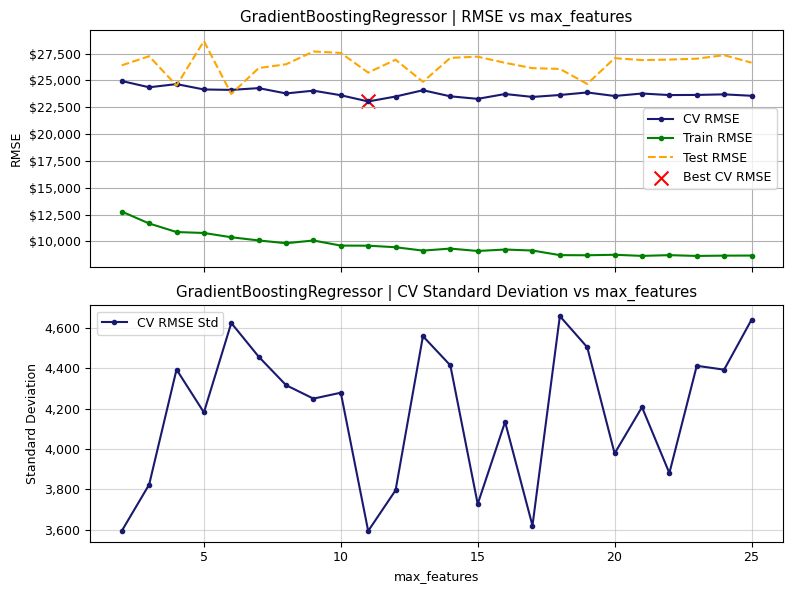

Execute successfully at: 2025-03-16 01:16:03
time.localtime(end): time.struct_time(tm_year=2025, tm_mon=3, tm_mday=16, tm_hour=1, tm_min=16, tm_sec=3, tm_wday=6, tm_yday=75, tm_isdst=1)
Parameters: {'learning_rate': 0.16, 'n_estimators': 370, 'max_depth': 3, 'max_features': 11, 'random_state': 42, 'Test_Param': 'max_features', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 23039.208, 'cv_repeats': 10, 'test_(R)MSE': 25727.345, 'execution_time': '00:01:50', 'timestamp': '2025-03-16 01:16:03'}


{'learning_rate': 0.16,
 'n_estimators': 370,
 'max_depth': 3,
 'max_features': 11,
 'random_state': 42,
 'Test_Param': 'max_features',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 23039.208,
 'cv_repeats': 10,
 'test_(R)MSE': 25727.345,
 'execution_time': '00:01:50',
 'timestamp': '2025-03-16 01:16:03'}

In [800]:
best_params_max_features_3b = sweep_parameter(
    model           = model_3,
    Parameters      = Parameters_BT_3b,
    param           = 'max_features',
    # parameter_list  = get_parameter_list('max_features', X_train),
    parameter_list  = [None] + list(range(2, 26)),

    X_train         = X_train,
    y_train         = y_train,
    X_test          = X_test,
    y_test          = y_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = Default_Parameters_GradientBoosting['cv_repeats']
)

best_params_max_features_3b

In [801]:
## Removing from the parameters dictionary any keys that are not valid parameters for the model, e.g., 'RMSE_found' ##

Parameters_BT_3b = update_clean_model_params(model_3, best_params_max_features_3b.copy())
Parameters_BT_3b

{'learning_rate': 0.16,
 'n_estimators': 370,
 'max_depth': 3,
 'max_features': 11,
 'random_state': 42}

#### 3b. Summary

In [802]:
summary_df_3b = pd.DataFrame([dict_baseline_3b,
                            best_params_learningrate_3b, 
                            best_params_estimators_3b, 
                            best_params_max_depth_3b, 
                            best_params_max_features_3b
                            ],
                            columns = ensemble_df_columns[model_3.__name__]
                        )
summary_df_3b = df_format_dropDuplicateRows(summary_df_3b)
summary_df_3b



,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,learning_rate,max_depth,max_features,bootstrap,execution_time,timestamp
0,GradientBoostingRegressor,Baseline_3b,10,24136.061,26532.469,100,0.1,3,None,None,00:00:04,2025-03-16 01:05:08
1,GradientBoostingRegressor,learning_rate,10,23915.231,24827.651,100,0.16,3,None,None,00:00:42,2025-03-16 01:05:51
2,GradientBoostingRegressor,n_estimators,10,23508.217,24723.859,370,0.16,3,None,None,00:03:11,2025-03-16 01:09:03
3,GradientBoostingRegressor,max_depth,10,23508.217,24723.859,370,0.16,3,None,None,00:05:08,2025-03-16 01:14:12
4,GradientBoostingRegressor,max_features,10,23039.208,25727.345,370,0.16,3,11.0,None,00:01:50,2025-03-16 01:16:03


### Problem 3.B Graded Answer

In [803]:
# TODO:  Set the variable to best CV RMSE score found after Part 3.B (it may not be different than Part 3.A)

a3b = summary_df_3b['(R)MSE_found'].min()                              # Just to get it to run without error; your answer here           

print(f'a3b = ${a3b:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3b = $23,039.21


### **Part 3.C: Use `GridSearchCV` for Exhaustive Search**  

#### 3C. RandomizedSearchCV

In [808]:
param_dist = {
    'learning_rate':    np.arange(0.1,.21,0.01),
    'n_estimators':     get_parameter_list('n_estimators'),  #list(np.arange(380, 421, 5))               
    'max_depth' :       get_parameter_list('max_depth'),   #Pro Tip: Avoid setting this too high, or to None, as it can lead to overfitting and increased computation time.
    'max_features':     get_parameter_list('max_features', list(np.arange(2, 26)), X_train),  
    # 'bootstrap'   : get_parameter_list('bootstrap'),  
}


best_params_randomsearch_3c_df = run_GridSearch_RandomizedSearch_CV(
    ensemble_model      = model_3, 
    parameter_grid      = param_dist, 
    randomized_search   = True,
    show_RMSE           = True,
    X_train             = X_train,
    y_train             = y_train,
    iterations          = 10,
    n_jobs              = -1,
    verbose             = True,
    n_repeats           = 10,
    cv_folds            = 5,
    random_state        = 42
    )

best_params_randomsearch_3c_df

Using RandomizedSearchCV............................................
results_df.columns:
 Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_max_features', 'param_max_depth',
       'param_learning_rate', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

Search Results (Top 10):

n_estimators max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score
         300            8      21998.182      8945.281         10431.687         1408.337
         750           19      23691.631     10234.556             0.295            0.204
         950           10      24921.799      9197.894    

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,learning_rate,max_depth,max_features,bootstrap,execution_time,timestamp
0,GradientBoostingRegressor,RandomizedSearchCV,10,21998.1818,25093.917,300,0.14,3,8,None,00:00:13,2025-03-16 09:57:04


#### 3C. GridSearchCV

In [ ]:
param_dist = {
    'learning_rate':    np.arange(0.1,.21, 0.01),
    'n_estimators':     get_parameter_list('n_estimators'),  #list(np.arange(380, 421, 5))               
    'max_depth' :       get_parameter_list('max_depth', list(np.arange(2, 26))),   #Pro Tip: Avoid setting this too high, or to None, as it can lead to overfitting and increased computation time.
    'max_features':     get_parameter_list('max_features', list(np.arange(2, 26)), X_train),  
    # 'bootstrap'   : get_parameter_list('bootstrap'),  
}


best_params_gridsearch_3c_df = run_GridSearch_RandomizedSearch_CV(
                                ensemble_model      = model_3, 
                                parameter_grid      = param_dist, 
                                randomized_search   = False,
                                show_RMSE           = True,
                                X_train             = X_train,
                                y_train             = y_train,
                                iterations          = 10,
                                n_jobs              = -1,
                                verbose             = True,
                                n_repeats           = 10,
                                cv_folds            = 5,
                                random_state        = 42

)

best_params_gridsearch_3c_df

Using GridSearchCV............................................


KeyboardInterrupt: 

In [ ]:
results_list = []
results_list.append(best_params_randomsearch_3c_df)
results_list.append(best_params_gridsearch_3c_df)


combined_results_3c_df = pd.concat(results_list, ignore_index = True)
combined_results_3c_df

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,learning_rate,max_depth,max_features,bootstrap,execution_time
0,GradientBoostingRegressor,RandomizedSearchCV,10,22832.2404,24552.301,395,0.12,4,None,None,00:00:08
1,GradientBoostingRegressor,GridSearchCV,10,21517.3382,25372.661,395,0.12,2,None,None,01:03:40


In [ ]:
summary_df_3c = pd.concat([summary_df_3a,
                           summary_df_3b,
                           combined_results_3c_df], ignore_index = True)
summary_df_3c

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,learning_rate,max_depth,max_features,bootstrap,execution_time
0,GradientBoostingRegressor,Baseline_3a,2,24441.745,26532.469,100,0.1,3,None,None,00:00:01
1,GradientBoostingRegressor,learning_rate,2,24411.133,24827.651,100,0.16,3,None,None,00:00:16
2,GradientBoostingRegressor,n_estimators,2,24114.981,24643.402,400,0.16,3,None,None,00:02:33
3,GradientBoostingRegressor,max_depth,2,24114.981,24643.402,400,0.16,3,None,None,00:03:18
4,GradientBoostingRegressor,max_features,2,23322.181,27122.436,400,0.16,3,15.0,None,00:01:01
5,GradientBoostingRegressor,Baseline_3b,10,24440.778,26532.469,100,0.1,3,None,None,00:00:04
6,GradientBoostingRegressor,learning_rate,10,24257.316,24827.651,100,0.16,3,None,None,00:00:43
7,GradientBoostingRegressor,n_estimators,10,23894.211,24643.402,400,0.16,3,None,None,00:03:12
8,GradientBoostingRegressor,max_depth,10,23894.211,24643.402,400,0.16,3,None,None,00:05:32
9,GradientBoostingRegressor,max_features,10,23316.484,25713.58,400,0.16,3,11.0,None,00:02:04


### Problem 3.C Graded Answer

In [ ]:
# TODO:  Set the variable to best CV RMSE score found in Part C (it may not be different than Parts A and B)

a3c = combined_results_3c_df['(R)MSE_found'].min()                               # Just to get it to run without error; your answer here           

print(f'a3c = ${a3c:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3c = $21,517.34


### **Part 3.D: Evaluate Model Generalization**  


### Problem 3.D Graded Answer

In [ ]:
# TODO:  Which of options 1, 2, or 3 did you choose?

a3d = 3                             # Should be integer 1, 2, or 3          

print(f'a3d = {a3d}')                    # Do not change this line, and DO NOT print anything else in this cell

a3d = 3


### Problem 3.D Non-Graded Answer but Please Do It

Describe in a couple of sentences how your examination of the plots led to your decision. (You'll be expected to answer many such questions when you do your project, so this is good practice, and I'll read as many of your answers as I can.)

Your Answer: 
<br> 
<span style="color:magenta"> 

    The smaller gap between CV and test performance in the RandomizedSearchCV model suggests it may be generalizing better to unseen data and exhibiting more stable performance. At the same time, it suggests that the GridSearchCV model, while showing better CV performance, is slightly overfitting the training data. 

    Furthermore, there is an 18% gap between the test and validation RMSE for GridSearchCV vs. 7.5% for RandomizedSearchCV. And GridSearchCV takes 7x as much time to execute. So, when we consider both robustness on new data as well as computational efficiency, the RandomizedSearchCV is arguably the 'better' model. 


</span>



### **Part 3.E: Report the Test Score of the Best Model**  
Once you have selected the best model, **report its final test score** and answer the graded question.   


In [ ]:
# Run your best model here on the test data and print out the resulting test RMSE. 

best_model_3e_df = get_best_row(summary_df_3c, 'test_(R)MSE', 'min')
best_model_3e_df

,Model,Test_Param,cv_repeats,(R)MSE_found,test_(R)MSE,n_estimators,learning_rate,max_depth,max_features,bootstrap,execution_time
10,GradientBoostingRegressor,RandomizedSearchCV,10,22832.2404,24552.301,395,0.12,4,None,None,00:00:08


### Problem 3.E Graded Answer

In [ ]:
# TODO:  Assign the variable to the test RMSE of the model you selected in Part E

a3e = best_model_3e_df['test_(R)MSE'].values[0]                                 # Just to get it to run without error; your answer here           

print(f'a3e = ${a3e:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3e = $24,552.30


## Appendix 1: Which `BaggingRegressor` parameters are most important?

When exploring ensemble methods like `BaggingRegressor`, it's best to focus at first on the parameters that directly influence both the behavior of the individual base estimators and the overall ensemble performance. Here is an approximate ordering of the parameters from most significant to least. In this homework, we will experiment with the top **four** parameters.

---

**Most Important Parameters**

1. **n_estimators** (default: **10**)  
   *Determines the number of base estimators in the ensemble. Increasing this number can reduce variance and improve performance, though it comes with higher computational cost.*

2. **max_samples** (default: **1.0**)  
   *Specifies the number (or fraction) of samples to draw from the training set for each base estimator. This is crucial for controlling the diversity of the estimators and can directly affect bias and variance.*

3. **max_features** (default: **1.0**)  
   *Specifies the number (or fraction) of features to consider when training each base estimator. Adjusting this parameter can help manage overfitting by limiting the complexity of each individual estimator.*

4. **bootstrap** (default: **True**)  
   *Indicates whether samples are drawn with replacement. Bootstrap sampling introduces randomness into the training process, leading to more diverse estimators and often improved ensemble performance.*

---

**Less Important Parameters**

5. **base_estimator** (default: **None**)  
   *Defines the underlying estimator to be used. If set to `None`, BaggingRegressor defaults to using a DecisionTreeRegressor. Experimenting with different base estimators can provide valuable insights into model performance.*

6. **oob_score** (default: **False**)  
   *If enabled, the model uses out-of-bag samples to estimate the generalization error, providing an internal validation metric without the need for a separate validation set.*

7. **bootstrap_features** (default: **False**)  
   *Specifies whether features are sampled with replacement. This additional layer of randomness can further increase estimator diversity, though its impact is typically less significant than sample bootstrapping.*


## Appendix 2: Which `RandomForestRegressor` parameters are most important?

We will focus on the top **four** parameters in this list for `RandomForestRegressor`. 

---

**Most Important Parameters**

1. **n_estimators** (default: **100**)  
   *Determines the number of trees in the forest. Increasing this number generally improves performance and model stability, albeit with higher computational cost.*

2. **max_features** (default: **None**)  
   *Specifies the number of features to consider when looking for the best split. Adjusting this can help manage the bias-variance trade-off and affect the diversity among the trees.*

3. **max_depth** (default: **None**)  
   *Limits the depth of each tree. Restricting the maximum depth is an effective way to control overfitting and reduce the complexity of the model.*

4. **bootstrap** (default: **True**)  
   *Indicates whether bootstrap samples are used when building trees. Enabling bootstrap sampling introduces randomness into the training process, which can improve the generalization of the ensemble.*

---

**Less Important Parameters**

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. Tuning this parameter affects how the tree grows, influencing its granularity and robustness.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This parameter ensures that leaves are not created with too few samples, which can help mitigate overfitting.*

7. **oob_score** (default: **False**)  
   *If enabled, uses out-of-bag samples to estimate the generalization error, providing an internal validation measure without the need for a separate validation set.*

8. **criterion** (default: **'squared_error'**)  
   *Determines the function used to measure the quality of a split. While its effect is typically subtle, experimenting with this parameter can reveal how different error metrics impact performance.*



## Appendix 3: Which `GradientBoostingRegressor` parameters are most important?

We will focus on the top **four** parameters in this list for `GradientBoostingRegressor`. 

---

**Most Important Parameters**

1. **learning_rate** (default: **0.1**)  
   *Controls the contribution of each individual tree. A lower learning rate generally requires more trees but can lead to improved generalization.*

2. **n_estimators** (default: **100**)  
   *Specifies the number of boosting stages (i.e., the number of trees in the ensemble). More estimators can improve performance but also increase the risk of overfitting if not tuned properly.*

3. **max_depth** (default: **3**)  
   *Limits the depth of the individual regression trees. Restricting the depth helps control overfitting and reduces the complexity of each base learner.*

4. **max_features** (default: **None**)  
   *Controls the number of features to consider when looking for the best split. Adjusting this can influence the bias-variance trade-off of the model.*
   
---

**Less Important Parameters**

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. This parameter controls the growth of each tree and can prevent overly specific splits.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This helps in ensuring that trees do not become too tailored to the training data.*

7. **max_leaf_nodes** (default: **None**)  
    *An optional parameter that sets a maximum number of leaf nodes for each tree. This can provide an additional way to control the complexity of the model.*

8. **subsample** (default: **1.0**)  
   *Determines the fraction of samples used for fitting each individual tree. Values less than 1.0 introduce randomness into the boosting process, which can help reduce overfitting.*

9. **loss** (default: **'squared_error'**)  
   *Determines the loss function to be optimized during training. Different loss functions can be used depending on the specific characteristics of the regression problem.*





## Appendix 4: Tips on Tuning Complicated Models

### Using `sweep_parameters` for Single-Parameter Exploration

1. **Purpose**  
   - The function `sweep_parameters` automates the process of iterating over a list of parameter values (e.g., `n_estimators` in a random forest) and training a model for each value.
   - It then computes and plots, for each value in the specified range:
     - **Training MSE**: How well the model fits the training data.  
     - **Cross-Validation (CV) MSE**: An estimate of how well the model generalizes, averaged over multiple folds (and possibly multiple repeats).  
     - **Test MSE**: If you have a dedicated test set, this provides a final check of out-of-sample performance.  
     - **Std of CV Scores**: The standard deviation across cross-validation folds (and repeats), indicating how stable or variable the model performance is.

2. **Interpretation of the Plots**  
   - **Training MSE vs. Parameter Value**:  
     Helps you see when the model is overfitting (training MSE much lower than CV MSE) or underfitting (training MSE is high).
   - **CV MSE vs. Parameter Value**:  
     Typically your key metric for choosing the parameter setting. Look for a valley in this curve.
   - **Test MSE vs. Parameter Value**:  
     The precise values here are dependent on the random split of training and testing sets; we include it so that we may examine the **gap** between CV MSE and test MSE (see Appendix 5). 
   - **Std of CV Scores vs. Parameter Value**:  
     Large standard deviation means the model’s performance is inconsistent across folds (and repeats). You may want to pick a parameter setting that not only has a low mean CV MSE but also a lower standard deviation for more reliable performance.
   - **Beware of the Scale of the Plots!**
     The plots are drawn to fit the values, and the scale of the y-axis may vary quite a lot!  Therefore, you can not just "eyeball" a curve and make quick decisions that, say, the std of the CV score indicates something important. **It depends on the scale of the y-axis.**  If the curve(s) are relatively flat, the differences shown may in reality be quite small!  Just be careful to observe both the shape and the scale of the plots. 
3. **Sweeping Strategy**  
   - **Coarse to Fine**: Start with wide ranges and larger steps (e.g., 100–1000 in increments of 100). Narrow down once you see the region where the CV MSE is lowest. Then reduce step sizes in that region (e.g., steps of 25 or 10).
   - **Stop Early if Converged**: If the CV MSE difference between 1400 and 1405 `n_estimators` is negligible, further fine-tuning is unlikely to yield real improvement.

**Note:** We will not be using early stopping in this homework, because we are still learning how to interpret model performance, but with further experience, you may find that early stopping will help you zero in on the best models. 

---

### Adjusting Repeated Cross-Validation

1. **Why Repeat?**  
   - Cross-validation is already a good measure of generalization. However, it’s still sensitive to how the data is split into folds. Repeating cross-validation with different random folds provides a more robust estimate (reducing the variance of the CV score).

2. **When to Increase Repeats**  
   - **Early Sweeps**: Use 1 or 2 repeats when you are scanning large ranges of your parameter. The goal is speed and a rough idea of where the “sweet spot” is, so you don’t want to spend too much computation time on many repeats.
   - **Narrowed Sweeps**: Once you have focused on a smaller interval (e.g., 1300–1500 in increments of 25 for `n_estimators`), increase repeats to 5 (ok) or 10 (ideal). This gives you a more stable estimate and helps confirm the final optimal setting with greater confidence.

3. **Trade-Offs**  
   - **Computation**: Each extra repeat multiplies the total training time. If you have limited computational resources, keep the repeats modest until you are zeroing in on a smaller range.
   - **Stability**: More repeats lower the variance of your CV estimate. If you see widely fluctuating performance across folds, use more repeats to gauge if it’s truly unstable or just a byproduct of the data splits.

---

### Tips for a Smooth Workflow

1. **Plot and Observe**  
   Always visualize the training/CV/test MSE vs. parameter and the CV std plots. Look for patterns of overfitting or underfitting, and watch the standard deviation for instability.

2. **Document Iterations using Parameter Dictionaries**  
   In the video notebook for Week 7 on Gradient Boosting, we stored the parameter dictionaries in a list; you may wish to do something similar, or find some other way of recording your results. 

3. **Scale Up Gradually**  
   Start simply (fewer repeats, coarse parameter steps), refine as you learn more, and only then use heavier computations (more repeats, fine steps).

4. **Use `GridSearchCV` Judiciously**  
   Grid and random search are powerful tools, but can lead to hours of computation--and without a progress bar to tell you how far you've gotten! Use these tools to refine and verify your search after you understand the search space through plotting and visualization. The same "scale up gradually" approach should be used here as well. 

5. **Take Advantage of Parallelism with `n_jobs=-1`**  
   Many scikit-learn functions, such as cross-validation and grid search routines, allow you to specify the `n_jobs` parameter. We have set the default at `n_jobs=-1` to use all available CPU cores to speed up processing.  
   - **If You See Warnings**: Sometimes, you may get a message like “A worker stopped while some jobs were still running.” This can happen if your system is running out of memory or hitting other resource limits. Mostly you can ignore these.  But if you are concerned, reduce the number of jobs (e.g., `n_jobs=4`) to reduce the load.  You can also track the system load using the Activity Monitor (on Mac) or Task Manager (on PC). 
   - **Utilize a Robust Environment**: If you need more parallel processing power, consider using a computing environment such as Google Colab, which offers additional CPU cores to handle more intensive jobs efficiently.

By combining the coarse-to-fine parameter sweeping with increasing repeats as you zero in on the most promising configurations, you balance computational efficiency with the need for robust, stable model performance estimates.

## Appendix 5:  Model Selection:  When is a model overfitting? Which model to choose?

- **Minimize Mean CV MSE:** Aim for the model configuration with the lowest mean CV MSE as a primary indicator of good generalization.
- **Stable CV Performance:** Choose a model where the CV MSE either
  - Reaches a minimum and then starts to increase, or
  - Plateaus—indicating additional improvements are marginal—rather than a continuously decreasing trend that may signal overfitting.
- **Gap Analysis:** Watch out for an *increasing gap* between the mean CV MSE and testing MSE. A growing gap can be a sign of overfitting to the training data. Do not worry about the *size* of the gap, which will primarily be due to the random split between training and testing sets; it is the *change* in the gap between the two that is most significant. 
- **CV Score Consistency:** Favor models with a lower standard deviation in CV scores, as this reflects more consistent performance across different data splits.
- **Be Aware of the Scale:** You need to look not only at the shape of the curves, but the scale of the y-axis, particularly with the std of the CV scores.  Beware of assuming that there is a significant difference unless you take account of the actual values!  